# Test

In [1]:
import nonlinear_dce
import nonlinear
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

/opt/anaconda3/envs/admg/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class DummyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

dummy_model = DummyModel()

dagma = nonlinear_dce.DagmaDCE(model=dummy_model, use_mle_loss=True)
dims = [5,7,1]
dagma_mlp = nonlinear_dce.DagmaMLP_DCE(dims=dims)
n, d = 100, dims[0]
target = torch.randn(n, d)
output = target + 0.1 * torch.randn(n, d)

A = torch.randn(d, d)
Sigma = A @ A.T + 1e-3 * torch.eye(d)

## Forward

In [3]:
dagma_mlp.forward(target).shape

torch.Size([100, 5])

## MLE loss

In [4]:
loss_value = dagma.mle_loss(output=output, target=target, Sigma=Sigma)
print("MLE loss:", loss_value.item())

MLE loss: 4.856599931646874


In [5]:
tmp = 0
diff = target - output
for i in range(0,n):
    tmp += diff[i, :]@ torch.inverse(Sigma)@diff[i, :].unsqueeze(1)

logdet = torch.logdet(Sigma)
loss_value2 = tmp/n + logdet
print("MLE loss:", loss_value2.item())

MLE loss: 4.856599931646874


## Ancestral loss

In [6]:
Sigma = torch.tensor([[0.5, 0.3],   
                [0.3, 1.5]])
Wii = torch.diag(torch.diag(Sigma))
W2 = Sigma - Wii

W1 = torch.tensor([[0.0, 1.0],   
                [0.0, 0.0]])
ancestrality =dagma_mlp.ancestrality_loss(W1, W2)
print("ancestrality_loss", ancestrality)

ancestrality_loss tensor(0.0900)


In [7]:
Sigma = torch.tensor([[0.5, 0.8],   
                [0.8, 1.5]])
Wii = torch.diag(torch.diag(Sigma))
W2 = Sigma - Wii

W1 = torch.tensor([[0.0, 1.0],   
                [0.0, 0.0]])
ancestrality =dagma_mlp.ancestrality_loss(W1, W2)
print("ancestrality_loss", ancestrality)

ancestrality_loss tensor(0.6400)


## h_func

In [8]:
W1 = torch.rand(d, d)   # values in [0,1)
W2 = torch.rand(d, d)
h_value =dagma_mlp.h_func(W1, W2)
print("h_value:", h_value.item())

h_value: 4.190249672446955


## Log Cholesky

In [9]:
A = torch.randn(d, d)             
Sigma = A @ A.T + 1e-3 * torch.eye(d)
print("Sigma: ", Sigma)

Sigma:  tensor([[ 6.0858, -1.8737, -2.6806, -0.2402,  2.3097],
        [-1.8737,  2.1774,  1.1716, -0.8645, -1.7391],
        [-2.6806,  1.1716,  1.4572,  0.0255, -1.4567],
        [-0.2402, -0.8645,  0.0255,  1.4165, -0.7480],
        [ 2.3097, -1.7391, -1.4567, -0.7480,  3.4123]])


In [10]:
M = nonlinear_dce.reverse_SPDLogCholesky(Sigma)
print("M: ", M)

M:  tensor([[ 0.9030,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.7595,  0.2352,  0.0000,  0.0000,  0.0000],
        [-1.0866,  0.2737, -0.8007,  0.0000,  0.0000],
        [-0.0974, -0.7418,  0.2734, -0.1230,  0.0000],
        [ 0.9362, -0.8126, -0.4832, -1.2750, -2.0573]])


In [11]:
Sigma = nonlinear_dce.SPDLogCholesky(M)
print("Sigma: ", Sigma)

Sigma:  tensor([[ 6.0858, -1.8737, -2.6806, -0.2402,  2.3097],
        [-1.8737,  2.1774,  1.1716, -0.8645, -1.7391],
        [-2.6806,  1.1716,  1.4572,  0.0255, -1.4567],
        [-0.2402, -0.8645,  0.0255,  1.4165, -0.7480],
        [ 2.3097, -1.7391, -1.4567, -0.7480,  3.4123]])


## Simulation

### random init

In [12]:
np.random.seed(0)
n_samples = 1000  # Number of samples
dim = 2  # Dimension of the normal vectors
d = 2
# Random data for X and X_hat
True_Sigma = np.array([[0.5, 0.0],    # Variance of X is 1, covariance between X and Y is 0.8
                [0.0, 1.5]])   # Variance of Y is 1, covariance between Y and X is 0.8
epsilon = np.random.multivariate_normal([0] * dim, True_Sigma, size=n_samples) #[n, d]
epsilon = torch.tensor(epsilon, dtype=torch.float64)
x1 = epsilon[:, 0]
# x1 = torch.randn(n_samples)
x1_true = epsilon[:, 0]
x2 = 10*torch.sin(x1)
# Step 4: Combine these results into a new tensor of shape [n, 2]
X = torch.stack((x1, x2), dim=1)
x2_true = 10*torch.sin(x1)+ epsilon[:, 1]
X_true = torch.stack((x1_true, x2_true), dim=1)

In [13]:
eq_model = nonlinear_dce.DagmaMLP_DCE(
    dims=[d, 10, 1], bias=True)
model = nonlinear_dce.DagmaDCE(eq_model, use_mle_loss=True)
W_est_dce_no_thresh, W2, x_est = model.fit(X, lambda1=3.5e-2, lambda2=5e-3,
                                lr=2e-4, mu_factor=0.1, mu_init=1, T=4, warm_iter=7000, max_iter=8000)


  0%|          | 0/29000 [00:00<?, ?it/s]

  1%|          | 159/29000 [00:00<01:37, 295.55it/s]

Sigma:  tensor([[0.9604, 0.0195],
        [0.0195, 1.0411]], grad_fn=<MmBackward0>)
obj:  tensor(29.7284, grad_fn=<AddBackward0>)
mle loss:  tensor(29.7268, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


  1%|          | 282/29000 [00:01<01:18, 367.02it/s]

Sigma:  tensor([[0.9204, 0.0379],
        [0.0379, 1.0842]], grad_fn=<MmBackward0>)
obj:  tensor(27.5371, grad_fn=<AddBackward0>)
mle loss:  tensor(27.5333, grad_fn=<AddBackward0>)
h_val:  tensor(0.0009, grad_fn=<AddBackward0>)


  1%|▏         | 363/29000 [00:01<01:14, 384.83it/s]

Sigma:  tensor([[0.8800, 0.0547],
        [0.0547, 1.1287]], grad_fn=<MmBackward0>)
obj:  tensor(25.4354, grad_fn=<AddBackward0>)
mle loss:  tensor(25.4289, grad_fn=<AddBackward0>)
h_val:  tensor(0.0021, grad_fn=<AddBackward0>)


  2%|▏         | 444/29000 [00:01<01:12, 391.97it/s]

Sigma:  tensor([[0.8400, 0.0701],
        [0.0701, 1.1742]], grad_fn=<MmBackward0>)
obj:  tensor(23.4334, grad_fn=<AddBackward0>)
mle loss:  tensor(23.4237, grad_fn=<AddBackward0>)
h_val:  tensor(0.0038, grad_fn=<AddBackward0>)


  2%|▏         | 567/29000 [00:01<01:11, 399.24it/s]

Sigma:  tensor([[0.8012, 0.0840],
        [0.0840, 1.2203]], grad_fn=<MmBackward0>)
obj:  tensor(21.5429, grad_fn=<AddBackward0>)
mle loss:  tensor(21.5294, grad_fn=<AddBackward0>)
h_val:  tensor(0.0063, grad_fn=<AddBackward0>)


  2%|▏         | 649/29000 [00:02<01:14, 378.63it/s]

Sigma:  tensor([[0.7643, 0.0967],
        [0.0967, 1.2666]], grad_fn=<MmBackward0>)
obj:  tensor(19.7748, grad_fn=<AddBackward0>)
mle loss:  tensor(19.7567, grad_fn=<AddBackward0>)
h_val:  tensor(0.0094, grad_fn=<AddBackward0>)


  3%|▎         | 771/29000 [00:02<01:11, 393.62it/s]

Sigma:  tensor([[0.7293, 0.1083],
        [0.1083, 1.3129]], grad_fn=<MmBackward0>)
obj:  tensor(18.1364, grad_fn=<AddBackward0>)
mle loss:  tensor(18.1131, grad_fn=<AddBackward0>)
h_val:  tensor(0.0133, grad_fn=<AddBackward0>)


  3%|▎         | 851/29000 [00:02<01:16, 366.98it/s]

Sigma:  tensor([[0.6964, 0.1190],
        [0.1190, 1.3591]], grad_fn=<MmBackward0>)
obj:  tensor(16.6311, grad_fn=<AddBackward0>)
mle loss:  tensor(16.6018, grad_fn=<AddBackward0>)
h_val:  tensor(0.0179, grad_fn=<AddBackward0>)


  3%|▎         | 963/29000 [00:02<01:16, 365.33it/s]

Sigma:  tensor([[0.6654, 0.1290],
        [0.1290, 1.4051]], grad_fn=<MmBackward0>)
obj:  tensor(15.2574, grad_fn=<AddBackward0>)
mle loss:  tensor(15.2216, grad_fn=<AddBackward0>)
h_val:  tensor(0.0232, grad_fn=<AddBackward0>)


  4%|▎         | 1037/29000 [00:03<01:17, 362.30it/s]

Sigma:  tensor([[0.6362, 0.1384],
        [0.1384, 1.4508]], grad_fn=<MmBackward0>)
obj:  tensor(14.0101, grad_fn=<AddBackward0>)
mle loss:  tensor(13.9672, grad_fn=<AddBackward0>)
h_val:  tensor(0.0292, grad_fn=<AddBackward0>)


  4%|▍         | 1155/29000 [00:03<01:16, 364.14it/s]

Sigma:  tensor([[0.6087, 0.1472],
        [0.1472, 1.4962]], grad_fn=<MmBackward0>)
obj:  tensor(12.8806, grad_fn=<AddBackward0>)
mle loss:  tensor(12.8300, grad_fn=<AddBackward0>)
h_val:  tensor(0.0359, grad_fn=<AddBackward0>)


  4%|▍         | 1272/29000 [00:03<01:13, 377.21it/s]

Sigma:  tensor([[0.5827, 0.1557],
        [0.1557, 1.5413]], grad_fn=<MmBackward0>)
obj:  tensor(11.8591, grad_fn=<AddBackward0>)
mle loss:  tensor(11.8003, grad_fn=<AddBackward0>)
h_val:  tensor(0.0432, grad_fn=<AddBackward0>)


  5%|▍         | 1350/29000 [00:03<01:12, 379.40it/s]

Sigma:  tensor([[0.5582, 0.1639],
        [0.1639, 1.5861]], grad_fn=<MmBackward0>)
obj:  tensor(10.9356, grad_fn=<AddBackward0>)
mle loss:  tensor(10.8678, grad_fn=<AddBackward0>)
h_val:  tensor(0.0512, grad_fn=<AddBackward0>)


  5%|▌         | 1472/29000 [00:04<01:09, 395.69it/s]

Sigma:  tensor([[0.5350, 0.1717],
        [0.1717, 1.6306]], grad_fn=<MmBackward0>)
obj:  tensor(10.0999, grad_fn=<AddBackward0>)
mle loss:  tensor(10.0227, grad_fn=<AddBackward0>)
h_val:  tensor(0.0598, grad_fn=<AddBackward0>)


  5%|▌         | 1552/29000 [00:04<01:09, 392.38it/s]

Sigma:  tensor([[0.5130, 0.1792],
        [0.1792, 1.6748]], grad_fn=<MmBackward0>)
obj:  tensor(9.3427, grad_fn=<AddBackward0>)
mle loss:  tensor(9.2554, grad_fn=<AddBackward0>)
h_val:  tensor(0.0690, grad_fn=<AddBackward0>)


  6%|▌         | 1674/29000 [00:04<01:09, 395.82it/s]

Sigma:  tensor([[0.4921, 0.1863],
        [0.1863, 1.7186]], grad_fn=<MmBackward0>)
obj:  tensor(8.6555, grad_fn=<AddBackward0>)
mle loss:  tensor(8.5575, grad_fn=<AddBackward0>)
h_val:  tensor(0.0788, grad_fn=<AddBackward0>)


  6%|▌         | 1757/29000 [00:04<01:07, 404.03it/s]

Sigma:  tensor([[0.4722, 0.1930],
        [0.1930, 1.7622]], grad_fn=<MmBackward0>)
obj:  tensor(8.0305, grad_fn=<AddBackward0>)
mle loss:  tensor(7.9212, grad_fn=<AddBackward0>)
h_val:  tensor(0.0891, grad_fn=<AddBackward0>)


  6%|▋         | 1881/29000 [00:05<01:07, 401.53it/s]

Sigma:  tensor([[0.4532, 0.1992],
        [0.1992, 1.8054]], grad_fn=<MmBackward0>)
obj:  tensor(7.4610, grad_fn=<AddBackward0>)
mle loss:  tensor(7.3400, grad_fn=<AddBackward0>)
h_val:  tensor(0.1000, grad_fn=<AddBackward0>)


  7%|▋         | 1963/29000 [00:05<01:08, 397.21it/s]

Sigma:  tensor([[0.4351, 0.2050],
        [0.2050, 1.8482]], grad_fn=<MmBackward0>)
obj:  tensor(6.9410, grad_fn=<AddBackward0>)
mle loss:  tensor(6.8078, grad_fn=<AddBackward0>)
h_val:  tensor(0.1113, grad_fn=<AddBackward0>)


  7%|▋         | 2044/29000 [00:05<01:08, 395.82it/s]

Sigma:  tensor([[0.4177, 0.2104],
        [0.2104, 1.8906]], grad_fn=<MmBackward0>)
obj:  tensor(6.4653, grad_fn=<AddBackward0>)
mle loss:  tensor(6.3194, grad_fn=<AddBackward0>)
h_val:  tensor(0.1232, grad_fn=<AddBackward0>)


  7%|▋         | 2168/29000 [00:05<01:06, 404.03it/s]

Sigma:  tensor([[0.4010, 0.2153],
        [0.2153, 1.9326]], grad_fn=<MmBackward0>)
obj:  tensor(6.0293, grad_fn=<AddBackward0>)
mle loss:  tensor(5.8703, grad_fn=<AddBackward0>)
h_val:  tensor(0.1355, grad_fn=<AddBackward0>)


  8%|▊         | 2250/29000 [00:06<01:07, 396.73it/s]

Sigma:  tensor([[0.3851, 0.2198],
        [0.2198, 1.9741]], grad_fn=<MmBackward0>)
obj:  tensor(5.6290, grad_fn=<AddBackward0>)
mle loss:  tensor(5.4565, grad_fn=<AddBackward0>)
h_val:  tensor(0.1483, grad_fn=<AddBackward0>)


  8%|▊         | 2373/29000 [00:06<01:06, 397.48it/s]

Sigma:  tensor([[0.3698, 0.2238],
        [0.2238, 2.0153]], grad_fn=<MmBackward0>)
obj:  tensor(5.2607, grad_fn=<AddBackward0>)
mle loss:  tensor(5.0743, grad_fn=<AddBackward0>)
h_val:  tensor(0.1615, grad_fn=<AddBackward0>)


  8%|▊         | 2456/29000 [00:06<01:07, 391.81it/s]

Sigma:  tensor([[0.3551, 0.2275],
        [0.2275, 2.0559]], grad_fn=<MmBackward0>)
obj:  tensor(4.9215, grad_fn=<AddBackward0>)
mle loss:  tensor(4.7207, grad_fn=<AddBackward0>)
h_val:  tensor(0.1751, grad_fn=<AddBackward0>)


  9%|▉         | 2579/29000 [00:06<01:06, 395.21it/s]

Sigma:  tensor([[0.3410, 0.2308],
        [0.2308, 2.0962]], grad_fn=<MmBackward0>)
obj:  tensor(4.6084, grad_fn=<AddBackward0>)
mle loss:  tensor(4.3929, grad_fn=<AddBackward0>)
h_val:  tensor(0.1890, grad_fn=<AddBackward0>)


  9%|▉         | 2661/29000 [00:07<01:05, 400.39it/s]

Sigma:  tensor([[0.3275, 0.2338],
        [0.2338, 2.1359]], grad_fn=<MmBackward0>)
obj:  tensor(4.3190, grad_fn=<AddBackward0>)
mle loss:  tensor(4.0885, grad_fn=<AddBackward0>)
h_val:  tensor(0.2034, grad_fn=<AddBackward0>)


  9%|▉         | 2744/29000 [00:07<01:05, 399.79it/s]

Sigma:  tensor([[0.3146, 0.2364],
        [0.2364, 2.1752]], grad_fn=<MmBackward0>)
obj:  tensor(4.0512, grad_fn=<AddBackward0>)
mle loss:  tensor(3.8054, grad_fn=<AddBackward0>)
h_val:  tensor(0.2181, grad_fn=<AddBackward0>)


 10%|▉         | 2871/29000 [00:07<01:04, 402.88it/s]

Sigma:  tensor([[0.3021, 0.2387],
        [0.2387, 2.2140]], grad_fn=<MmBackward0>)
obj:  tensor(3.8030, grad_fn=<AddBackward0>)
mle loss:  tensor(3.5415, grad_fn=<AddBackward0>)
h_val:  tensor(0.2331, grad_fn=<AddBackward0>)


 10%|█         | 2953/29000 [00:07<01:05, 395.12it/s]

Sigma:  tensor([[0.2902, 0.2407],
        [0.2407, 2.2523]], grad_fn=<MmBackward0>)
obj:  tensor(3.5727, grad_fn=<AddBackward0>)
mle loss:  tensor(3.2953, grad_fn=<AddBackward0>)
h_val:  tensor(0.2483, grad_fn=<AddBackward0>)


 11%|█         | 3074/29000 [00:08<01:05, 397.21it/s]

Sigma:  tensor([[0.2788, 0.2425],
        [0.2425, 2.2901]], grad_fn=<MmBackward0>)
obj:  tensor(3.3587, grad_fn=<AddBackward0>)
mle loss:  tensor(3.0651, grad_fn=<AddBackward0>)
h_val:  tensor(0.2639, grad_fn=<AddBackward0>)


 11%|█         | 3156/29000 [00:08<01:04, 401.02it/s]

Sigma:  tensor([[0.2678, 0.2440],
        [0.2440, 2.3274]], grad_fn=<MmBackward0>)
obj:  tensor(3.1596, grad_fn=<AddBackward0>)
mle loss:  tensor(2.8496, grad_fn=<AddBackward0>)
h_val:  tensor(0.2797, grad_fn=<AddBackward0>)


 11%|█▏        | 3282/29000 [00:08<01:02, 409.17it/s]

Sigma:  tensor([[0.2572, 0.2452],
        [0.2452, 2.3642]], grad_fn=<MmBackward0>)
obj:  tensor(2.9741, grad_fn=<AddBackward0>)
mle loss:  tensor(2.6475, grad_fn=<AddBackward0>)
h_val:  tensor(0.2957, grad_fn=<AddBackward0>)


 12%|█▏        | 3365/29000 [00:08<01:03, 401.02it/s]

Sigma:  tensor([[0.2471, 0.2462],
        [0.2462, 2.4004]], grad_fn=<MmBackward0>)
obj:  tensor(2.8011, grad_fn=<AddBackward0>)
mle loss:  tensor(2.4578, grad_fn=<AddBackward0>)
h_val:  tensor(0.3118, grad_fn=<AddBackward0>)


 12%|█▏        | 3446/29000 [00:09<01:05, 388.25it/s]

Sigma:  tensor([[0.2374, 0.2470],
        [0.2470, 2.4361]], grad_fn=<MmBackward0>)
obj:  tensor(2.6396, grad_fn=<AddBackward0>)
mle loss:  tensor(2.2794, grad_fn=<AddBackward0>)
h_val:  tensor(0.3280, grad_fn=<AddBackward0>)


 12%|█▏        | 3570/29000 [00:09<01:03, 401.90it/s]

Sigma:  tensor([[0.2281, 0.2477],
        [0.2477, 2.4713]], grad_fn=<MmBackward0>)
obj:  tensor(2.4885, grad_fn=<AddBackward0>)
mle loss:  tensor(2.1114, grad_fn=<AddBackward0>)
h_val:  tensor(0.3443, grad_fn=<AddBackward0>)


 13%|█▎        | 3654/29000 [00:09<01:03, 399.80it/s]

Sigma:  tensor([[0.2191, 0.2481],
        [0.2481, 2.5059]], grad_fn=<MmBackward0>)
obj:  tensor(2.3469, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9531, grad_fn=<AddBackward0>)
h_val:  tensor(0.3606, grad_fn=<AddBackward0>)


 13%|█▎        | 3768/29000 [00:10<01:19, 316.68it/s]

Sigma:  tensor([[0.2106, 0.2484],
        [0.2484, 2.5399]], grad_fn=<MmBackward0>)
obj:  tensor(2.2141, grad_fn=<AddBackward0>)
mle loss:  tensor(1.8035, grad_fn=<AddBackward0>)
h_val:  tensor(0.3768, grad_fn=<AddBackward0>)


 13%|█▎        | 3851/29000 [00:10<01:10, 359.27it/s]

Sigma:  tensor([[0.2023, 0.2485],
        [0.2485, 2.5733]], grad_fn=<MmBackward0>)
obj:  tensor(2.0893, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6620, grad_fn=<AddBackward0>)
h_val:  tensor(0.3928, grad_fn=<AddBackward0>)


 14%|█▎        | 3972/29000 [00:10<01:04, 387.76it/s]

Sigma:  tensor([[0.1944, 0.2485],
        [0.2485, 2.6062]], grad_fn=<MmBackward0>)
obj:  tensor(1.9716, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5281, grad_fn=<AddBackward0>)
h_val:  tensor(0.4085, grad_fn=<AddBackward0>)


 14%|█▍        | 4052/29000 [00:10<01:04, 385.51it/s]

Sigma:  tensor([[0.1868, 0.2484],
        [0.2484, 2.6384]], grad_fn=<MmBackward0>)
obj:  tensor(1.8606, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4010, grad_fn=<AddBackward0>)
h_val:  tensor(0.4240, grad_fn=<AddBackward0>)


 14%|█▍        | 4173/29000 [00:11<01:03, 390.74it/s]

Sigma:  tensor([[0.1795, 0.2482],
        [0.2482, 2.6700]], grad_fn=<MmBackward0>)
obj:  tensor(1.7554, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2803, grad_fn=<AddBackward0>)
h_val:  tensor(0.4390, grad_fn=<AddBackward0>)


 15%|█▍        | 4256/29000 [00:11<01:01, 400.57it/s]

Sigma:  tensor([[0.1725, 0.2478],
        [0.2478, 2.7010]], grad_fn=<MmBackward0>)
obj:  tensor(1.6556, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1654, grad_fn=<AddBackward0>)
h_val:  tensor(0.4535, grad_fn=<AddBackward0>)


 15%|█▍        | 4338/29000 [00:11<01:02, 391.78it/s]

Sigma:  tensor([[0.1658, 0.2474],
        [0.2474, 2.7313]], grad_fn=<MmBackward0>)
obj:  tensor(1.5605, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0558, grad_fn=<AddBackward0>)
h_val:  tensor(0.4674, grad_fn=<AddBackward0>)


 15%|█▌        | 4462/29000 [00:11<01:02, 391.74it/s]

Sigma:  tensor([[0.1594, 0.2469],
        [0.2469, 2.7609]], grad_fn=<MmBackward0>)
obj:  tensor(1.4696, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9512, grad_fn=<AddBackward0>)
h_val:  tensor(0.4805, grad_fn=<AddBackward0>)


 16%|█▌        | 4543/29000 [00:12<01:01, 396.07it/s]

Sigma:  tensor([[0.1532, 0.2463],
        [0.2463, 2.7899]], grad_fn=<MmBackward0>)
obj:  tensor(1.3823, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8512, grad_fn=<AddBackward0>)
h_val:  tensor(0.4927, grad_fn=<AddBackward0>)


 16%|█▌        | 4667/29000 [00:12<01:01, 397.24it/s]

Sigma:  tensor([[0.1473, 0.2456],
        [0.2456, 2.8181]], grad_fn=<MmBackward0>)
obj:  tensor(1.2983, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7553, grad_fn=<AddBackward0>)
h_val:  tensor(0.5039, grad_fn=<AddBackward0>)


 16%|█▋        | 4748/29000 [00:12<01:01, 391.29it/s]

Sigma:  tensor([[0.1415, 0.2449],
        [0.2449, 2.8456]], grad_fn=<MmBackward0>)
obj:  tensor(1.2169, grad_fn=<AddBackward0>)
mle loss:  tensor(0.6631, grad_fn=<AddBackward0>)
h_val:  tensor(0.5142, grad_fn=<AddBackward0>)


 17%|█▋        | 4871/29000 [00:12<01:00, 397.49it/s]

Sigma:  tensor([[0.1361, 0.2441],
        [0.2441, 2.8722]], grad_fn=<MmBackward0>)
obj:  tensor(1.1379, grad_fn=<AddBackward0>)
mle loss:  tensor(0.5744, grad_fn=<AddBackward0>)
h_val:  tensor(0.5233, grad_fn=<AddBackward0>)


 17%|█▋        | 4952/29000 [00:13<01:00, 397.45it/s]

Sigma:  tensor([[0.1308, 0.2432],
        [0.2432, 2.8981]], grad_fn=<MmBackward0>)
obj:  tensor(1.0608, grad_fn=<AddBackward0>)
mle loss:  tensor(0.4887, grad_fn=<AddBackward0>)
h_val:  tensor(0.5313, grad_fn=<AddBackward0>)


 17%|█▋        | 5074/29000 [00:13<01:00, 395.13it/s]

Sigma:  tensor([[0.1258, 0.2423],
        [0.2423, 2.9231]], grad_fn=<MmBackward0>)
obj:  tensor(0.9854, grad_fn=<AddBackward0>)
mle loss:  tensor(0.4058, grad_fn=<AddBackward0>)
h_val:  tensor(0.5381, grad_fn=<AddBackward0>)


 18%|█▊        | 5156/29000 [00:13<01:00, 393.53it/s]

Sigma:  tensor([[0.1209, 0.2414],
        [0.2414, 2.9473]], grad_fn=<MmBackward0>)
obj:  tensor(0.9114, grad_fn=<AddBackward0>)
mle loss:  tensor(0.3254, grad_fn=<AddBackward0>)
h_val:  tensor(0.5439, grad_fn=<AddBackward0>)


 18%|█▊        | 5237/29000 [00:13<01:01, 384.08it/s]

Sigma:  tensor([[0.1162, 0.2405],
        [0.2405, 2.9704]], grad_fn=<MmBackward0>)
obj:  tensor(0.8387, grad_fn=<AddBackward0>)
mle loss:  tensor(0.2472, grad_fn=<AddBackward0>)
h_val:  tensor(0.5487, grad_fn=<AddBackward0>)


 18%|█▊        | 5359/29000 [00:14<01:00, 391.73it/s]

Sigma:  tensor([[0.1118, 0.2395],
        [0.2395, 2.9926]], grad_fn=<MmBackward0>)
obj:  tensor(0.7669, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1709, grad_fn=<AddBackward0>)
h_val:  tensor(0.5525, grad_fn=<AddBackward0>)


 19%|█▉        | 5479/29000 [00:14<00:59, 392.75it/s]

Sigma:  tensor([[0.1075, 0.2384],
        [0.2384, 3.0138]], grad_fn=<MmBackward0>)
obj:  tensor(0.6961, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0964, grad_fn=<AddBackward0>)
h_val:  tensor(0.5556, grad_fn=<AddBackward0>)


 19%|█▉        | 5563/29000 [00:14<00:57, 404.26it/s]

Sigma:  tensor([[0.1033, 0.2374],
        [0.2374, 3.0337]], grad_fn=<MmBackward0>)
obj:  tensor(0.6261, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0232, grad_fn=<AddBackward0>)
h_val:  tensor(0.5581, grad_fn=<AddBackward0>)


 19%|█▉        | 5645/29000 [00:14<00:58, 400.95it/s]

Sigma:  tensor([[0.0994, 0.2363],
        [0.2363, 3.0525]], grad_fn=<MmBackward0>)
obj:  tensor(0.5569, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0486, grad_fn=<AddBackward0>)
h_val:  tensor(0.5600, grad_fn=<AddBackward0>)


 20%|█▉        | 5771/29000 [00:15<00:58, 399.52it/s]

Sigma:  tensor([[0.0956, 0.2353],
        [0.2353, 3.0700]], grad_fn=<MmBackward0>)
obj:  tensor(0.4884, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.1195, grad_fn=<AddBackward0>)
h_val:  tensor(0.5617, grad_fn=<AddBackward0>)


 20%|██        | 5850/29000 [00:15<01:00, 385.68it/s]

Sigma:  tensor([[0.0919, 0.2341],
        [0.2341, 3.0861]], grad_fn=<MmBackward0>)
obj:  tensor(0.4207, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.1896, grad_fn=<AddBackward0>)
h_val:  tensor(0.5632, grad_fn=<AddBackward0>)


 21%|██        | 5972/29000 [00:15<00:57, 397.58it/s]

Sigma:  tensor([[0.0884, 0.2330],
        [0.2330, 3.1007]], grad_fn=<MmBackward0>)
obj:  tensor(0.3535, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.2589, grad_fn=<AddBackward0>)
h_val:  tensor(0.5646, grad_fn=<AddBackward0>)


 21%|██        | 6052/29000 [00:15<00:58, 393.62it/s]

Sigma:  tensor([[0.0850, 0.2319],
        [0.2319, 3.1138]], grad_fn=<MmBackward0>)
obj:  tensor(0.2869, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.3279, grad_fn=<AddBackward0>)
h_val:  tensor(0.5662, grad_fn=<AddBackward0>)


 21%|██▏       | 6166/29000 [00:16<01:05, 348.76it/s]

Sigma:  tensor([[0.0817, 0.2307],
        [0.2307, 3.1251]], grad_fn=<MmBackward0>)
obj:  tensor(0.2209, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.3964, grad_fn=<AddBackward0>)
h_val:  tensor(0.5678, grad_fn=<AddBackward0>)


 22%|██▏       | 6248/29000 [00:16<01:00, 376.86it/s]

Sigma:  tensor([[0.0786, 0.2295],
        [0.2295, 3.1346]], grad_fn=<MmBackward0>)
obj:  tensor(0.1553, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.4648, grad_fn=<AddBackward0>)
h_val:  tensor(0.5698, grad_fn=<AddBackward0>)


 22%|██▏       | 6364/29000 [00:16<01:01, 368.89it/s]

Sigma:  tensor([[0.0756, 0.2283],
        [0.2283, 3.1421]], grad_fn=<MmBackward0>)
obj:  tensor(0.0902, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.5331, grad_fn=<AddBackward0>)
h_val:  tensor(0.5720, grad_fn=<AddBackward0>)


 22%|██▏       | 6441/29000 [00:16<01:00, 369.85it/s]

Sigma:  tensor([[0.0727, 0.2270],
        [0.2270, 3.1476]], grad_fn=<MmBackward0>)
obj:  tensor(0.0253, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.6014, grad_fn=<AddBackward0>)
h_val:  tensor(0.5745, grad_fn=<AddBackward0>)


 23%|██▎       | 6564/29000 [00:17<00:58, 386.50it/s]

Sigma:  tensor([[0.0700, 0.2258],
        [0.2258, 3.1510]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0393, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.6698, grad_fn=<AddBackward0>)
h_val:  tensor(0.5773, grad_fn=<AddBackward0>)


 23%|██▎       | 6648/29000 [00:17<00:56, 398.27it/s]

Sigma:  tensor([[0.0673, 0.2245],
        [0.2245, 3.1521]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1037, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7383, grad_fn=<AddBackward0>)
h_val:  tensor(0.5804, grad_fn=<AddBackward0>)


 23%|██▎       | 6765/29000 [00:17<01:00, 367.84it/s]

Sigma:  tensor([[0.0647, 0.2232],
        [0.2232, 3.1508]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1681, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8071, grad_fn=<AddBackward0>)
h_val:  tensor(0.5838, grad_fn=<AddBackward0>)


 24%|██▎       | 6851/29000 [00:18<00:55, 397.09it/s]

Sigma:  tensor([[0.0623, 0.2218],
        [0.2218, 3.1471]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2324, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8763, grad_fn=<AddBackward0>)
h_val:  tensor(0.5876, grad_fn=<AddBackward0>)


 24%|██▍       | 6984/29000 [00:18<00:51, 424.67it/s]

Sigma:  tensor([[0.0599, 0.2204],
        [0.2204, 3.1408]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2969, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9459, grad_fn=<AddBackward0>)
h_val:  tensor(0.5916, grad_fn=<AddBackward0>)


 25%|██▍       | 7156/29000 [00:18<00:58, 371.29it/s]

Sigma:  tensor([[0.0558, 0.2131],
        [0.2131, 3.0523]], grad_fn=<MmBackward0>)
obj:  tensor(0.4378, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9422, grad_fn=<AddBackward0>)
h_val:  tensor(0.5263, grad_fn=<AddBackward0>)


 25%|██▌       | 7290/29000 [00:19<00:52, 417.39it/s]

Sigma:  tensor([[0.0538, 0.2059],
        [0.2059, 2.9589]], grad_fn=<MmBackward0>)
obj:  tensor(0.3818, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8206, grad_fn=<AddBackward0>)
h_val:  tensor(0.4583, grad_fn=<AddBackward0>)


 25%|██▌       | 7377/29000 [00:19<00:52, 412.08it/s]

Sigma:  tensor([[0.0519, 0.1992],
        [0.1992, 2.8781]], grad_fn=<MmBackward0>)
obj:  tensor(0.3401, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.6682, grad_fn=<AddBackward0>)
h_val:  tensor(0.4016, grad_fn=<AddBackward0>)


 26%|██▌       | 7463/29000 [00:19<00:51, 418.08it/s]

Sigma:  tensor([[0.0501, 0.1938],
        [0.1938, 2.8264]], grad_fn=<MmBackward0>)
obj:  tensor(0.3110, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.5035, grad_fn=<AddBackward0>)
h_val:  tensor(0.3561, grad_fn=<AddBackward0>)


 26%|██▌       | 7550/29000 [00:19<00:50, 425.63it/s]

Sigma:  tensor([[0.0484, 0.1901],
        [0.1901, 2.8187]], grad_fn=<MmBackward0>)
obj:  tensor(0.2909, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.3514, grad_fn=<AddBackward0>)
h_val:  tensor(0.3209, grad_fn=<AddBackward0>)


 26%|██▋       | 7682/29000 [00:20<00:49, 428.87it/s]

Sigma:  tensor([[0.0467, 0.1879],
        [0.1879, 2.8607]], grad_fn=<MmBackward0>)
obj:  tensor(0.2763, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.2312, grad_fn=<AddBackward0>)
h_val:  tensor(0.2942, grad_fn=<AddBackward0>)


 27%|██▋       | 7769/29000 [00:20<00:49, 429.27it/s]

Sigma:  tensor([[0.0451, 0.1868],
        [0.1868, 2.9440]], grad_fn=<MmBackward0>)
obj:  tensor(0.2648, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.1467, grad_fn=<AddBackward0>)
h_val:  tensor(0.2743, grad_fn=<AddBackward0>)


 27%|██▋       | 7854/29000 [00:20<00:52, 406.59it/s]

Sigma:  tensor([[0.0435, 0.1859],
        [0.1859, 3.0535]], grad_fn=<MmBackward0>)
obj:  tensor(0.2552, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0900, grad_fn=<AddBackward0>)
h_val:  tensor(0.2589, grad_fn=<AddBackward0>)


 28%|██▊       | 7979/29000 [00:20<00:52, 403.01it/s]

Sigma:  tensor([[0.0420, 0.1849],
        [0.1849, 3.1765]], grad_fn=<MmBackward0>)
obj:  tensor(0.2468, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0511, grad_fn=<AddBackward0>)
h_val:  tensor(0.2466, grad_fn=<AddBackward0>)


 28%|██▊       | 8061/29000 [00:21<00:52, 398.31it/s]

Sigma:  tensor([[0.0405, 0.1833],
        [0.1833, 3.3056]], grad_fn=<MmBackward0>)
obj:  tensor(0.2392, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0219, grad_fn=<AddBackward0>)
h_val:  tensor(0.2360, grad_fn=<AddBackward0>)


 28%|██▊       | 8143/29000 [00:21<00:51, 401.59it/s]

Sigma:  tensor([[0.0391, 0.1813],
        [0.1813, 3.4371]], grad_fn=<MmBackward0>)
obj:  tensor(0.2321, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0017, grad_fn=<AddBackward0>)
h_val:  tensor(0.2266, grad_fn=<AddBackward0>)


 29%|██▊       | 8271/29000 [00:21<00:50, 414.22it/s]

Sigma:  tensor([[0.0377, 0.1787],
        [0.1787, 3.5702]], grad_fn=<MmBackward0>)
obj:  tensor(0.2254, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0213, grad_fn=<AddBackward0>)
h_val:  tensor(0.2179, grad_fn=<AddBackward0>)


 29%|██▉       | 8358/29000 [00:21<00:48, 423.27it/s]

Sigma:  tensor([[0.0364, 0.1758],
        [0.1758, 3.7051]], grad_fn=<MmBackward0>)
obj:  tensor(0.2190, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0372, grad_fn=<AddBackward0>)
h_val:  tensor(0.2099, grad_fn=<AddBackward0>)


 29%|██▉       | 8447/29000 [00:21<00:47, 432.62it/s]

Sigma:  tensor([[0.0351, 0.1724],
        [0.1724, 3.8419]], grad_fn=<MmBackward0>)
obj:  tensor(0.2129, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0495, grad_fn=<AddBackward0>)
h_val:  tensor(0.2025, grad_fn=<AddBackward0>)


 30%|██▉       | 8580/29000 [00:22<00:46, 435.76it/s]

Sigma:  tensor([[0.0339, 0.1688],
        [0.1688, 3.9805]], grad_fn=<MmBackward0>)
obj:  tensor(0.2069, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0588, grad_fn=<AddBackward0>)
h_val:  tensor(0.1956, grad_fn=<AddBackward0>)


 30%|██▉       | 8668/29000 [00:22<00:47, 430.74it/s]

Sigma:  tensor([[0.0327, 0.1648],
        [0.1648, 4.1203]], grad_fn=<MmBackward0>)
obj:  tensor(0.2011, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0655, grad_fn=<AddBackward0>)
h_val:  tensor(0.1891, grad_fn=<AddBackward0>)


 30%|███       | 8754/29000 [00:22<00:51, 392.30it/s]

Sigma:  tensor([[0.0316, 0.1604],
        [0.1604, 4.2609]], grad_fn=<MmBackward0>)
obj:  tensor(0.1954, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0703, grad_fn=<AddBackward0>)
h_val:  tensor(0.1829, grad_fn=<AddBackward0>)


 31%|███       | 8875/29000 [00:23<00:51, 389.88it/s]

Sigma:  tensor([[0.0305, 0.1557],
        [0.1557, 4.4020]], grad_fn=<MmBackward0>)
obj:  tensor(0.1898, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0733, grad_fn=<AddBackward0>)
h_val:  tensor(0.1770, grad_fn=<AddBackward0>)


 31%|███       | 8953/29000 [00:23<00:54, 370.22it/s]

Sigma:  tensor([[0.0295, 0.1506],
        [0.1506, 4.5438]], grad_fn=<MmBackward0>)
obj:  tensor(0.1843, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0745, grad_fn=<AddBackward0>)
h_val:  tensor(0.1713, grad_fn=<AddBackward0>)


 31%|███▏      | 9070/29000 [00:23<00:52, 376.69it/s]

Sigma:  tensor([[0.0285, 0.1451],
        [0.1451, 4.6866]], grad_fn=<MmBackward0>)
obj:  tensor(0.1788, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0740, grad_fn=<AddBackward0>)
h_val:  tensor(0.1658, grad_fn=<AddBackward0>)


 32%|███▏      | 9146/29000 [00:23<00:53, 368.79it/s]

Sigma:  tensor([[0.0276, 0.1393],
        [0.1393, 4.8313]], grad_fn=<MmBackward0>)
obj:  tensor(0.1734, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0717, grad_fn=<AddBackward0>)
h_val:  tensor(0.1605, grad_fn=<AddBackward0>)


 32%|███▏      | 9258/29000 [00:24<00:54, 361.44it/s]

Sigma:  tensor([[0.0267, 0.1334],
        [0.1334, 4.9785]], grad_fn=<MmBackward0>)
obj:  tensor(0.1680, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0679, grad_fn=<AddBackward0>)
h_val:  tensor(0.1554, grad_fn=<AddBackward0>)


 32%|███▏      | 9374/29000 [00:24<00:52, 376.71it/s]

Sigma:  tensor([[0.0258, 0.1273],
        [0.1273, 5.1292]], grad_fn=<MmBackward0>)
obj:  tensor(0.1627, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0626, grad_fn=<AddBackward0>)
h_val:  tensor(0.1506, grad_fn=<AddBackward0>)


 33%|███▎      | 9452/29000 [00:24<00:51, 377.89it/s]

Sigma:  tensor([[0.0250, 0.1213],
        [0.1213, 5.2840]], grad_fn=<MmBackward0>)
obj:  tensor(0.1574, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0562, grad_fn=<AddBackward0>)
h_val:  tensor(0.1459, grad_fn=<AddBackward0>)


 33%|███▎      | 9574/29000 [00:24<00:49, 391.29it/s]

Sigma:  tensor([[0.0242, 0.1152],
        [0.1152, 5.4433]], grad_fn=<MmBackward0>)
obj:  tensor(0.1523, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0489, grad_fn=<AddBackward0>)
h_val:  tensor(0.1414, grad_fn=<AddBackward0>)


 33%|███▎      | 9655/29000 [00:25<00:49, 387.98it/s]

Sigma:  tensor([[0.0234, 0.1093],
        [0.1093, 5.6074]], grad_fn=<MmBackward0>)
obj:  tensor(0.1473, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0411, grad_fn=<AddBackward0>)
h_val:  tensor(0.1370, grad_fn=<AddBackward0>)


 34%|███▎      | 9774/29000 [00:25<00:49, 384.55it/s]

Sigma:  tensor([[0.0227, 0.1036],
        [0.1036, 5.7765]], grad_fn=<MmBackward0>)
obj:  tensor(0.1424, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0330, grad_fn=<AddBackward0>)
h_val:  tensor(0.1329, grad_fn=<AddBackward0>)


 34%|███▍      | 9854/29000 [00:25<00:49, 389.72it/s]

Sigma:  tensor([[0.0220, 0.0980],
        [0.0980, 5.9503]], grad_fn=<MmBackward0>)
obj:  tensor(0.1378, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0248, grad_fn=<AddBackward0>)
h_val:  tensor(0.1289, grad_fn=<AddBackward0>)


 34%|███▍      | 9977/29000 [00:25<00:47, 401.51it/s]

Sigma:  tensor([[0.0213, 0.0927],
        [0.0927, 6.1287]], grad_fn=<MmBackward0>)
obj:  tensor(0.1333, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0167, grad_fn=<AddBackward0>)
h_val:  tensor(0.1252, grad_fn=<AddBackward0>)


 35%|███▍      | 10058/29000 [00:26<00:48, 388.96it/s]

Sigma:  tensor([[0.0207, 0.0875],
        [0.0875, 6.3112]], grad_fn=<MmBackward0>)
obj:  tensor(0.1291, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0087, grad_fn=<AddBackward0>)
h_val:  tensor(0.1217, grad_fn=<AddBackward0>)


 35%|███▌      | 10181/29000 [00:26<00:47, 400.04it/s]

Sigma:  tensor([[0.0201, 0.0826],
        [0.0826, 6.4976]], grad_fn=<MmBackward0>)
obj:  tensor(0.1251, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0010, grad_fn=<AddBackward0>)
h_val:  tensor(0.1184, grad_fn=<AddBackward0>)


 35%|███▌      | 10263/29000 [00:26<00:46, 400.69it/s]

Sigma:  tensor([[0.0195, 0.0780],
        [0.0780, 6.6873]], grad_fn=<MmBackward0>)
obj:  tensor(0.1213, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0064, grad_fn=<AddBackward0>)
h_val:  tensor(0.1153, grad_fn=<AddBackward0>)


 36%|███▌      | 10345/29000 [00:26<00:46, 398.48it/s]

Sigma:  tensor([[0.0190, 0.0735],
        [0.0735, 6.8800]], grad_fn=<MmBackward0>)
obj:  tensor(0.1178, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0132, grad_fn=<AddBackward0>)
h_val:  tensor(0.1123, grad_fn=<AddBackward0>)


 36%|███▌      | 10472/29000 [00:27<00:46, 399.46it/s]

Sigma:  tensor([[0.0185, 0.0693],
        [0.0693, 7.0751]], grad_fn=<MmBackward0>)
obj:  tensor(0.1146, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0195, grad_fn=<AddBackward0>)
h_val:  tensor(0.1096, grad_fn=<AddBackward0>)


 36%|███▋      | 10553/29000 [00:27<00:46, 396.55it/s]

Sigma:  tensor([[0.0180, 0.0653],
        [0.0653, 7.2722]], grad_fn=<MmBackward0>)
obj:  tensor(0.1115, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0250, grad_fn=<AddBackward0>)
h_val:  tensor(0.1071, grad_fn=<AddBackward0>)


 37%|███▋      | 10676/29000 [00:27<00:45, 406.89it/s]

Sigma:  tensor([[0.0175, 0.0615],
        [0.0615, 7.4710]], grad_fn=<MmBackward0>)
obj:  tensor(0.1088, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0299, grad_fn=<AddBackward0>)
h_val:  tensor(0.1047, grad_fn=<AddBackward0>)


 37%|███▋      | 10758/29000 [00:27<00:45, 400.38it/s]

Sigma:  tensor([[0.0171, 0.0580],
        [0.0580, 7.6710]], grad_fn=<MmBackward0>)
obj:  tensor(0.1062, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0338, grad_fn=<AddBackward0>)
h_val:  tensor(0.1025, grad_fn=<AddBackward0>)


 38%|███▊      | 10883/29000 [00:28<00:44, 409.71it/s]

Sigma:  tensor([[0.0166, 0.0546],
        [0.0546, 7.8720]], grad_fn=<MmBackward0>)
obj:  tensor(0.1039, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0368, grad_fn=<AddBackward0>)
h_val:  tensor(0.1004, grad_fn=<AddBackward0>)


 38%|███▊      | 10965/29000 [00:28<00:44, 404.55it/s]

Sigma:  tensor([[0.0162, 0.0514],
        [0.0514, 8.0737]], grad_fn=<MmBackward0>)
obj:  tensor(0.1017, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0389, grad_fn=<AddBackward0>)
h_val:  tensor(0.0985, grad_fn=<AddBackward0>)


 38%|███▊      | 11047/29000 [00:28<00:44, 401.88it/s]

Sigma:  tensor([[0.0158, 0.0484],
        [0.0484, 8.2760]], grad_fn=<MmBackward0>)
obj:  tensor(0.0998, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0400, grad_fn=<AddBackward0>)
h_val:  tensor(0.0966, grad_fn=<AddBackward0>)


 39%|███▊      | 11173/29000 [00:28<00:43, 408.26it/s]

Sigma:  tensor([[0.0155, 0.0456],
        [0.0456, 8.4787]], grad_fn=<MmBackward0>)
obj:  tensor(0.0980, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0400, grad_fn=<AddBackward0>)
h_val:  tensor(0.0948, grad_fn=<AddBackward0>)


 39%|███▉      | 11256/29000 [00:29<00:44, 399.84it/s]

Sigma:  tensor([[0.0151, 0.0429],
        [0.0429, 8.6819]], grad_fn=<MmBackward0>)
obj:  tensor(0.0964, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0391, grad_fn=<AddBackward0>)
h_val:  tensor(0.0931, grad_fn=<AddBackward0>)


 39%|███▉      | 11381/29000 [00:29<00:43, 409.51it/s]

Sigma:  tensor([[0.0148, 0.0404],
        [0.0404, 8.8854]], grad_fn=<MmBackward0>)
obj:  tensor(0.0949, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0372, grad_fn=<AddBackward0>)
h_val:  tensor(0.0914, grad_fn=<AddBackward0>)


 40%|███▉      | 11463/29000 [00:29<00:43, 402.88it/s]

Sigma:  tensor([[0.0145, 0.0381],
        [0.0381, 9.0893]], grad_fn=<MmBackward0>)
obj:  tensor(0.0936, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0344, grad_fn=<AddBackward0>)
h_val:  tensor(0.0898, grad_fn=<AddBackward0>)


 40%|███▉      | 11545/29000 [00:29<00:43, 401.77it/s]

Sigma:  tensor([[0.0142, 0.0359],
        [0.0359, 9.2936]], grad_fn=<MmBackward0>)
obj:  tensor(0.0924, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0307, grad_fn=<AddBackward0>)
h_val:  tensor(0.0883, grad_fn=<AddBackward0>)


 40%|████      | 11671/29000 [00:30<00:43, 395.48it/s]

Sigma:  tensor([[0.0139, 0.0338],
        [0.0338, 9.4983]], grad_fn=<MmBackward0>)
obj:  tensor(0.0913, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0263, grad_fn=<AddBackward0>)
h_val:  tensor(0.0868, grad_fn=<AddBackward0>)


 41%|████      | 11750/29000 [00:30<00:45, 375.08it/s]

Sigma:  tensor([[0.0137, 0.0319],
        [0.0319, 9.7033]], grad_fn=<MmBackward0>)
obj:  tensor(0.0903, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0211, grad_fn=<AddBackward0>)
h_val:  tensor(0.0853, grad_fn=<AddBackward0>)


 41%|████      | 11868/29000 [00:30<00:44, 385.10it/s]

Sigma:  tensor([[0.0134, 0.0301],
        [0.0301, 9.9087]], grad_fn=<MmBackward0>)
obj:  tensor(0.0894, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0153, grad_fn=<AddBackward0>)
h_val:  tensor(0.0839, grad_fn=<AddBackward0>)


 41%|████      | 11946/29000 [00:30<00:45, 375.65it/s]

Sigma:  tensor([[ 0.0132,  0.0284],
        [ 0.0284, 10.1143]], grad_fn=<MmBackward0>)
obj:  tensor(0.0886, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0089, grad_fn=<AddBackward0>)
h_val:  tensor(0.0825, grad_fn=<AddBackward0>)


 42%|████▏     | 12056/29000 [00:31<01:03, 268.13it/s]

Sigma:  tensor([[ 0.0130,  0.0268],
        [ 0.0268, 10.3200]], grad_fn=<MmBackward0>)
obj:  tensor(0.0879, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0021, grad_fn=<AddBackward0>)
h_val:  tensor(0.0811, grad_fn=<AddBackward0>)


 42%|████▏     | 12161/29000 [00:31<00:54, 311.77it/s]

Sigma:  tensor([[ 0.0128,  0.0253],
        [ 0.0253, 10.5257]], grad_fn=<MmBackward0>)
obj:  tensor(0.0873, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0052, grad_fn=<AddBackward0>)
h_val:  tensor(0.0798, grad_fn=<AddBackward0>)


 42%|████▏     | 12266/29000 [00:32<00:50, 334.20it/s]

Sigma:  tensor([[ 0.0126,  0.0239],
        [ 0.0239, 10.7311]], grad_fn=<MmBackward0>)
obj:  tensor(0.0867, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0129, grad_fn=<AddBackward0>)
h_val:  tensor(0.0785, grad_fn=<AddBackward0>)


 43%|████▎     | 12336/29000 [00:32<00:49, 337.15it/s]

Sigma:  tensor([[ 0.0124,  0.0226],
        [ 0.0226, 10.9360]], grad_fn=<MmBackward0>)
obj:  tensor(0.0862, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0208, grad_fn=<AddBackward0>)
h_val:  tensor(0.0772, grad_fn=<AddBackward0>)


 43%|████▎     | 12448/29000 [00:32<00:46, 355.80it/s]

Sigma:  tensor([[ 0.0123,  0.0213],
        [ 0.0213, 11.1400]], grad_fn=<MmBackward0>)
obj:  tensor(0.0857, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0290, grad_fn=<AddBackward0>)
h_val:  tensor(0.0760, grad_fn=<AddBackward0>)


 43%|████▎     | 12558/29000 [00:32<00:46, 357.32it/s]

Sigma:  tensor([[ 0.0121,  0.0202],
        [ 0.0202, 11.3429]], grad_fn=<MmBackward0>)
obj:  tensor(0.0853, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0374, grad_fn=<AddBackward0>)
h_val:  tensor(0.0748, grad_fn=<AddBackward0>)


 44%|████▎     | 12668/29000 [00:33<00:45, 358.69it/s]

Sigma:  tensor([[ 0.0120,  0.0191],
        [ 0.0191, 11.5442]], grad_fn=<MmBackward0>)
obj:  tensor(0.0849, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0459, grad_fn=<AddBackward0>)
h_val:  tensor(0.0736, grad_fn=<AddBackward0>)


 44%|████▍     | 12740/29000 [00:33<00:47, 343.66it/s]

Sigma:  tensor([[ 0.0119,  0.0181],
        [ 0.0181, 11.7435]], grad_fn=<MmBackward0>)
obj:  tensor(0.0845, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0545, grad_fn=<AddBackward0>)
h_val:  tensor(0.0724, grad_fn=<AddBackward0>)


 44%|████▍     | 12847/29000 [00:33<00:46, 349.31it/s]

Sigma:  tensor([[1.1773e-02, 1.7105e-02],
        [1.7105e-02, 1.1940e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0842, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0631, grad_fn=<AddBackward0>)
h_val:  tensor(0.0713, grad_fn=<AddBackward0>)


 45%|████▍     | 12958/29000 [00:34<00:44, 361.60it/s]

Sigma:  tensor([[1.1676e-02, 1.6198e-02],
        [1.6198e-02, 1.2134e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0839, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0717, grad_fn=<AddBackward0>)
h_val:  tensor(0.0702, grad_fn=<AddBackward0>)


 45%|████▌     | 13067/29000 [00:34<00:46, 345.81it/s]

Sigma:  tensor([[1.1590e-02, 1.5345e-02],
        [1.5345e-02, 1.2325e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0837, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0802, grad_fn=<AddBackward0>)
h_val:  tensor(0.0692, grad_fn=<AddBackward0>)


 45%|████▌     | 13140/29000 [00:34<00:44, 355.33it/s]

Sigma:  tensor([[1.1513e-02, 1.4542e-02],
        [1.4542e-02, 1.2511e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0835, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0887, grad_fn=<AddBackward0>)
h_val:  tensor(0.0682, grad_fn=<AddBackward0>)


 46%|████▌     | 13252/29000 [00:34<00:44, 355.73it/s]

Sigma:  tensor([[1.1446e-02, 1.3787e-02],
        [1.3787e-02, 1.2693e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0833, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0970, grad_fn=<AddBackward0>)
h_val:  tensor(0.0672, grad_fn=<AddBackward0>)


 46%|████▌     | 13367/29000 [00:35<00:41, 376.41it/s]

Sigma:  tensor([[1.1388e-02, 1.3077e-02],
        [1.3077e-02, 1.2870e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0831, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1051, grad_fn=<AddBackward0>)
h_val:  tensor(0.0662, grad_fn=<AddBackward0>)


 46%|████▋     | 13447/29000 [00:35<00:40, 386.55it/s]

Sigma:  tensor([[1.1338e-02, 1.2409e-02],
        [1.2409e-02, 1.3042e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0829, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1131, grad_fn=<AddBackward0>)
h_val:  tensor(0.0653, grad_fn=<AddBackward0>)


 47%|████▋     | 13567/29000 [00:35<00:39, 389.23it/s]

Sigma:  tensor([[1.1295e-02, 1.1781e-02],
        [1.1781e-02, 1.3208e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0827, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1208, grad_fn=<AddBackward0>)
h_val:  tensor(0.0644, grad_fn=<AddBackward0>)


 47%|████▋     | 13644/29000 [00:35<00:41, 372.70it/s]

Sigma:  tensor([[1.1259e-02, 1.1193e-02],
        [1.1193e-02, 1.3367e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0826, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1283, grad_fn=<AddBackward0>)
h_val:  tensor(0.0636, grad_fn=<AddBackward0>)


 47%|████▋     | 13767/29000 [00:36<00:38, 394.53it/s]

Sigma:  tensor([[1.1228e-02, 1.0641e-02],
        [1.0641e-02, 1.3520e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0825, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1355, grad_fn=<AddBackward0>)
h_val:  tensor(0.0628, grad_fn=<AddBackward0>)


 48%|████▊     | 13847/29000 [00:36<00:38, 388.62it/s]

Sigma:  tensor([[1.1203e-02, 1.0125e-02],
        [1.0125e-02, 1.3666e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0824, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1425, grad_fn=<AddBackward0>)
h_val:  tensor(0.0620, grad_fn=<AddBackward0>)


 48%|████▊     | 13968/29000 [00:36<00:39, 377.82it/s]

Sigma:  tensor([[1.1182e-02, 9.6440e-03],
        [9.6440e-03, 1.3805e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0823, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1492, grad_fn=<AddBackward0>)
h_val:  tensor(0.0613, grad_fn=<AddBackward0>)


 49%|████▉     | 14161/29000 [00:37<00:40, 370.34it/s]

Sigma:  tensor([[1.1217e-02, 8.2558e-03],
        [8.2558e-03, 1.4047e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0557, grad_fn=<AddBackward0>)
mle loss:  tensor(0.6350, grad_fn=<AddBackward0>)
h_val:  tensor(0.0487, grad_fn=<AddBackward0>)


 49%|████▉     | 14282/29000 [00:37<00:37, 393.00it/s]

Sigma:  tensor([[1.1622e-02, 7.6502e-03],
        [7.6502e-03, 1.4189e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0450, grad_fn=<AddBackward0>)
mle loss:  tensor(0.4446, grad_fn=<AddBackward0>)
h_val:  tensor(0.0400, grad_fn=<AddBackward0>)


 50%|████▉     | 14362/29000 [00:37<00:37, 385.72it/s]

Sigma:  tensor([[1.2002e-02, 6.6907e-03],
        [6.6907e-03, 1.4556e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0377, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7592, grad_fn=<AddBackward0>)
h_val:  tensor(0.0296, grad_fn=<AddBackward0>)


 50%|████▉     | 14441/29000 [00:37<00:37, 389.76it/s]

Sigma:  tensor([[1.2463e-02, 6.1684e-03],
        [6.1684e-03, 1.5120e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0333, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7592, grad_fn=<AddBackward0>)
h_val:  tensor(0.0252, grad_fn=<AddBackward0>)


 50%|█████     | 14566/29000 [00:38<00:36, 400.71it/s]

Sigma:  tensor([[1.2920e-02, 5.7195e-03],
        [5.7195e-03, 1.5809e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0306, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8832, grad_fn=<AddBackward0>)
h_val:  tensor(0.0212, grad_fn=<AddBackward0>)


 51%|█████     | 14646/29000 [00:38<00:37, 381.92it/s]

Sigma:  tensor([[1.3370e-02, 5.5383e-03],
        [5.5383e-03, 1.6565e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0285, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8942, grad_fn=<AddBackward0>)
h_val:  tensor(0.0191, grad_fn=<AddBackward0>)


 51%|█████     | 14770/29000 [00:38<00:36, 390.65it/s]

Sigma:  tensor([[1.3764e-02, 5.4299e-03],
        [5.4299e-03, 1.7350e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0269, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9066, grad_fn=<AddBackward0>)
h_val:  tensor(0.0174, grad_fn=<AddBackward0>)


 51%|█████     | 14850/29000 [00:38<00:36, 391.50it/s]

Sigma:  tensor([[1.4076e-02, 5.3289e-03],
        [5.3289e-03, 1.8133e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0255, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9179, grad_fn=<AddBackward0>)
h_val:  tensor(0.0159, grad_fn=<AddBackward0>)


 52%|█████▏    | 14975/29000 [00:39<00:34, 405.96it/s]

Sigma:  tensor([[1.4302e-02, 5.2233e-03],
        [5.2233e-03, 1.8892e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0242, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9143, grad_fn=<AddBackward0>)
h_val:  tensor(0.0146, grad_fn=<AddBackward0>)


 52%|█████▏    | 15057/29000 [00:39<00:34, 401.53it/s]

Sigma:  tensor([[1.4446e-02, 5.0788e-03],
        [5.0788e-03, 1.9612e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0230, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9204, grad_fn=<AddBackward0>)
h_val:  tensor(0.0134, grad_fn=<AddBackward0>)


 52%|█████▏    | 15183/29000 [00:39<00:33, 409.87it/s]

Sigma:  tensor([[1.4524e-02, 4.9252e-03],
        [4.9252e-03, 2.0286e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0219, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9270, grad_fn=<AddBackward0>)
h_val:  tensor(0.0123, grad_fn=<AddBackward0>)


 53%|█████▎    | 15266/29000 [00:40<00:34, 402.83it/s]

Sigma:  tensor([[1.4552e-02, 4.7840e-03],
        [4.7840e-03, 2.0916e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0209, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9320, grad_fn=<AddBackward0>)
h_val:  tensor(0.0113, grad_fn=<AddBackward0>)


 53%|█████▎    | 15348/29000 [00:40<00:34, 400.13it/s]

Sigma:  tensor([[1.4541e-02, 4.6621e-03],
        [4.6621e-03, 2.1505e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0201, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9386, grad_fn=<AddBackward0>)
h_val:  tensor(0.0103, grad_fn=<AddBackward0>)


 53%|█████▎    | 15473/29000 [00:40<00:33, 399.58it/s]

Sigma:  tensor([[1.4502e-02, 4.5627e-03],
        [4.5627e-03, 2.2057e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0192, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9464, grad_fn=<AddBackward0>)
h_val:  tensor(0.0095, grad_fn=<AddBackward0>)


 54%|█████▎    | 15554/29000 [00:40<00:33, 398.42it/s]

Sigma:  tensor([[1.4446e-02, 4.4836e-03],
        [4.4836e-03, 2.2578e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0185, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9548, grad_fn=<AddBackward0>)
h_val:  tensor(0.0086, grad_fn=<AddBackward0>)


 54%|█████▍    | 15679/29000 [00:41<00:32, 405.74it/s]

Sigma:  tensor([[1.4384e-02, 4.4191e-03],
        [4.4191e-03, 2.3069e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0178, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9633, grad_fn=<AddBackward0>)
h_val:  tensor(0.0079, grad_fn=<AddBackward0>)


 54%|█████▍    | 15761/29000 [00:41<00:32, 401.71it/s]

Sigma:  tensor([[1.4325e-02, 4.3642e-03],
        [4.3642e-03, 2.3532e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0172, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9716, grad_fn=<AddBackward0>)
h_val:  tensor(0.0072, grad_fn=<AddBackward0>)


 55%|█████▍    | 15843/29000 [00:41<00:32, 400.69it/s]

Sigma:  tensor([[1.4274e-02, 4.3162e-03],
        [4.3162e-03, 2.3966e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0167, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9798, grad_fn=<AddBackward0>)
h_val:  tensor(0.0066, grad_fn=<AddBackward0>)


 55%|█████▌    | 15966/29000 [00:41<00:34, 376.06it/s]

Sigma:  tensor([[1.4234e-02, 4.2739e-03],
        [4.2739e-03, 2.4372e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0162, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9879, grad_fn=<AddBackward0>)
h_val:  tensor(0.0061, grad_fn=<AddBackward0>)


 55%|█████▌    | 16041/29000 [00:42<00:35, 361.97it/s]

Sigma:  tensor([[1.4204e-02, 4.2366e-03],
        [4.2366e-03, 2.4750e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0158, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9959, grad_fn=<AddBackward0>)
h_val:  tensor(0.0055, grad_fn=<AddBackward0>)


 56%|█████▌    | 16156/29000 [00:42<00:34, 372.38it/s]

Sigma:  tensor([[1.4184e-02, 4.2044e-03],
        [4.2044e-03, 2.5100e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0154, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0037, grad_fn=<AddBackward0>)
h_val:  tensor(0.0051, grad_fn=<AddBackward0>)


 56%|█████▌    | 16234/29000 [00:42<00:35, 362.72it/s]

Sigma:  tensor([[1.4173e-02, 4.1769e-03],
        [4.1769e-03, 2.5425e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0150, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0112, grad_fn=<AddBackward0>)
h_val:  tensor(0.0046, grad_fn=<AddBackward0>)


 56%|█████▋    | 16345/29000 [00:42<00:35, 358.35it/s]

Sigma:  tensor([[1.4167e-02, 4.1542e-03],
        [4.1542e-03, 2.5724e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0147, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0185, grad_fn=<AddBackward0>)
h_val:  tensor(0.0043, grad_fn=<AddBackward0>)


 57%|█████▋    | 16456/29000 [00:43<00:34, 359.78it/s]

Sigma:  tensor([[1.4166e-02, 4.1361e-03],
        [4.1361e-03, 2.6001e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0144, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0255, grad_fn=<AddBackward0>)
h_val:  tensor(0.0039, grad_fn=<AddBackward0>)


 57%|█████▋    | 16566/29000 [00:43<00:35, 352.26it/s]

Sigma:  tensor([[1.4167e-02, 4.1224e-03],
        [4.1224e-03, 2.6257e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0141, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0322, grad_fn=<AddBackward0>)
h_val:  tensor(0.0036, grad_fn=<AddBackward0>)


 57%|█████▋    | 16637/29000 [00:43<00:36, 338.55it/s]

Sigma:  tensor([[1.4169e-02, 4.1131e-03],
        [4.1131e-03, 2.6493e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0139, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0386, grad_fn=<AddBackward0>)
h_val:  tensor(0.0033, grad_fn=<AddBackward0>)


 58%|█████▊    | 16743/29000 [00:44<00:36, 338.63it/s]

Sigma:  tensor([[1.4172e-02, 4.1081e-03],
        [4.1081e-03, 2.6712e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0136, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0447, grad_fn=<AddBackward0>)
h_val:  tensor(0.0030, grad_fn=<AddBackward0>)


 58%|█████▊    | 16850/29000 [00:44<00:35, 346.77it/s]

Sigma:  tensor([[1.4176e-02, 4.1073e-03],
        [4.1073e-03, 2.6916e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0135, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0505, grad_fn=<AddBackward0>)
h_val:  tensor(0.0028, grad_fn=<AddBackward0>)


 58%|█████▊    | 16956/29000 [00:44<00:35, 338.54it/s]

Sigma:  tensor([[1.4180e-02, 4.1108e-03],
        [4.1108e-03, 2.7105e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0133, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0561, grad_fn=<AddBackward0>)
h_val:  tensor(0.0025, grad_fn=<AddBackward0>)


 59%|█████▉    | 17060/29000 [00:44<00:35, 339.64it/s]

Sigma:  tensor([[1.4184e-02, 4.1184e-03],
        [4.1184e-03, 2.7281e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0131, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0614, grad_fn=<AddBackward0>)
h_val:  tensor(0.0023, grad_fn=<AddBackward0>)


 59%|█████▉    | 17168/29000 [00:45<00:41, 284.63it/s]

Sigma:  tensor([[1.4189e-02, 4.1304e-03],
        [4.1304e-03, 2.7446e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0130, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0664, grad_fn=<AddBackward0>)
h_val:  tensor(0.0021, grad_fn=<AddBackward0>)


 59%|█████▉    | 17242/29000 [00:45<00:36, 323.07it/s]

Sigma:  tensor([[1.4193e-02, 4.1466e-03],
        [4.1466e-03, 2.7601e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0128, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0712, grad_fn=<AddBackward0>)
h_val:  tensor(0.0020, grad_fn=<AddBackward0>)


 60%|█████▉    | 17356/29000 [00:45<00:32, 354.39it/s]

Sigma:  tensor([[1.4198e-02, 4.1672e-03],
        [4.1672e-03, 2.7746e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0127, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0758, grad_fn=<AddBackward0>)
h_val:  tensor(0.0018, grad_fn=<AddBackward0>)


 60%|██████    | 17467/29000 [00:46<00:31, 360.84it/s]

Sigma:  tensor([[1.4202e-02, 4.1922e-03],
        [4.1922e-03, 2.7883e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0126, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0801, grad_fn=<AddBackward0>)
h_val:  tensor(0.0017, grad_fn=<AddBackward0>)


 60%|██████    | 17543/29000 [00:46<00:31, 363.90it/s]

Sigma:  tensor([[1.4207e-02, 4.2218e-03],
        [4.2218e-03, 2.8012e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0125, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0843, grad_fn=<AddBackward0>)
h_val:  tensor(0.0015, grad_fn=<AddBackward0>)


 61%|██████    | 17659/29000 [00:46<00:30, 366.49it/s]

Sigma:  tensor([[1.4211e-02, 4.2561e-03],
        [4.2561e-03, 2.8134e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0124, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0882, grad_fn=<AddBackward0>)
h_val:  tensor(0.0014, grad_fn=<AddBackward0>)


 61%|██████▏   | 17770/29000 [00:47<00:31, 358.49it/s]

Sigma:  tensor([[1.4215e-02, 4.2953e-03],
        [4.2953e-03, 2.8250e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0124, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0920, grad_fn=<AddBackward0>)
h_val:  tensor(0.0013, grad_fn=<AddBackward0>)


 62%|██████▏   | 17842/29000 [00:47<00:31, 350.10it/s]

Sigma:  tensor([[1.4219e-02, 4.3395e-03],
        [4.3395e-03, 2.8359e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0123, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0955, grad_fn=<AddBackward0>)
h_val:  tensor(0.0012, grad_fn=<AddBackward0>)


 62%|██████▏   | 17949/29000 [00:47<00:32, 345.30it/s]

Sigma:  tensor([[1.4222e-02, 4.3890e-03],
        [4.3890e-03, 2.8462e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0122, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0989, grad_fn=<AddBackward0>)
h_val:  tensor(0.0011, grad_fn=<AddBackward0>)


 62%|██████▏   | 18055/29000 [00:47<00:32, 339.68it/s]

Sigma:  tensor([[1.4225e-02, 4.4440e-03],
        [4.4440e-03, 2.8560e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0122, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1021, grad_fn=<AddBackward0>)
h_val:  tensor(0.0010, grad_fn=<AddBackward0>)


 63%|██████▎   | 18160/29000 [00:48<00:31, 340.77it/s]

Sigma:  tensor([[1.4228e-02, 4.5046e-03],
        [4.5046e-03, 2.8653e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0121, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1052, grad_fn=<AddBackward0>)
h_val:  tensor(0.0010, grad_fn=<AddBackward0>)


 63%|██████▎   | 18267/29000 [00:48<00:31, 343.02it/s]

Sigma:  tensor([[1.4231e-02, 4.5709e-03],
        [4.5709e-03, 2.8741e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0121, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1081, grad_fn=<AddBackward0>)
h_val:  tensor(0.0009, grad_fn=<AddBackward0>)


 63%|██████▎   | 18337/29000 [00:48<00:31, 339.95it/s]

Sigma:  tensor([[1.4234e-02, 4.6432e-03],
        [4.6432e-03, 2.8824e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0121, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1109, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 64%|██████▎   | 18446/29000 [00:49<00:29, 352.99it/s]

Sigma:  tensor([[1.4236e-02, 4.7215e-03],
        [4.7215e-03, 2.8903e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0120, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1135, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 64%|██████▍   | 18557/29000 [00:49<00:28, 363.03it/s]

Sigma:  tensor([[1.4238e-02, 4.8060e-03],
        [4.8060e-03, 2.8978e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0120, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1159, grad_fn=<AddBackward0>)
h_val:  tensor(0.0007, grad_fn=<AddBackward0>)


 64%|██████▍   | 18671/29000 [00:49<00:28, 368.51it/s]

Sigma:  tensor([[1.4239e-02, 4.8965e-03],
        [4.8965e-03, 2.9049e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0120, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1183, grad_fn=<AddBackward0>)
h_val:  tensor(0.0007, grad_fn=<AddBackward0>)


 65%|██████▍   | 18745/29000 [00:49<00:28, 358.74it/s]

Sigma:  tensor([[1.4241e-02, 4.9931e-03],
        [4.9931e-03, 2.9116e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0119, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1205, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 65%|██████▌   | 18864/29000 [00:50<00:26, 377.67it/s]

Sigma:  tensor([[1.4242e-02, 5.0957e-03],
        [5.0957e-03, 2.9179e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0119, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1225, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 65%|██████▌   | 18943/29000 [00:50<00:26, 384.45it/s]

Sigma:  tensor([[1.4243e-02, 5.2041e-03],
        [5.2041e-03, 2.9239e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0119, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1245, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 66%|██████▌   | 19068/29000 [00:50<00:25, 396.43it/s]

Sigma:  tensor([[1.4244e-02, 5.3181e-03],
        [5.3181e-03, 2.9295e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0119, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1263, grad_fn=<AddBackward0>)
h_val:  tensor(0.0005, grad_fn=<AddBackward0>)


 66%|██████▌   | 19148/29000 [00:50<00:25, 390.77it/s]

Sigma:  tensor([[1.4245e-02, 5.4371e-03],
        [5.4371e-03, 2.9348e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0119, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1280, grad_fn=<AddBackward0>)
h_val:  tensor(0.0005, grad_fn=<AddBackward0>)


 66%|██████▋   | 19271/29000 [00:51<00:24, 399.10it/s]

Sigma:  tensor([[1.4245e-02, 5.5609e-03],
        [5.5609e-03, 2.9398e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0119, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1296, grad_fn=<AddBackward0>)
h_val:  tensor(0.0005, grad_fn=<AddBackward0>)


 67%|██████▋   | 19351/29000 [00:51<00:24, 392.12it/s]

Sigma:  tensor([[1.4246e-02, 5.6888e-03],
        [5.6888e-03, 2.9444e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0119, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1311, grad_fn=<AddBackward0>)
h_val:  tensor(0.0005, grad_fn=<AddBackward0>)


 67%|██████▋   | 19474/29000 [00:51<00:24, 391.61it/s]

Sigma:  tensor([[1.4246e-02, 5.8201e-03],
        [5.8201e-03, 2.9487e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0118, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1324, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


 67%|██████▋   | 19553/29000 [00:51<00:24, 380.27it/s]

Sigma:  tensor([[1.4246e-02, 5.9540e-03],
        [5.9540e-03, 2.9527e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0118, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1337, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


 68%|██████▊   | 19674/29000 [00:52<00:23, 392.83it/s]

Sigma:  tensor([[1.4246e-02, 6.0896e-03],
        [6.0896e-03, 2.9564e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0118, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1349, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


 68%|██████▊   | 19753/29000 [00:52<00:23, 388.65it/s]

Sigma:  tensor([[1.4246e-02, 6.2260e-03],
        [6.2260e-03, 2.9598e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0118, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1359, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


 69%|██████▊   | 19876/29000 [00:52<00:22, 403.46it/s]

Sigma:  tensor([[1.4246e-02, 6.3621e-03],
        [6.3621e-03, 2.9628e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0118, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1369, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


 69%|██████▉   | 19958/29000 [00:52<00:22, 398.28it/s]

Sigma:  tensor([[1.4246e-02, 6.4966e-03],
        [6.4966e-03, 2.9656e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0118, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1378, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


 69%|██████▉   | 20038/29000 [00:53<00:23, 388.50it/s]

Sigma:  tensor([[1.4246e-02, 6.6286e-03],
        [6.6286e-03, 2.9681e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0118, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1385, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 70%|██████▉   | 20165/29000 [00:53<00:21, 402.34it/s]

Sigma:  tensor([[1.4246e-02, 6.7568e-03],
        [6.7568e-03, 2.9704e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0118, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1392, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 70%|██████▉   | 20246/29000 [00:53<00:22, 393.49it/s]

Sigma:  tensor([[1.4245e-02, 6.8802e-03],
        [6.8802e-03, 2.9723e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0118, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1398, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 70%|███████   | 20372/29000 [00:54<00:21, 403.73it/s]

Sigma:  tensor([[1.4245e-02, 6.9977e-03],
        [6.9977e-03, 2.9740e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0118, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1404, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 71%|███████   | 20454/29000 [00:54<00:21, 401.82it/s]

Sigma:  tensor([[1.4245e-02, 7.1084e-03],
        [7.1084e-03, 2.9755e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0118, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1408, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 71%|███████   | 20579/29000 [00:54<00:20, 405.70it/s]

Sigma:  tensor([[1.4245e-02, 7.2115e-03],
        [7.2115e-03, 2.9768e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0118, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1412, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 71%|███████   | 20660/29000 [00:54<00:21, 387.37it/s]

Sigma:  tensor([[1.4245e-02, 7.3066e-03],
        [7.3066e-03, 2.9778e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0118, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1415, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 72%|███████▏  | 20782/29000 [00:55<00:20, 399.33it/s]

Sigma:  tensor([[1.4245e-02, 7.3933e-03],
        [7.3933e-03, 2.9787e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0118, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1418, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 72%|███████▏  | 20862/29000 [00:55<00:20, 396.81it/s]

Sigma:  tensor([[1.4245e-02, 7.4714e-03],
        [7.4714e-03, 2.9794e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0118, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1420, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 72%|███████▏  | 20943/29000 [00:55<00:20, 397.35it/s]

Sigma:  tensor([[1.4245e-02, 7.5411e-03],
        [7.5411e-03, 2.9799e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0118, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1422, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 73%|███████▎  | 21153/29000 [00:55<00:19, 404.93it/s]

Sigma:  tensor([[1.4158e-02, 7.7674e-03],
        [7.7674e-03, 2.9979e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0016, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1336, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


 73%|███████▎  | 21279/29000 [00:56<00:19, 401.24it/s]

Sigma:  tensor([[1.4141e-02, 7.6246e-03],
        [7.6246e-03, 2.9989e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0014, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1508, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 74%|███████▎  | 21360/29000 [00:56<00:19, 391.36it/s]

Sigma:  tensor([[1.4152e-02, 7.3923e-03],
        [7.3923e-03, 2.9975e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0013, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1681, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)


 74%|███████▍  | 21441/29000 [00:56<00:19, 393.41it/s]

Sigma:  tensor([[1.4192e-02, 7.0967e-03],
        [7.0967e-03, 2.9978e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0013, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1797, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)


 74%|███████▍  | 21568/29000 [00:57<00:18, 406.16it/s]

Sigma:  tensor([[1.4250e-02, 6.7649e-03],
        [6.7649e-03, 3.0019e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0013, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1825, grad_fn=<AddBackward0>)
h_val:  tensor(8.1140e-05, grad_fn=<AddBackward0>)


 75%|███████▍  | 21650/29000 [00:57<00:18, 401.27it/s]

Sigma:  tensor([[1.4307e-02, 6.4111e-03],
        [6.4111e-03, 3.0101e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0013, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1824, grad_fn=<AddBackward0>)
h_val:  tensor(7.1239e-05, grad_fn=<AddBackward0>)


 75%|███████▌  | 21775/29000 [00:57<00:17, 402.77it/s]

Sigma:  tensor([[1.4354e-02, 6.0432e-03],
        [6.0432e-03, 3.0207e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0013, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1835, grad_fn=<AddBackward0>)
h_val:  tensor(6.2470e-05, grad_fn=<AddBackward0>)


 75%|███████▌  | 21857/29000 [00:57<00:18, 392.15it/s]

Sigma:  tensor([[1.4391e-02, 5.6687e-03],
        [5.6687e-03, 3.0319e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1856, grad_fn=<AddBackward0>)
h_val:  tensor(5.2279e-05, grad_fn=<AddBackward0>)


 76%|███████▌  | 21980/29000 [00:58<00:17, 400.37it/s]

Sigma:  tensor([[1.4422e-02, 5.2945e-03],
        [5.2945e-03, 3.0421e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1869, grad_fn=<AddBackward0>)
h_val:  tensor(4.4566e-05, grad_fn=<AddBackward0>)


 76%|███████▌  | 22061/29000 [00:58<00:17, 396.09it/s]

Sigma:  tensor([[1.4449e-02, 4.9250e-03],
        [4.9250e-03, 3.0503e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1874, grad_fn=<AddBackward0>)
h_val:  tensor(3.8505e-05, grad_fn=<AddBackward0>)


 76%|███████▌  | 22101/29000 [00:58<00:17, 388.38it/s]

Sigma:  tensor([[1.4469e-02, 4.5636e-03],
        [4.5636e-03, 3.0567e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1884, grad_fn=<AddBackward0>)
h_val:  tensor(3.2993e-05, grad_fn=<AddBackward0>)


 77%|███████▋  | 22265/29000 [00:58<00:19, 348.02it/s]

Sigma:  tensor([[1.4482e-02, 4.2135e-03],
        [4.2135e-03, 3.0619e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1899, grad_fn=<AddBackward0>)
h_val:  tensor(2.7750e-05, grad_fn=<AddBackward0>)


 77%|███████▋  | 22342/29000 [00:59<00:18, 353.12it/s]

Sigma:  tensor([[1.4491e-02, 3.8776e-03],
        [3.8776e-03, 3.0664e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1912, grad_fn=<AddBackward0>)
h_val:  tensor(2.3416e-05, grad_fn=<AddBackward0>)


 77%|███████▋  | 22467/29000 [00:59<00:16, 385.81it/s]

Sigma:  tensor([[1.4497e-02, 3.5581e-03],
        [3.5581e-03, 3.0704e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1921, grad_fn=<AddBackward0>)
h_val:  tensor(2.0082e-05, grad_fn=<AddBackward0>)


 78%|███████▊  | 22546/29000 [00:59<00:16, 383.69it/s]

Sigma:  tensor([[1.4501e-02, 3.2566e-03],
        [3.2566e-03, 3.0741e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1929, grad_fn=<AddBackward0>)
h_val:  tensor(1.7385e-05, grad_fn=<AddBackward0>)


 78%|███████▊  | 22671/29000 [01:00<00:15, 398.46it/s]

Sigma:  tensor([[1.4502e-02, 2.9747e-03],
        [2.9747e-03, 3.0773e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1936, grad_fn=<AddBackward0>)
h_val:  tensor(1.5150e-05, grad_fn=<AddBackward0>)


 78%|███████▊  | 22752/29000 [01:00<00:15, 393.14it/s]

Sigma:  tensor([[1.4503e-02, 2.7135e-03],
        [2.7135e-03, 3.0800e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1943, grad_fn=<AddBackward0>)
h_val:  tensor(1.3363e-05, grad_fn=<AddBackward0>)


 79%|███████▉  | 22878/29000 [01:00<00:15, 404.05it/s]

Sigma:  tensor([[1.4503e-02, 2.4739e-03],
        [2.4739e-03, 3.0824e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1948, grad_fn=<AddBackward0>)
h_val:  tensor(1.1924e-05, grad_fn=<AddBackward0>)


 79%|███████▉  | 22959/29000 [01:00<00:15, 390.69it/s]

Sigma:  tensor([[1.4503e-02, 2.2563e-03],
        [2.2563e-03, 3.0845e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1953, grad_fn=<AddBackward0>)
h_val:  tensor(1.0745e-05, grad_fn=<AddBackward0>)


 80%|███████▉  | 23082/29000 [01:01<00:14, 401.06it/s]

Sigma:  tensor([[1.4502e-02, 2.0611e-03],
        [2.0611e-03, 3.0862e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1956, grad_fn=<AddBackward0>)
h_val:  tensor(9.7957e-06, grad_fn=<AddBackward0>)


 80%|███████▉  | 23164/29000 [01:01<00:14, 396.76it/s]

Sigma:  tensor([[1.4502e-02, 1.8880e-03],
        [1.8880e-03, 3.0876e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1959, grad_fn=<AddBackward0>)
h_val:  tensor(9.0191e-06, grad_fn=<AddBackward0>)


 80%|████████  | 23245/29000 [01:01<00:14, 395.69it/s]

Sigma:  tensor([[1.4502e-02, 1.7364e-03],
        [1.7364e-03, 3.0887e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1962, grad_fn=<AddBackward0>)
h_val:  tensor(8.3630e-06, grad_fn=<AddBackward0>)


 81%|████████  | 23371/29000 [01:01<00:13, 403.95it/s]

Sigma:  tensor([[1.4501e-02, 1.6056e-03],
        [1.6056e-03, 3.0896e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1964, grad_fn=<AddBackward0>)
h_val:  tensor(7.8062e-06, grad_fn=<AddBackward0>)


 81%|████████  | 23452/29000 [01:01<00:14, 389.12it/s]

Sigma:  tensor([[1.4501e-02, 1.4943e-03],
        [1.4943e-03, 3.0903e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1965, grad_fn=<AddBackward0>)
h_val:  tensor(7.3269e-06, grad_fn=<AddBackward0>)


 81%|████████▏ | 23574/29000 [01:02<00:13, 400.05it/s]

Sigma:  tensor([[1.4501e-02, 1.4011e-03],
        [1.4011e-03, 3.0908e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1966, grad_fn=<AddBackward0>)
h_val:  tensor(6.9079e-06, grad_fn=<AddBackward0>)


 82%|████████▏ | 23656/29000 [01:02<00:13, 397.32it/s]

Sigma:  tensor([[1.4501e-02, 1.3243e-03],
        [1.3243e-03, 3.0912e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1967, grad_fn=<AddBackward0>)
h_val:  tensor(6.5383e-06, grad_fn=<AddBackward0>)


 82%|████████▏ | 23780/29000 [01:02<00:12, 405.00it/s]

Sigma:  tensor([[1.4501e-02, 1.2621e-03],
        [1.2621e-03, 3.0915e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1967, grad_fn=<AddBackward0>)
h_val:  tensor(6.2076e-06, grad_fn=<AddBackward0>)


 82%|████████▏ | 23862/29000 [01:03<00:12, 396.95it/s]

Sigma:  tensor([[1.4500e-02, 1.2127e-03],
        [1.2127e-03, 3.0917e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1968, grad_fn=<AddBackward0>)
h_val:  tensor(5.9101e-06, grad_fn=<AddBackward0>)


 83%|████████▎ | 23943/29000 [01:03<00:12, 389.26it/s]

Sigma:  tensor([[1.4500e-02, 1.1741e-03],
        [1.1741e-03, 3.0918e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1968, grad_fn=<AddBackward0>)
h_val:  tensor(5.6406e-06, grad_fn=<AddBackward0>)


 83%|████████▎ | 24069/29000 [01:03<00:12, 402.81it/s]

Sigma:  tensor([[1.4500e-02, 1.1445e-03],
        [1.1445e-03, 3.0919e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1968, grad_fn=<AddBackward0>)
h_val:  tensor(5.3949e-06, grad_fn=<AddBackward0>)


 83%|████████▎ | 24151/29000 [01:03<00:12, 397.12it/s]

Sigma:  tensor([[1.4500e-02, 1.1222e-03],
        [1.1222e-03, 3.0920e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1968, grad_fn=<AddBackward0>)
h_val:  tensor(5.1701e-06, grad_fn=<AddBackward0>)


 84%|████████▎ | 24275/29000 [01:04<00:11, 399.28it/s]

Sigma:  tensor([[1.4500e-02, 1.1056e-03],
        [1.1056e-03, 3.0920e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1968, grad_fn=<AddBackward0>)
h_val:  tensor(4.9639e-06, grad_fn=<AddBackward0>)


 84%|████████▍ | 24356/29000 [01:04<00:11, 392.47it/s]

Sigma:  tensor([[1.4500e-02, 1.0934e-03],
        [1.0934e-03, 3.0921e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1969, grad_fn=<AddBackward0>)
h_val:  tensor(4.7745e-06, grad_fn=<AddBackward0>)


 84%|████████▍ | 24435/29000 [01:04<00:12, 375.16it/s]

Sigma:  tensor([[1.4500e-02, 1.0845e-03],
        [1.0845e-03, 3.0921e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1969, grad_fn=<AddBackward0>)
h_val:  tensor(4.6007e-06, grad_fn=<AddBackward0>)


 85%|████████▍ | 24560/29000 [01:04<00:11, 396.87it/s]

Sigma:  tensor([[1.4500e-02, 1.0779e-03],
        [1.0779e-03, 3.0922e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1969, grad_fn=<AddBackward0>)
h_val:  tensor(4.4414e-06, grad_fn=<AddBackward0>)


 85%|████████▍ | 24640/29000 [01:05<00:11, 393.03it/s]

Sigma:  tensor([[1.4500e-02, 1.0728e-03],
        [1.0728e-03, 3.0922e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1969, grad_fn=<AddBackward0>)
h_val:  tensor(4.2959e-06, grad_fn=<AddBackward0>)


 85%|████████▌ | 24768/29000 [01:05<00:10, 386.85it/s]

Sigma:  tensor([[1.4500e-02, 1.0689e-03],
        [1.0689e-03, 3.0922e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1969, grad_fn=<AddBackward0>)
h_val:  tensor(4.1635e-06, grad_fn=<AddBackward0>)


 86%|████████▌ | 24849/29000 [01:05<00:10, 388.75it/s]

Sigma:  tensor([[1.4500e-02, 1.0656e-03],
        [1.0656e-03, 3.0923e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1969, grad_fn=<AddBackward0>)
h_val:  tensor(4.0433e-06, grad_fn=<AddBackward0>)


 86%|████████▌ | 24970/29000 [01:05<00:10, 389.39it/s]

Sigma:  tensor([[1.4500e-02, 1.0628e-03],
        [1.0628e-03, 3.0923e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1970, grad_fn=<AddBackward0>)
h_val:  tensor(3.9348e-06, grad_fn=<AddBackward0>)


 86%|████████▋ | 25049/29000 [01:06<00:10, 383.21it/s]

Sigma:  tensor([[1.4500e-02, 1.0603e-03],
        [1.0603e-03, 3.0924e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1970, grad_fn=<AddBackward0>)
h_val:  tensor(3.8372e-06, grad_fn=<AddBackward0>)


 87%|████████▋ | 25171/29000 [01:06<00:09, 395.95it/s]

Sigma:  tensor([[1.4500e-02, 1.0580e-03],
        [1.0580e-03, 3.0924e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1970, grad_fn=<AddBackward0>)
h_val:  tensor(3.7496e-06, grad_fn=<AddBackward0>)


 87%|████████▋ | 25250/29000 [01:06<00:09, 382.36it/s]

Sigma:  tensor([[1.4501e-02, 1.0560e-03],
        [1.0560e-03, 3.0924e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1970, grad_fn=<AddBackward0>)
h_val:  tensor(3.6713e-06, grad_fn=<AddBackward0>)


 87%|████████▋ | 25370/29000 [01:06<00:09, 390.37it/s]

Sigma:  tensor([[1.4501e-02, 1.0542e-03],
        [1.0542e-03, 3.0924e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1970, grad_fn=<AddBackward0>)
h_val:  tensor(3.6014e-06, grad_fn=<AddBackward0>)


 88%|████████▊ | 25453/29000 [01:07<00:08, 402.71it/s]

Sigma:  tensor([[1.4501e-02, 1.0526e-03],
        [1.0526e-03, 3.0925e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1970, grad_fn=<AddBackward0>)
h_val:  tensor(3.5392e-06, grad_fn=<AddBackward0>)


 88%|████████▊ | 25584/29000 [01:07<00:08, 423.32it/s]

Sigma:  tensor([[1.4501e-02, 1.0511e-03],
        [1.0511e-03, 3.0925e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1971, grad_fn=<AddBackward0>)
h_val:  tensor(3.4839e-06, grad_fn=<AddBackward0>)


 89%|████████▊ | 25671/29000 [01:07<00:07, 426.57it/s]

Sigma:  tensor([[1.4501e-02, 1.0499e-03],
        [1.0499e-03, 3.0925e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1971, grad_fn=<AddBackward0>)
h_val:  tensor(3.4347e-06, grad_fn=<AddBackward0>)


 89%|████████▉ | 25758/29000 [01:07<00:07, 429.34it/s]

Sigma:  tensor([[1.4501e-02, 1.0488e-03],
        [1.0488e-03, 3.0926e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1971, grad_fn=<AddBackward0>)
h_val:  tensor(3.3910e-06, grad_fn=<AddBackward0>)


 89%|████████▉ | 25844/29000 [01:08<00:07, 424.47it/s]

Sigma:  tensor([[1.4501e-02, 1.0478e-03],
        [1.0478e-03, 3.0926e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1971, grad_fn=<AddBackward0>)
h_val:  tensor(3.3522e-06, grad_fn=<AddBackward0>)


 90%|████████▉ | 25977/29000 [01:08<00:06, 434.15it/s]

Sigma:  tensor([[1.4501e-02, 1.0470e-03],
        [1.0470e-03, 3.0926e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1971, grad_fn=<AddBackward0>)
h_val:  tensor(3.3177e-06, grad_fn=<AddBackward0>)


100%|██████████| 29000/29000 [01:08<00:00, 424.15it/s]

Sigma:  tensor([[1.4501e-02, 1.0462e-03],
        [1.0462e-03, 3.0926e+01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0012, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1971, grad_fn=<AddBackward0>)
h_val:  tensor(3.2869e-06, grad_fn=<AddBackward0>)


In [14]:
print("W_est_dce_no_thresh: ", W_est_dce_no_thresh)

W_est_dce_no_thresh:  tensor([[0.0011, 0.0073],
        [0.1215, 0.0012]], grad_fn=<SqrtBackward0>)


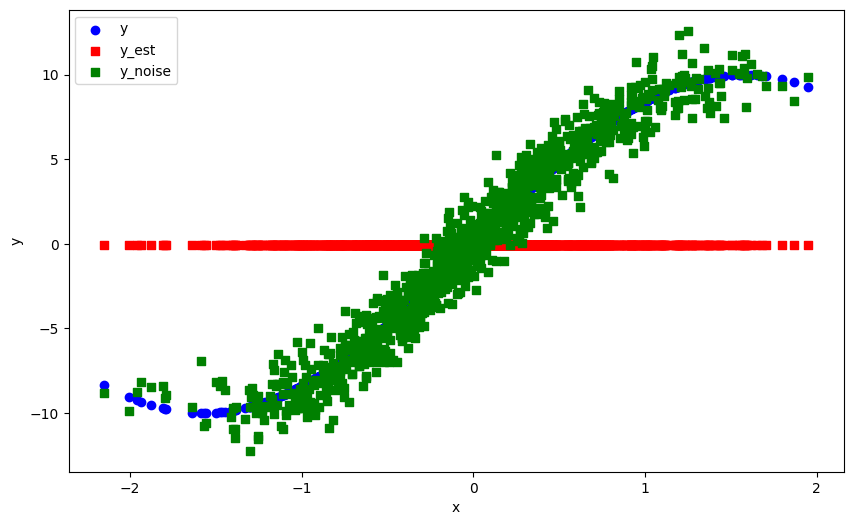

The programm is closed


In [15]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 0], X.detach().numpy()[:, 1], label='y', color='blue', marker='o')  # Plot x vs. y1
plt.scatter(X.detach().numpy()[:, 0], x_est.detach().numpy()[:, 1], label='y_est', color='red', marker='s') 
plt.scatter(X.detach().numpy()[:, 0], X_true.detach().numpy()[:, 1], label='y_noise', color='green', marker='s') 
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

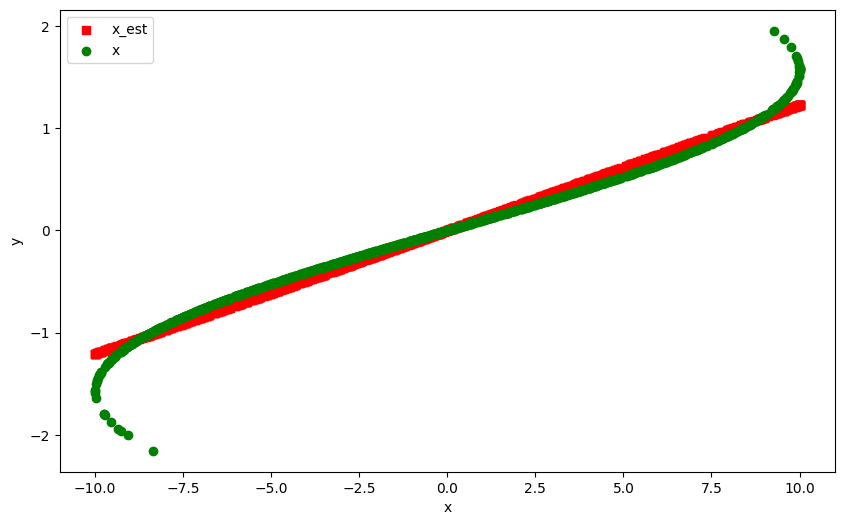

The programm is closed


In [16]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 1], x_est.detach().numpy()[:, 0], label='x_est', color='red', marker='s') 
plt.scatter(X.detach().numpy()[:, 1], X.detach().numpy()[:, 0], label='x', color='green', marker='o')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

### DAGMA init

In [17]:
np.random.seed(0)
n_samples = 1000  # Number of samples
dim = 2  # Dimension of the normal vectors
d = 2
# Random data for X and X_hat
True_Sigma = np.array([[0.5, 0.0],    # Variance of X is 1, covariance between X and Y is 0.8
                [0.0, 1.5]])   # Variance of Y is 1, covariance between Y and X is 0.8
epsilon = np.random.multivariate_normal([0] * dim, True_Sigma, size=n_samples) #[n, d]
epsilon = torch.tensor(epsilon, dtype=torch.float64)
x1 = epsilon[:, 0]
# x1 = torch.randn(n_samples)
x1_true = epsilon[:, 0]
x2 = 10*torch.sin(x1)
# Step 4: Combine these results into a new tensor of shape [n, 2]
X = torch.stack((x1, x2), dim=1)
x2_true = 10*torch.sin(x1)+ epsilon[:, 1]
X_true = torch.stack((x1_true, x2_true), dim=1)

In [18]:
eq_model = nonlinear.DagmaMLP(
    dims=[d, 10, 1], bias=True, dtype=torch.double)
model = nonlinear.DagmaNonlinear(
    eq_model, dtype=torch.double, use_mse_loss=True)

W_est_dagma = model.fit(X, lambda1=2e-2, lambda2=0.005,
                        T=1, lr=2e-4, w_threshold=0.3, mu_init=0.1, warm_iter=70000, max_iter=80000)

# Use DAGMA weights as initial weights for DAGMA-DCE
fc1_weight = eq_model.fc1.weight
fc1_bias = eq_model.fc1.bias
fc2_weight = eq_model.fc2[0].weight
fc2_bias = eq_model.fc2[0].bias

eq_model = nonlinear_dce.DagmaMLP_DCE(
    dims=[d, 10, 1], bias=True)
model = nonlinear_dce.DagmaDCE(eq_model, use_mle_loss=True)
eq_model.fc1.weight = fc1_weight
eq_model.fc1.bias = fc1_bias
eq_model.fc2[0].weight = fc2_weight
eq_model.fc2[0].bias = fc2_bias

W_est_dce_no_thresh, W2, x_est = model.fit(X, lambda1=3.5e-2, lambda2=5e-3,
                                lr=2e-4, mu_factor=0.1, mu_init=1, T=4, warm_iter=7000, max_iter=8000)

  1%|          | 161/29000 [00:00<01:11, 401.56it/s]

Sigma:  tensor([[9.6082e-01, 3.8500e-04],
        [3.8500e-04, 9.6079e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.7165, grad_fn=<AddBackward0>)
mle loss:  tensor(0.4550, grad_fn=<AddBackward0>)
h_val:  tensor(0.0066, grad_fn=<AddBackward0>)


  1%|          | 241/29000 [00:00<01:16, 375.20it/s]

Sigma:  tensor([[9.2332e-01, 2.1585e-04],
        [2.1585e-04, 9.2311e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.6445, grad_fn=<AddBackward0>)
mle loss:  tensor(0.3839, grad_fn=<AddBackward0>)
h_val:  tensor(0.0098, grad_fn=<AddBackward0>)


  1%|          | 359/29000 [00:00<01:15, 378.28it/s]

Sigma:  tensor([[8.8737e-01, 3.1645e-04],
        [3.1645e-04, 8.8693e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.5648, grad_fn=<AddBackward0>)
mle loss:  tensor(0.3029, grad_fn=<AddBackward0>)
h_val:  tensor(0.0144, grad_fn=<AddBackward0>)


  2%|▏         | 476/29000 [00:01<01:14, 381.18it/s]

Sigma:  tensor([[8.5273e-01, 2.1796e-04],
        [2.1796e-04, 8.5218e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.4778, grad_fn=<AddBackward0>)
mle loss:  tensor(0.2122, grad_fn=<AddBackward0>)
h_val:  tensor(0.0208, grad_fn=<AddBackward0>)


  2%|▏         | 553/29000 [00:01<01:16, 373.85it/s]

Sigma:  tensor([[8.1906e-01, 2.3075e-04],
        [2.3075e-04, 8.1882e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.3856, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1134, grad_fn=<AddBackward0>)
h_val:  tensor(0.0294, grad_fn=<AddBackward0>)


  2%|▏         | 670/29000 [00:01<01:14, 379.80it/s]

Sigma:  tensor([[7.8614e-01, 2.8485e-04],
        [2.8485e-04, 7.8677e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.2897, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0081, grad_fn=<AddBackward0>)
h_val:  tensor(0.0408, grad_fn=<AddBackward0>)


  3%|▎         | 748/29000 [00:01<01:14, 379.20it/s]

Sigma:  tensor([[7.5381e-01, 3.1685e-04],
        [3.1685e-04, 7.5599e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.1898, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.1043, grad_fn=<AddBackward0>)
h_val:  tensor(0.0555, grad_fn=<AddBackward0>)


  3%|▎         | 867/29000 [00:02<01:13, 385.18it/s]

Sigma:  tensor([[7.2200e-01, 3.4343e-04],
        [3.4343e-04, 7.2643e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0857, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.2251, grad_fn=<AddBackward0>)
h_val:  tensor(0.0745, grad_fn=<AddBackward0>)


  3%|▎         | 944/29000 [00:02<01:14, 376.85it/s]

Sigma:  tensor([[6.9065e-01, 3.7055e-04],
        [3.7055e-04, 6.9804e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0208, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.3536, grad_fn=<AddBackward0>)
h_val:  tensor(0.0992, grad_fn=<AddBackward0>)


  4%|▎         | 1062/29000 [00:02<01:13, 380.59it/s]

Sigma:  tensor([[6.5978e-01, 4.3772e-04],
        [4.3772e-04, 6.7078e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1255, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.4857, grad_fn=<AddBackward0>)
h_val:  tensor(0.1295, grad_fn=<AddBackward0>)


  4%|▍         | 1139/29000 [00:03<01:14, 375.28it/s]

Sigma:  tensor([[6.2953e-01, 5.3888e-04],
        [5.3888e-04, 6.4461e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2246, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.6152, grad_fn=<AddBackward0>)
h_val:  tensor(0.1632, grad_fn=<AddBackward0>)


  4%|▍         | 1262/29000 [00:03<01:11, 389.06it/s]

Sigma:  tensor([[0.6001, 0.0006],
        [0.0006, 0.6195]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3172, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7354, grad_fn=<AddBackward0>)
h_val:  tensor(0.1945, grad_fn=<AddBackward0>)


  5%|▍         | 1340/29000 [00:03<01:12, 382.48it/s]

Sigma:  tensor([[0.5719, 0.0007],
        [0.0007, 0.5954]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4063, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8429, grad_fn=<AddBackward0>)
h_val:  tensor(0.2168, grad_fn=<AddBackward0>)


  5%|▌         | 1465/29000 [00:03<01:08, 400.29it/s]

Sigma:  tensor([[0.5451, 0.0009],
        [0.0009, 0.5722]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4945, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9393, grad_fn=<AddBackward0>)
h_val:  tensor(0.2287, grad_fn=<AddBackward0>)


  5%|▌         | 1546/29000 [00:04<01:09, 395.66it/s]

Sigma:  tensor([[0.5199, 0.0009],
        [0.0009, 0.5500]], grad_fn=<MmBackward0>)
obj:  tensor(-0.5818, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0303, grad_fn=<AddBackward0>)
h_val:  tensor(0.2355, grad_fn=<AddBackward0>)


  6%|▌         | 1672/29000 [00:04<01:07, 405.72it/s]

Sigma:  tensor([[0.4961, 0.0010],
        [0.0010, 0.5286]], grad_fn=<MmBackward0>)
obj:  tensor(-0.6677, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.1215, grad_fn=<AddBackward0>)
h_val:  tensor(0.2429, grad_fn=<AddBackward0>)


  6%|▌         | 1754/29000 [00:04<01:08, 398.81it/s]

Sigma:  tensor([[0.4737, 0.0010],
        [0.0010, 0.5081]], grad_fn=<MmBackward0>)
obj:  tensor(-0.7524, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.2142, grad_fn=<AddBackward0>)
h_val:  tensor(0.2525, grad_fn=<AddBackward0>)


  6%|▋         | 1877/29000 [00:04<01:07, 401.03it/s]

Sigma:  tensor([[0.4526, 0.0010],
        [0.0010, 0.4884]], grad_fn=<MmBackward0>)
obj:  tensor(-0.8354, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.3057, grad_fn=<AddBackward0>)
h_val:  tensor(0.2620, grad_fn=<AddBackward0>)


  7%|▋         | 1958/29000 [00:05<01:08, 396.91it/s]

Sigma:  tensor([[0.4326, 0.0010],
        [0.0010, 0.4695]], grad_fn=<MmBackward0>)
obj:  tensor(-0.9167, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.3944, grad_fn=<AddBackward0>)
h_val:  tensor(0.2699, grad_fn=<AddBackward0>)


  7%|▋         | 2082/29000 [00:05<01:06, 406.72it/s]

Sigma:  tensor([[0.4136, 0.0010],
        [0.0010, 0.4514]], grad_fn=<MmBackward0>)
obj:  tensor(-0.9965, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.4816, grad_fn=<AddBackward0>)
h_val:  tensor(0.2773, grad_fn=<AddBackward0>)


  7%|▋         | 2164/29000 [00:05<01:07, 398.98it/s]

Sigma:  tensor([[0.3956, 0.0009],
        [0.0009, 0.4339]], grad_fn=<MmBackward0>)
obj:  tensor(-1.0752, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5678, grad_fn=<AddBackward0>)
h_val:  tensor(0.2846, grad_fn=<AddBackward0>)


  8%|▊         | 2244/29000 [00:05<01:07, 395.44it/s]

Sigma:  tensor([[0.3785, 0.0009],
        [0.0009, 0.4171]], grad_fn=<MmBackward0>)
obj:  tensor(-1.1528, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.6521, grad_fn=<AddBackward0>)
h_val:  tensor(0.2910, grad_fn=<AddBackward0>)


  8%|▊         | 2371/29000 [00:06<01:06, 398.17it/s]

Sigma:  tensor([[0.3623, 0.0008],
        [0.0008, 0.4010]], grad_fn=<MmBackward0>)
obj:  tensor(-1.2298, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.7351, grad_fn=<AddBackward0>)
h_val:  tensor(0.2968, grad_fn=<AddBackward0>)


  8%|▊         | 2451/29000 [00:06<01:07, 391.00it/s]

Sigma:  tensor([[0.3470, 0.0008],
        [0.0008, 0.3855]], grad_fn=<MmBackward0>)
obj:  tensor(-1.3063, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8172, grad_fn=<AddBackward0>)
h_val:  tensor(0.3024, grad_fn=<AddBackward0>)


  9%|▉         | 2575/29000 [00:06<01:05, 400.78it/s]

Sigma:  tensor([[0.3323, 0.0008],
        [0.0008, 0.3706]], grad_fn=<MmBackward0>)
obj:  tensor(-1.3823, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8984, grad_fn=<AddBackward0>)
h_val:  tensor(0.3077, grad_fn=<AddBackward0>)


  9%|▉         | 2657/29000 [00:06<01:06, 397.62it/s]

Sigma:  tensor([[0.3184, 0.0007],
        [0.0007, 0.3563]], grad_fn=<MmBackward0>)
obj:  tensor(-1.4581, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9793, grad_fn=<AddBackward0>)
h_val:  tensor(0.3131, grad_fn=<AddBackward0>)


 10%|▉         | 2781/29000 [00:07<01:04, 405.95it/s]

Sigma:  tensor([[0.3052, 0.0007],
        [0.0007, 0.3426]], grad_fn=<MmBackward0>)
obj:  tensor(-1.5336, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0599, grad_fn=<AddBackward0>)
h_val:  tensor(0.3185, grad_fn=<AddBackward0>)


 10%|▉         | 2862/29000 [00:07<01:05, 397.35it/s]

Sigma:  tensor([[0.2926, 0.0007],
        [0.0007, 0.3294]], grad_fn=<MmBackward0>)
obj:  tensor(-1.6089, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1404, grad_fn=<AddBackward0>)
h_val:  tensor(0.3240, grad_fn=<AddBackward0>)


 10%|█         | 2942/29000 [00:07<01:27, 297.83it/s]

Sigma:  tensor([[0.2805, 0.0007],
        [0.0007, 0.3167]], grad_fn=<MmBackward0>)
obj:  tensor(-1.6842, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2206, grad_fn=<AddBackward0>)
h_val:  tensor(0.3294, grad_fn=<AddBackward0>)


 11%|█         | 3066/29000 [00:08<01:11, 361.63it/s]

Sigma:  tensor([[0.2690, 0.0006],
        [0.0006, 0.3045]], grad_fn=<MmBackward0>)
obj:  tensor(-1.7593, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.3007, grad_fn=<AddBackward0>)
h_val:  tensor(0.3346, grad_fn=<AddBackward0>)


 11%|█         | 3145/29000 [00:08<01:09, 373.36it/s]

Sigma:  tensor([[0.2580, 0.0006],
        [0.0006, 0.2927]], grad_fn=<MmBackward0>)
obj:  tensor(-1.8344, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.3806, grad_fn=<AddBackward0>)
h_val:  tensor(0.3398, grad_fn=<AddBackward0>)


 11%|█▏        | 3269/29000 [00:08<01:05, 394.35it/s]

Sigma:  tensor([[0.2476, 0.0005],
        [0.0005, 0.2814]], grad_fn=<MmBackward0>)
obj:  tensor(-1.9094, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4604, grad_fn=<AddBackward0>)
h_val:  tensor(0.3447, grad_fn=<AddBackward0>)


 12%|█▏        | 3349/29000 [00:08<01:05, 389.16it/s]

Sigma:  tensor([[0.2375, 0.0004],
        [0.0004, 0.2706]], grad_fn=<MmBackward0>)
obj:  tensor(-1.9844, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.5400, grad_fn=<AddBackward0>)
h_val:  tensor(0.3496, grad_fn=<AddBackward0>)


 12%|█▏        | 3472/29000 [00:09<01:03, 400.59it/s]

Sigma:  tensor([[0.2279, 0.0003],
        [0.0003, 0.2601]], grad_fn=<MmBackward0>)
obj:  tensor(-2.0594, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6197, grad_fn=<AddBackward0>)
h_val:  tensor(0.3544, grad_fn=<AddBackward0>)


 12%|█▏        | 3553/29000 [00:09<01:04, 397.24it/s]

Sigma:  tensor([[2.1875e-01, 2.2030e-04],
        [2.2030e-04, 2.5008e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-2.1345, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6993, grad_fn=<AddBackward0>)
h_val:  tensor(0.3591, grad_fn=<AddBackward0>)


 13%|█▎        | 3678/29000 [00:09<01:02, 402.65it/s]

Sigma:  tensor([[2.0996e-01, 9.4416e-05],
        [9.4416e-05, 2.4043e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-2.2097, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7791, grad_fn=<AddBackward0>)
h_val:  tensor(0.3638, grad_fn=<AddBackward0>)


 13%|█▎        | 3760/29000 [00:09<01:03, 397.53it/s]

Sigma:  tensor([[ 2.0154e-01, -5.6206e-05],
        [-5.6206e-05,  2.3114e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-2.2850, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.8590, grad_fn=<AddBackward0>)
h_val:  tensor(0.3686, grad_fn=<AddBackward0>)


 13%|█▎        | 3840/29000 [00:09<01:04, 390.87it/s]

Sigma:  tensor([[ 0.1935, -0.0002],
        [-0.0002,  0.2222]], grad_fn=<MmBackward0>)
obj:  tensor(-2.3605, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.9391, grad_fn=<AddBackward0>)
h_val:  tensor(0.3734, grad_fn=<AddBackward0>)


 14%|█▎        | 3965/29000 [00:10<01:03, 393.04it/s]

Sigma:  tensor([[ 0.1857, -0.0005],
        [-0.0005,  0.2136]], grad_fn=<MmBackward0>)
obj:  tensor(-2.4361, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.0195, grad_fn=<AddBackward0>)
h_val:  tensor(0.3784, grad_fn=<AddBackward0>)


 14%|█▍        | 4045/29000 [00:10<01:03, 391.71it/s]

Sigma:  tensor([[ 0.1783, -0.0007],
        [-0.0007,  0.2054]], grad_fn=<MmBackward0>)
obj:  tensor(-2.5121, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1002, grad_fn=<AddBackward0>)
h_val:  tensor(0.3834, grad_fn=<AddBackward0>)


 14%|█▍        | 4173/29000 [00:10<01:01, 405.30it/s]

Sigma:  tensor([[ 0.1712, -0.0010],
        [-0.0010,  0.1974]], grad_fn=<MmBackward0>)
obj:  tensor(-2.5882, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1812, grad_fn=<AddBackward0>)
h_val:  tensor(0.3885, grad_fn=<AddBackward0>)


 15%|█▍        | 4254/29000 [00:11<01:02, 393.87it/s]

Sigma:  tensor([[ 0.1644, -0.0013],
        [-0.0013,  0.1898]], grad_fn=<MmBackward0>)
obj:  tensor(-2.6647, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.2624, grad_fn=<AddBackward0>)
h_val:  tensor(0.3936, grad_fn=<AddBackward0>)


 15%|█▌        | 4375/29000 [00:11<01:02, 393.93it/s]

Sigma:  tensor([[ 0.1578, -0.0017],
        [-0.0017,  0.1824]], grad_fn=<MmBackward0>)
obj:  tensor(-2.7414, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.3436, grad_fn=<AddBackward0>)
h_val:  tensor(0.3986, grad_fn=<AddBackward0>)


 15%|█▌        | 4454/29000 [00:11<01:03, 386.35it/s]

Sigma:  tensor([[ 0.1515, -0.0020],
        [-0.0020,  0.1754]], grad_fn=<MmBackward0>)
obj:  tensor(-2.8185, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.4250, grad_fn=<AddBackward0>)
h_val:  tensor(0.4032, grad_fn=<AddBackward0>)


 16%|█▌        | 4575/29000 [00:11<01:01, 397.83it/s]

Sigma:  tensor([[ 0.1455, -0.0024],
        [-0.0024,  0.1686]], grad_fn=<MmBackward0>)
obj:  tensor(-2.8959, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.5064, grad_fn=<AddBackward0>)
h_val:  tensor(0.4076, grad_fn=<AddBackward0>)


 16%|█▌        | 4655/29000 [00:12<01:02, 389.17it/s]

Sigma:  tensor([[ 0.1397, -0.0028],
        [-0.0028,  0.1620]], grad_fn=<MmBackward0>)
obj:  tensor(-2.9737, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.5881, grad_fn=<AddBackward0>)
h_val:  tensor(0.4118, grad_fn=<AddBackward0>)


 16%|█▋        | 4776/29000 [00:12<01:01, 395.52it/s]

Sigma:  tensor([[ 0.1342, -0.0033],
        [-0.0033,  0.1557]], grad_fn=<MmBackward0>)
obj:  tensor(-3.0518, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6700, grad_fn=<AddBackward0>)
h_val:  tensor(0.4159, grad_fn=<AddBackward0>)


 17%|█▋        | 4856/29000 [00:12<01:01, 390.32it/s]

Sigma:  tensor([[ 0.1289, -0.0037],
        [-0.0037,  0.1497]], grad_fn=<MmBackward0>)
obj:  tensor(-3.1304, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7522, grad_fn=<AddBackward0>)
h_val:  tensor(0.4198, grad_fn=<AddBackward0>)


 17%|█▋        | 4978/29000 [00:12<01:00, 397.18it/s]

Sigma:  tensor([[ 0.1237, -0.0041],
        [-0.0041,  0.1439]], grad_fn=<MmBackward0>)
obj:  tensor(-3.2093, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8347, grad_fn=<AddBackward0>)
h_val:  tensor(0.4235, grad_fn=<AddBackward0>)


 17%|█▋        | 5058/29000 [00:13<01:02, 383.20it/s]

Sigma:  tensor([[ 0.1188, -0.0045],
        [-0.0045,  0.1383]], grad_fn=<MmBackward0>)
obj:  tensor(-3.2887, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.9174, grad_fn=<AddBackward0>)
h_val:  tensor(0.4272, grad_fn=<AddBackward0>)


 18%|█▊        | 5181/29000 [00:13<00:59, 401.04it/s]

Sigma:  tensor([[ 0.1141, -0.0050],
        [-0.0050,  0.1329]], grad_fn=<MmBackward0>)
obj:  tensor(-3.3684, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.0006, grad_fn=<AddBackward0>)
h_val:  tensor(0.4308, grad_fn=<AddBackward0>)


 18%|█▊        | 5262/29000 [00:13<01:00, 392.98it/s]

Sigma:  tensor([[ 0.1096, -0.0054],
        [-0.0054,  0.1277]], grad_fn=<MmBackward0>)
obj:  tensor(-3.4486, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.0841, grad_fn=<AddBackward0>)
h_val:  tensor(0.4343, grad_fn=<AddBackward0>)


 18%|█▊        | 5342/29000 [00:13<01:00, 388.55it/s]

Sigma:  tensor([[ 0.1053, -0.0058],
        [-0.0058,  0.1228]], grad_fn=<MmBackward0>)
obj:  tensor(-3.5291, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.1681, grad_fn=<AddBackward0>)
h_val:  tensor(0.4379, grad_fn=<AddBackward0>)


 19%|█▉        | 5468/29000 [00:14<00:58, 402.60it/s]

Sigma:  tensor([[ 0.1011, -0.0062],
        [-0.0062,  0.1180]], grad_fn=<MmBackward0>)
obj:  tensor(-3.6100, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.2524, grad_fn=<AddBackward0>)
h_val:  tensor(0.4415, grad_fn=<AddBackward0>)


 19%|█▉        | 5549/29000 [00:14<00:59, 391.70it/s]

Sigma:  tensor([[ 0.0971, -0.0067],
        [-0.0067,  0.1134]], grad_fn=<MmBackward0>)
obj:  tensor(-3.6912, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3371, grad_fn=<AddBackward0>)
h_val:  tensor(0.4452, grad_fn=<AddBackward0>)


 20%|█▉        | 5671/29000 [00:14<00:58, 398.11it/s]

Sigma:  tensor([[ 0.0932, -0.0071],
        [-0.0071,  0.1090]], grad_fn=<MmBackward0>)
obj:  tensor(-3.7727, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4221, grad_fn=<AddBackward0>)
h_val:  tensor(0.4490, grad_fn=<AddBackward0>)


 20%|█▉        | 5751/29000 [00:15<01:48, 214.84it/s]

Sigma:  tensor([[ 0.0896, -0.0075],
        [-0.0075,  0.1048]], grad_fn=<MmBackward0>)
obj:  tensor(-3.8544, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5074, grad_fn=<AddBackward0>)
h_val:  tensor(0.4528, grad_fn=<AddBackward0>)


 20%|██        | 5870/29000 [00:15<01:14, 308.62it/s]

Sigma:  tensor([[ 0.0860, -0.0080],
        [-0.0080,  0.1008]], grad_fn=<MmBackward0>)
obj:  tensor(-3.9364, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5930, grad_fn=<AddBackward0>)
h_val:  tensor(0.4566, grad_fn=<AddBackward0>)


 21%|██        | 5947/29000 [00:15<01:07, 339.25it/s]

Sigma:  tensor([[ 0.0826, -0.0084],
        [-0.0084,  0.0969]], grad_fn=<MmBackward0>)
obj:  tensor(-4.0185, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.6788, grad_fn=<AddBackward0>)
h_val:  tensor(0.4606, grad_fn=<AddBackward0>)


 21%|██        | 6070/29000 [00:16<01:00, 378.78it/s]

Sigma:  tensor([[ 0.0793, -0.0088],
        [-0.0088,  0.0932]], grad_fn=<MmBackward0>)
obj:  tensor(-4.1009, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7648, grad_fn=<AddBackward0>)
h_val:  tensor(0.4646, grad_fn=<AddBackward0>)


 21%|██        | 6149/29000 [00:16<01:00, 380.77it/s]

Sigma:  tensor([[ 0.0762, -0.0092],
        [-0.0092,  0.0897]], grad_fn=<MmBackward0>)
obj:  tensor(-4.1835, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8510, grad_fn=<AddBackward0>)
h_val:  tensor(0.4686, grad_fn=<AddBackward0>)


 22%|██▏       | 6272/29000 [00:16<00:57, 394.78it/s]

Sigma:  tensor([[ 0.0732, -0.0095],
        [-0.0095,  0.0863]], grad_fn=<MmBackward0>)
obj:  tensor(-4.2662, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9374, grad_fn=<AddBackward0>)
h_val:  tensor(0.4726, grad_fn=<AddBackward0>)


 22%|██▏       | 6351/29000 [00:16<00:59, 377.85it/s]

Sigma:  tensor([[ 0.0703, -0.0099],
        [-0.0099,  0.0830]], grad_fn=<MmBackward0>)
obj:  tensor(-4.3490, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0238, grad_fn=<AddBackward0>)
h_val:  tensor(0.4766, grad_fn=<AddBackward0>)


 22%|██▏       | 6472/29000 [00:17<00:57, 392.10it/s]

Sigma:  tensor([[ 0.0675, -0.0102],
        [-0.0102,  0.0799]], grad_fn=<MmBackward0>)
obj:  tensor(-4.4318, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.1101, grad_fn=<AddBackward0>)
h_val:  tensor(0.4805, grad_fn=<AddBackward0>)


 23%|██▎       | 6551/29000 [00:17<00:58, 382.83it/s]

Sigma:  tensor([[ 0.0648, -0.0104],
        [-0.0104,  0.0769]], grad_fn=<MmBackward0>)
obj:  tensor(-4.5145, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.1962, grad_fn=<AddBackward0>)
h_val:  tensor(0.4843, grad_fn=<AddBackward0>)


 23%|██▎       | 6673/29000 [00:17<00:56, 396.52it/s]

Sigma:  tensor([[ 0.0622, -0.0106],
        [-0.0106,  0.0740]], grad_fn=<MmBackward0>)
obj:  tensor(-4.5972, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.2822, grad_fn=<AddBackward0>)
h_val:  tensor(0.4880, grad_fn=<AddBackward0>)


 23%|██▎       | 6753/29000 [00:17<00:57, 389.70it/s]

Sigma:  tensor([[ 0.0598, -0.0108],
        [-0.0108,  0.0712]], grad_fn=<MmBackward0>)
obj:  tensor(-4.6797, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.3679, grad_fn=<AddBackward0>)
h_val:  tensor(0.4915, grad_fn=<AddBackward0>)


 24%|██▎       | 6876/29000 [00:18<00:55, 397.71it/s]

Sigma:  tensor([[ 0.0574, -0.0109],
        [-0.0109,  0.0686]], grad_fn=<MmBackward0>)
obj:  tensor(-4.7621, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.4534, grad_fn=<AddBackward0>)
h_val:  tensor(0.4949, grad_fn=<AddBackward0>)


 24%|██▍       | 6956/29000 [00:18<00:56, 391.18it/s]

Sigma:  tensor([[ 0.0551, -0.0110],
        [-0.0110,  0.0660]], grad_fn=<MmBackward0>)
obj:  tensor(-4.8444, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.5387, grad_fn=<AddBackward0>)
h_val:  tensor(0.4982, grad_fn=<AddBackward0>)


 25%|██▍       | 7162/29000 [00:18<00:53, 407.69it/s]

Sigma:  tensor([[ 0.0516, -0.0069],
        [-0.0069,  0.0606]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1246, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9617, grad_fn=<AddBackward0>)
h_val:  tensor(0.3519, grad_fn=<AddBackward0>)


 25%|██▍       | 7244/29000 [00:19<00:54, 398.03it/s]

Sigma:  tensor([[ 0.0509, -0.0024],
        [-0.0024,  0.0579]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1461, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7894, grad_fn=<AddBackward0>)
h_val:  tensor(0.3126, grad_fn=<AddBackward0>)


 25%|██▌       | 7370/29000 [00:19<00:54, 399.77it/s]

Sigma:  tensor([[0.0503, 0.0007],
        [0.0007, 0.0559]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1594, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0321, grad_fn=<AddBackward0>)
h_val:  tensor(0.3231, grad_fn=<AddBackward0>)


 26%|██▌       | 7451/29000 [00:19<00:56, 381.57it/s]

Sigma:  tensor([[0.0495, 0.0015],
        [0.0015, 0.0541]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1710, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8559, grad_fn=<AddBackward0>)
h_val:  tensor(0.2936, grad_fn=<AddBackward0>)


 26%|██▌       | 7571/29000 [00:19<00:54, 391.49it/s]

Sigma:  tensor([[0.0490, 0.0010],
        [0.0010, 0.0522]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1809, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9095, grad_fn=<AddBackward0>)
h_val:  tensor(0.2889, grad_fn=<AddBackward0>)


 26%|██▋       | 7651/29000 [00:20<00:54, 388.29it/s]

Sigma:  tensor([[0.0486, 0.0006],
        [0.0006, 0.0503]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1895, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0231, grad_fn=<AddBackward0>)
h_val:  tensor(0.2916, grad_fn=<AddBackward0>)


 27%|██▋       | 7775/29000 [00:20<00:53, 397.32it/s]

Sigma:  tensor([[0.0481, 0.0008],
        [0.0008, 0.0484]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1971, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9866, grad_fn=<AddBackward0>)
h_val:  tensor(0.2800, grad_fn=<AddBackward0>)


 27%|██▋       | 7855/29000 [00:20<00:53, 392.99it/s]

Sigma:  tensor([[0.0478, 0.0013],
        [0.0013, 0.0466]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2042, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0343, grad_fn=<AddBackward0>)
h_val:  tensor(0.2774, grad_fn=<AddBackward0>)


 28%|██▊       | 7978/29000 [00:20<00:53, 396.00it/s]

Sigma:  tensor([[0.0476, 0.0015],
        [0.0015, 0.0449]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2106, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0281, grad_fn=<AddBackward0>)
h_val:  tensor(0.2701, grad_fn=<AddBackward0>)


 28%|██▊       | 8058/29000 [00:21<00:53, 389.17it/s]

Sigma:  tensor([[0.0475, 0.0013],
        [0.0013, 0.0432]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2167, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0619, grad_fn=<AddBackward0>)
h_val:  tensor(0.2672, grad_fn=<AddBackward0>)


 28%|██▊       | 8179/29000 [00:21<00:52, 398.40it/s]

Sigma:  tensor([[0.0476, 0.0013],
        [0.0013, 0.0415]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2224, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0713, grad_fn=<AddBackward0>)
h_val:  tensor(0.2622, grad_fn=<AddBackward0>)


 28%|██▊       | 8260/29000 [00:21<00:52, 395.07it/s]

Sigma:  tensor([[0.0478, 0.0013],
        [0.0013, 0.0399]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2279, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0928, grad_fn=<AddBackward0>)
h_val:  tensor(0.2586, grad_fn=<AddBackward0>)


 29%|██▉       | 8340/29000 [00:21<00:53, 386.98it/s]

Sigma:  tensor([[0.0482, 0.0012],
        [0.0012, 0.0384]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2332, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.1057, grad_fn=<AddBackward0>)
h_val:  tensor(0.2544, grad_fn=<AddBackward0>)


 29%|██▉       | 8465/29000 [00:22<00:51, 397.33it/s]

Sigma:  tensor([[0.0487, 0.0011],
        [0.0011, 0.0369]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2384, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.1210, grad_fn=<AddBackward0>)
h_val:  tensor(0.2505, grad_fn=<AddBackward0>)


 29%|██▉       | 8540/29000 [00:22<01:11, 285.25it/s]

Sigma:  tensor([[0.0495, 0.0010],
        [0.0010, 0.0355]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2435, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.1299, grad_fn=<AddBackward0>)
h_val:  tensor(0.2461, grad_fn=<AddBackward0>)


 30%|██▉       | 8662/29000 [00:22<00:57, 353.57it/s]

Sigma:  tensor([[0.0504, 0.0010],
        [0.0010, 0.0341]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2486, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.1366, grad_fn=<AddBackward0>)
h_val:  tensor(0.2415, grad_fn=<AddBackward0>)


 30%|███       | 8781/29000 [00:23<00:52, 383.13it/s]

Sigma:  tensor([[0.0516, 0.0009],
        [0.0009, 0.0328]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2536, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.1398, grad_fn=<AddBackward0>)
h_val:  tensor(0.2366, grad_fn=<AddBackward0>)


 31%|███       | 8861/29000 [00:23<00:52, 385.13it/s]

Sigma:  tensor([[0.0530, 0.0008],
        [0.0008, 0.0315]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2587, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.1391, grad_fn=<AddBackward0>)
h_val:  tensor(0.2313, grad_fn=<AddBackward0>)


 31%|███       | 8939/29000 [00:23<00:52, 382.18it/s]

Sigma:  tensor([[0.0546, 0.0007],
        [0.0007, 0.0303]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2638, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.1356, grad_fn=<AddBackward0>)
h_val:  tensor(0.2257, grad_fn=<AddBackward0>)


 31%|███▏      | 9064/29000 [00:23<00:50, 395.22it/s]

Sigma:  tensor([[0.0565, 0.0006],
        [0.0006, 0.0291]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2690, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.1292, grad_fn=<AddBackward0>)
h_val:  tensor(0.2198, grad_fn=<AddBackward0>)


 32%|███▏      | 9143/29000 [00:24<00:51, 386.40it/s]

Sigma:  tensor([[0.0586, 0.0005],
        [0.0005, 0.0279]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2742, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.1203, grad_fn=<AddBackward0>)
h_val:  tensor(0.2135, grad_fn=<AddBackward0>)


 32%|███▏      | 9268/29000 [00:24<00:49, 396.58it/s]

Sigma:  tensor([[0.0610, 0.0004],
        [0.0004, 0.0268]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2796, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.1098, grad_fn=<AddBackward0>)
h_val:  tensor(0.2070, grad_fn=<AddBackward0>)


 32%|███▏      | 9347/29000 [00:24<00:50, 387.30it/s]

Sigma:  tensor([[0.0636, 0.0003],
        [0.0003, 0.0258]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2850, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0982, grad_fn=<AddBackward0>)
h_val:  tensor(0.2002, grad_fn=<AddBackward0>)


 33%|███▎      | 9472/29000 [00:24<00:48, 400.72it/s]

Sigma:  tensor([[0.0664, 0.0002],
        [0.0002, 0.0248]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2905, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0860, grad_fn=<AddBackward0>)
h_val:  tensor(0.1934, grad_fn=<AddBackward0>)


 33%|███▎      | 9552/29000 [00:25<00:50, 382.47it/s]

Sigma:  tensor([[0.0695, 0.0002],
        [0.0002, 0.0238]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2961, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0738, grad_fn=<AddBackward0>)
h_val:  tensor(0.1864, grad_fn=<AddBackward0>)


 33%|███▎      | 9674/29000 [00:25<00:48, 395.36it/s]

Sigma:  tensor([[0.0727, 0.0001],
        [0.0001, 0.0229]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3018, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0621, grad_fn=<AddBackward0>)
h_val:  tensor(0.1795, grad_fn=<AddBackward0>)


 34%|███▎      | 9753/29000 [00:25<00:49, 385.74it/s]

Sigma:  tensor([[7.6130e-02, 4.5043e-05],
        [4.5043e-05, 2.1960e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3076, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0514, grad_fn=<AddBackward0>)
h_val:  tensor(0.1725, grad_fn=<AddBackward0>)


 34%|███▍      | 9874/29000 [00:25<00:48, 394.93it/s]

Sigma:  tensor([[ 7.9753e-02, -7.4356e-06],
        [-7.4356e-06,  2.1095e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3134, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0420, grad_fn=<AddBackward0>)
h_val:  tensor(0.1657, grad_fn=<AddBackward0>)


 34%|███▍      | 9953/29000 [00:26<00:49, 385.42it/s]

Sigma:  tensor([[ 8.3552e-02, -5.2866e-05],
        [-5.2866e-05,  2.0263e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3192, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0343, grad_fn=<AddBackward0>)
h_val:  tensor(0.1590, grad_fn=<AddBackward0>)


 35%|███▍      | 10074/29000 [00:26<00:47, 397.61it/s]

Sigma:  tensor([[ 8.7520e-02, -9.1156e-05],
        [-9.1156e-05,  1.9463e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3251, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0284, grad_fn=<AddBackward0>)
h_val:  tensor(0.1524, grad_fn=<AddBackward0>)


 35%|███▌      | 10154/29000 [00:26<00:48, 388.39it/s]

Sigma:  tensor([[ 0.0916, -0.0001],
        [-0.0001,  0.0187]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3310, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0246, grad_fn=<AddBackward0>)
h_val:  tensor(0.1460, grad_fn=<AddBackward0>)


 35%|███▌      | 10274/29000 [00:27<00:47, 394.99it/s]

Sigma:  tensor([[ 0.0959, -0.0001],
        [-0.0001,  0.0180]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3369, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0229, grad_fn=<AddBackward0>)
h_val:  tensor(0.1399, grad_fn=<AddBackward0>)


 36%|███▌      | 10353/29000 [00:27<00:48, 384.76it/s]

Sigma:  tensor([[ 0.1003, -0.0002],
        [-0.0002,  0.0172]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3428, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0234, grad_fn=<AddBackward0>)
h_val:  tensor(0.1339, grad_fn=<AddBackward0>)


 36%|███▌      | 10471/29000 [00:27<00:48, 379.49it/s]

Sigma:  tensor([[ 0.1049, -0.0002],
        [-0.0002,  0.0166]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3486, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0261, grad_fn=<AddBackward0>)
h_val:  tensor(0.1282, grad_fn=<AddBackward0>)


 36%|███▋      | 10550/29000 [00:27<00:48, 380.41it/s]

Sigma:  tensor([[ 0.1096, -0.0002],
        [-0.0002,  0.0159]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3545, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0309, grad_fn=<AddBackward0>)
h_val:  tensor(0.1228, grad_fn=<AddBackward0>)


 37%|███▋      | 10673/29000 [00:28<00:46, 394.46it/s]

Sigma:  tensor([[ 0.1144, -0.0002],
        [-0.0002,  0.0153]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3603, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0378, grad_fn=<AddBackward0>)
h_val:  tensor(0.1176, grad_fn=<AddBackward0>)


 37%|███▋      | 10753/29000 [00:28<00:46, 388.75it/s]

Sigma:  tensor([[ 0.1193, -0.0002],
        [-0.0002,  0.0146]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3660, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0465, grad_fn=<AddBackward0>)
h_val:  tensor(0.1126, grad_fn=<AddBackward0>)


 38%|███▊      | 10876/29000 [00:28<00:45, 397.26it/s]

Sigma:  tensor([[ 0.1243, -0.0002],
        [-0.0002,  0.0141]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3717, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0571, grad_fn=<AddBackward0>)
h_val:  tensor(0.1079, grad_fn=<AddBackward0>)


 38%|███▊      | 10955/29000 [00:28<00:46, 388.10it/s]

Sigma:  tensor([[ 0.1294, -0.0002],
        [-0.0002,  0.0135]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3773, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0692, grad_fn=<AddBackward0>)
h_val:  tensor(0.1034, grad_fn=<AddBackward0>)


 38%|███▊      | 11076/29000 [00:29<00:45, 394.50it/s]

Sigma:  tensor([[ 0.1346, -0.0002],
        [-0.0002,  0.0129]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3829, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0829, grad_fn=<AddBackward0>)
h_val:  tensor(0.0992, grad_fn=<AddBackward0>)


 38%|███▊      | 11155/29000 [00:29<00:46, 385.72it/s]

Sigma:  tensor([[ 0.1398, -0.0001],
        [-0.0001,  0.0124]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3884, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0980, grad_fn=<AddBackward0>)
h_val:  tensor(0.0951, grad_fn=<AddBackward0>)


 39%|███▉      | 11274/29000 [00:29<00:45, 393.41it/s]

Sigma:  tensor([[ 1.4516e-01, -1.2918e-04],
        [-1.2918e-04,  1.1925e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3937, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.1144, grad_fn=<AddBackward0>)
h_val:  tensor(0.0913, grad_fn=<AddBackward0>)


 39%|███▉      | 11353/29000 [00:29<00:46, 378.20it/s]

Sigma:  tensor([[ 1.5052e-01, -1.1449e-04],
        [-1.1449e-04,  1.1444e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3990, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.1320, grad_fn=<AddBackward0>)
h_val:  tensor(0.0877, grad_fn=<AddBackward0>)


 40%|███▉      | 11474/29000 [00:30<00:44, 389.50it/s]

Sigma:  tensor([[ 1.5592e-01, -9.9542e-05],
        [-9.9542e-05,  1.0982e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4042, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.1507, grad_fn=<AddBackward0>)
h_val:  tensor(0.0843, grad_fn=<AddBackward0>)


 40%|███▉      | 11553/29000 [00:30<00:45, 383.46it/s]

Sigma:  tensor([[ 1.6133e-01, -8.4807e-05],
        [-8.4807e-05,  1.0539e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4093, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.1704, grad_fn=<AddBackward0>)
h_val:  tensor(0.0811, grad_fn=<AddBackward0>)


 40%|████      | 11673/29000 [00:30<00:44, 389.26it/s]

Sigma:  tensor([[ 1.6676e-01, -7.0710e-05],
        [-7.0710e-05,  1.0113e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4143, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.1911, grad_fn=<AddBackward0>)
h_val:  tensor(0.0781, grad_fn=<AddBackward0>)


 41%|████      | 11751/29000 [00:30<00:44, 383.34it/s]

Sigma:  tensor([[ 1.7217e-01, -5.7618e-05],
        [-5.7618e-05,  9.7052e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4192, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.2126, grad_fn=<AddBackward0>)
h_val:  tensor(0.0753, grad_fn=<AddBackward0>)


 41%|████      | 11874/29000 [00:31<00:43, 396.72it/s]

Sigma:  tensor([[ 1.7756e-01, -4.5819e-05],
        [-4.5819e-05,  9.3140e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4241, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.2351, grad_fn=<AddBackward0>)
h_val:  tensor(0.0727, grad_fn=<AddBackward0>)


 41%|████      | 11954/29000 [00:31<00:43, 388.79it/s]

Sigma:  tensor([[ 1.8291e-01, -3.5513e-05],
        [-3.5513e-05,  8.9389e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4288, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.2583, grad_fn=<AddBackward0>)
h_val:  tensor(0.0702, grad_fn=<AddBackward0>)


 42%|████▏     | 12074/29000 [00:31<00:44, 382.96it/s]

Sigma:  tensor([[ 1.8819e-01, -2.6796e-05],
        [-2.6796e-05,  8.5794e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4335, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.2824, grad_fn=<AddBackward0>)
h_val:  tensor(0.0679, grad_fn=<AddBackward0>)


 42%|████▏     | 12151/29000 [00:31<00:44, 374.80it/s]

Sigma:  tensor([[ 1.9339e-01, -1.9661e-05],
        [-1.9661e-05,  8.2347e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4381, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.3074, grad_fn=<AddBackward0>)
h_val:  tensor(0.0658, grad_fn=<AddBackward0>)


 42%|████▏     | 12273/29000 [00:32<00:42, 392.46it/s]

Sigma:  tensor([[ 1.9849e-01, -1.3992e-05],
        [-1.3992e-05,  7.9043e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4426, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.3331, grad_fn=<AddBackward0>)
h_val:  tensor(0.0638, grad_fn=<AddBackward0>)


 43%|████▎     | 12353/29000 [00:32<00:42, 387.29it/s]

Sigma:  tensor([[ 2.0347e-01, -9.5716e-06],
        [-9.5716e-06,  7.5875e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4471, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.3597, grad_fn=<AddBackward0>)
h_val:  tensor(0.0619, grad_fn=<AddBackward0>)


 43%|████▎     | 12475/29000 [00:32<00:41, 394.71it/s]

Sigma:  tensor([[ 2.0830e-01, -6.0953e-06],
        [-6.0953e-06,  7.2839e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4516, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.3871, grad_fn=<AddBackward0>)
h_val:  tensor(0.0602, grad_fn=<AddBackward0>)


 43%|████▎     | 12554/29000 [00:32<00:42, 384.45it/s]

Sigma:  tensor([[ 2.1297e-01, -3.1888e-06],
        [-3.1888e-06,  6.9928e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4560, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.4153, grad_fn=<AddBackward0>)
h_val:  tensor(0.0586, grad_fn=<AddBackward0>)


 44%|████▎     | 12674/29000 [00:33<00:41, 391.55it/s]

Sigma:  tensor([[ 2.1744e-01, -4.4558e-07],
        [-4.4558e-07,  6.7138e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4603, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.4445, grad_fn=<AddBackward0>)
h_val:  tensor(0.0571, grad_fn=<AddBackward0>)


 44%|████▍     | 12753/29000 [00:33<00:42, 381.51it/s]

Sigma:  tensor([[2.2172e-01, 2.4922e-06],
        [2.4922e-06, 6.4461e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4647, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.4744, grad_fn=<AddBackward0>)
h_val:  tensor(0.0557, grad_fn=<AddBackward0>)


 44%|████▍     | 12874/29000 [00:33<00:40, 394.58it/s]

Sigma:  tensor([[2.2576e-01, 5.7937e-06],
        [5.7937e-06, 6.1894e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4690, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.5053, grad_fn=<AddBackward0>)
h_val:  tensor(0.0545, grad_fn=<AddBackward0>)


 45%|████▍     | 12953/29000 [00:33<00:41, 385.77it/s]

Sigma:  tensor([[2.2957e-01, 9.3342e-06],
        [9.3342e-06, 5.9432e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4733, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.5370, grad_fn=<AddBackward0>)
h_val:  tensor(0.0533, grad_fn=<AddBackward0>)


 45%|████▌     | 13074/29000 [00:34<00:40, 394.75it/s]

Sigma:  tensor([[2.3313e-01, 1.2781e-05],
        [1.2781e-05, 5.7070e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4776, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.5695, grad_fn=<AddBackward0>)
h_val:  tensor(0.0523, grad_fn=<AddBackward0>)


 45%|████▌     | 13154/29000 [00:34<00:40, 388.40it/s]

Sigma:  tensor([[2.3642e-01, 1.5824e-05],
        [1.5824e-05, 5.4804e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4819, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.6027, grad_fn=<AddBackward0>)
h_val:  tensor(0.0513, grad_fn=<AddBackward0>)


 46%|████▌     | 13275/29000 [00:34<00:39, 396.49it/s]

Sigma:  tensor([[2.3943e-01, 1.8350e-05],
        [1.8350e-05, 5.2629e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4861, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.6368, grad_fn=<AddBackward0>)
h_val:  tensor(0.0505, grad_fn=<AddBackward0>)


 46%|████▌     | 13354/29000 [00:35<00:40, 386.06it/s]

Sigma:  tensor([[2.4216e-01, 2.0437e-05],
        [2.0437e-05, 5.0542e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4904, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.6716, grad_fn=<AddBackward0>)
h_val:  tensor(0.0497, grad_fn=<AddBackward0>)


 46%|████▋     | 13476/29000 [00:35<00:39, 394.34it/s]

Sigma:  tensor([[2.4460e-01, 2.2255e-05],
        [2.2255e-05, 4.8539e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4946, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.7071, grad_fn=<AddBackward0>)
h_val:  tensor(0.0490, grad_fn=<AddBackward0>)


 47%|████▋     | 13555/29000 [00:35<00:40, 379.73it/s]

Sigma:  tensor([[2.4676e-01, 2.3976e-05],
        [2.3976e-05, 4.6616e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4988, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.7432, grad_fn=<AddBackward0>)
h_val:  tensor(0.0484, grad_fn=<AddBackward0>)


 47%|████▋     | 13594/29000 [00:35<00:40, 379.20it/s]

Sigma:  tensor([[2.4863e-01, 2.5741e-05],
        [2.5741e-05, 4.4771e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.5030, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.7800, grad_fn=<AddBackward0>)
h_val:  tensor(0.0479, grad_fn=<AddBackward0>)


 47%|████▋     | 13754/29000 [00:36<00:45, 336.28it/s]

Sigma:  tensor([[2.5024e-01, 2.7662e-05],
        [2.7662e-05, 4.3000e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.5072, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.8173, grad_fn=<AddBackward0>)
h_val:  tensor(0.0475, grad_fn=<AddBackward0>)


 48%|████▊     | 13875/29000 [00:36<00:40, 375.28it/s]

Sigma:  tensor([[2.5159e-01, 2.9806e-05],
        [2.9806e-05, 4.1300e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.5113, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.8551, grad_fn=<AddBackward0>)
h_val:  tensor(0.0471, grad_fn=<AddBackward0>)


 48%|████▊     | 13954/29000 [00:36<00:40, 375.76it/s]

Sigma:  tensor([[2.5271e-01, 3.2197e-05],
        [3.2197e-05, 3.9668e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.5155, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.8934, grad_fn=<AddBackward0>)
h_val:  tensor(0.0468, grad_fn=<AddBackward0>)


 49%|████▉     | 14159/29000 [00:37<00:36, 403.07it/s]

Sigma:  tensor([[ 0.2575, -0.0005],
        [-0.0005,  0.0038]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0235, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.7153, grad_fn=<AddBackward0>)
h_val:  tensor(0.0309, grad_fn=<AddBackward0>)


 49%|████▉     | 14240/29000 [00:37<00:37, 392.26it/s]

Sigma:  tensor([[ 2.6789e-01, -1.0330e-04],
        [-1.0330e-04,  3.7524e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0302, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.4496, grad_fn=<AddBackward0>)
h_val:  tensor(0.0215, grad_fn=<AddBackward0>)


 50%|████▉     | 14365/29000 [00:37<00:37, 389.43it/s]

Sigma:  tensor([[2.8034e-01, 1.2982e-04],
        [1.2982e-04, 3.7264e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0349, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.3931, grad_fn=<AddBackward0>)
h_val:  tensor(0.0163, grad_fn=<AddBackward0>)


 50%|████▉     | 14444/29000 [00:38<00:38, 380.18it/s]

Sigma:  tensor([[2.9324e-01, 3.1724e-05],
        [3.1724e-05, 3.6974e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0384, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.4104, grad_fn=<AddBackward0>)
h_val:  tensor(0.0130, grad_fn=<AddBackward0>)


 50%|█████     | 14568/29000 [00:38<00:36, 392.58it/s]

Sigma:  tensor([[3.0571e-01, 3.8056e-05],
        [3.8056e-05, 3.6655e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0405, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.3777, grad_fn=<AddBackward0>)
h_val:  tensor(0.0105, grad_fn=<AddBackward0>)


 51%|█████     | 14647/29000 [00:38<00:37, 382.55it/s]

Sigma:  tensor([[ 3.1837e-01, -2.5894e-05],
        [-2.5894e-05,  3.6302e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0419, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.3354, grad_fn=<AddBackward0>)
h_val:  tensor(0.0087, grad_fn=<AddBackward0>)


 51%|█████     | 14771/29000 [00:38<00:36, 391.49it/s]

Sigma:  tensor([[ 3.3164e-01, -4.2580e-05],
        [-4.2580e-05,  3.5915e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0427, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.3428, grad_fn=<AddBackward0>)
h_val:  tensor(0.0079, grad_fn=<AddBackward0>)


 51%|█████     | 14850/29000 [00:39<00:36, 383.71it/s]

Sigma:  tensor([[ 3.4491e-01, -3.1817e-05],
        [-3.1817e-05,  3.5494e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0432, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.3518, grad_fn=<AddBackward0>)
h_val:  tensor(0.0075, grad_fn=<AddBackward0>)


 52%|█████▏    | 14972/29000 [00:39<00:36, 387.88it/s]

Sigma:  tensor([[ 3.5780e-01, -1.5060e-05],
        [-1.5060e-05,  3.5041e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0436, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.3469, grad_fn=<AddBackward0>)
h_val:  tensor(0.0070, grad_fn=<AddBackward0>)


 52%|█████▏    | 15050/29000 [00:39<00:36, 378.61it/s]

Sigma:  tensor([[ 3.7032e-01, -3.0527e-05],
        [-3.0527e-05,  3.4560e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0440, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.3562, grad_fn=<AddBackward0>)
h_val:  tensor(0.0068, grad_fn=<AddBackward0>)


 52%|█████▏    | 15169/29000 [00:39<00:35, 388.32it/s]

Sigma:  tensor([[ 3.8220e-01, -2.3462e-05],
        [-2.3462e-05,  3.4055e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0443, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.3713, grad_fn=<AddBackward0>)
h_val:  tensor(0.0066, grad_fn=<AddBackward0>)


 53%|█████▎    | 15247/29000 [00:40<00:36, 379.25it/s]

Sigma:  tensor([[ 3.9325e-01, -2.7267e-05],
        [-2.7267e-05,  3.3526e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0446, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.3853, grad_fn=<AddBackward0>)
h_val:  tensor(0.0065, grad_fn=<AddBackward0>)


 53%|█████▎    | 15371/29000 [00:40<00:34, 392.07it/s]

Sigma:  tensor([[ 4.0340e-01, -2.9217e-05],
        [-2.9217e-05,  3.2975e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0449, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.4022, grad_fn=<AddBackward0>)
h_val:  tensor(0.0064, grad_fn=<AddBackward0>)


 53%|█████▎    | 15451/29000 [00:40<00:34, 387.58it/s]

Sigma:  tensor([[ 4.1256e-01, -2.8572e-05],
        [-2.8572e-05,  3.2403e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0452, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.4182, grad_fn=<AddBackward0>)
h_val:  tensor(0.0063, grad_fn=<AddBackward0>)


 54%|█████▎    | 15574/29000 [00:40<00:34, 390.87it/s]

Sigma:  tensor([[ 4.2073e-01, -2.9100e-05],
        [-2.9100e-05,  3.1812e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0454, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.4349, grad_fn=<AddBackward0>)
h_val:  tensor(0.0061, grad_fn=<AddBackward0>)


 54%|█████▍    | 15655/29000 [00:41<00:34, 381.82it/s]

Sigma:  tensor([[ 4.2792e-01, -3.0138e-05],
        [-3.0138e-05,  3.1205e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0457, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.4524, grad_fn=<AddBackward0>)
h_val:  tensor(0.0061, grad_fn=<AddBackward0>)


 54%|█████▍    | 15776/29000 [00:41<00:33, 389.94it/s]

Sigma:  tensor([[ 4.3418e-01, -3.1102e-05],
        [-3.1102e-05,  3.0582e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0460, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.4701, grad_fn=<AddBackward0>)
h_val:  tensor(0.0060, grad_fn=<AddBackward0>)


 55%|█████▍    | 15856/29000 [00:41<00:34, 385.87it/s]

Sigma:  tensor([[ 4.3958e-01, -3.1910e-05],
        [-3.1910e-05,  2.9945e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0462, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.4888, grad_fn=<AddBackward0>)
h_val:  tensor(0.0059, grad_fn=<AddBackward0>)


 55%|█████▌    | 15978/29000 [00:41<00:33, 393.19it/s]

Sigma:  tensor([[ 4.4417e-01, -3.2642e-05],
        [-3.2642e-05,  2.9297e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0465, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.5086, grad_fn=<AddBackward0>)
h_val:  tensor(0.0058, grad_fn=<AddBackward0>)


 55%|█████▌    | 16057/29000 [00:42<00:34, 379.22it/s]

Sigma:  tensor([[ 4.4804e-01, -3.3205e-05],
        [-3.3205e-05,  2.8637e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0468, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.5296, grad_fn=<AddBackward0>)
h_val:  tensor(0.0057, grad_fn=<AddBackward0>)


 56%|█████▌    | 16178/29000 [00:42<00:32, 394.00it/s]

Sigma:  tensor([[ 4.5123e-01, -3.3556e-05],
        [-3.3556e-05,  2.7969e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0471, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.5518, grad_fn=<AddBackward0>)
h_val:  tensor(0.0057, grad_fn=<AddBackward0>)


 56%|█████▌    | 16257/29000 [00:42<00:34, 374.09it/s]

Sigma:  tensor([[ 4.5383e-01, -3.3864e-05],
        [-3.3864e-05,  2.7292e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0473, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.5754, grad_fn=<AddBackward0>)
h_val:  tensor(0.0056, grad_fn=<AddBackward0>)


 56%|█████▋    | 16376/29000 [00:43<00:32, 388.15it/s]

Sigma:  tensor([[ 4.5590e-01, -3.4055e-05],
        [-3.4055e-05,  2.6610e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0476, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.6003, grad_fn=<AddBackward0>)
h_val:  tensor(0.0056, grad_fn=<AddBackward0>)


 57%|█████▋    | 16454/29000 [00:43<00:32, 382.81it/s]

Sigma:  tensor([[ 4.5752e-01, -3.4135e-05],
        [-3.4135e-05,  2.5924e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0479, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.6265, grad_fn=<AddBackward0>)
h_val:  tensor(0.0056, grad_fn=<AddBackward0>)


 57%|█████▋    | 16577/29000 [00:43<00:31, 394.70it/s]

Sigma:  tensor([[ 4.5876e-01, -3.4125e-05],
        [-3.4125e-05,  2.5234e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0482, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.6539, grad_fn=<AddBackward0>)
h_val:  tensor(0.0056, grad_fn=<AddBackward0>)


 57%|█████▋    | 16657/29000 [00:43<00:31, 388.68it/s]

Sigma:  tensor([[ 4.5969e-01, -3.4055e-05],
        [-3.4055e-05,  2.4543e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0485, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.6824, grad_fn=<AddBackward0>)
h_val:  tensor(0.0055, grad_fn=<AddBackward0>)


 58%|█████▊    | 16778/29000 [00:44<00:30, 396.37it/s]

Sigma:  tensor([[ 4.6037e-01, -3.3932e-05],
        [-3.3932e-05,  2.3851e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0488, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.7120, grad_fn=<AddBackward0>)
h_val:  tensor(0.0055, grad_fn=<AddBackward0>)


 58%|█████▊    | 16857/29000 [00:44<00:31, 380.21it/s]

Sigma:  tensor([[ 4.6087e-01, -3.3782e-05],
        [-3.3782e-05,  2.3162e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0491, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.7425, grad_fn=<AddBackward0>)
h_val:  tensor(0.0055, grad_fn=<AddBackward0>)


 59%|█████▊    | 16978/29000 [00:44<00:31, 387.18it/s]

Sigma:  tensor([[ 4.6122e-01, -3.3621e-05],
        [-3.3621e-05,  2.2475e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0494, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.7738, grad_fn=<AddBackward0>)
h_val:  tensor(0.0055, grad_fn=<AddBackward0>)


 59%|█████▉    | 17057/29000 [00:44<00:31, 381.47it/s]

Sigma:  tensor([[ 4.6147e-01, -3.3465e-05],
        [-3.3465e-05,  2.1793e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0497, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.8059, grad_fn=<AddBackward0>)
h_val:  tensor(0.0055, grad_fn=<AddBackward0>)


 59%|█████▉    | 17178/29000 [00:45<00:29, 394.59it/s]

Sigma:  tensor([[ 4.6165e-01, -3.3322e-05],
        [-3.3322e-05,  2.1117e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0501, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.8388, grad_fn=<AddBackward0>)
h_val:  tensor(0.0056, grad_fn=<AddBackward0>)


 60%|█████▉    | 17257/29000 [00:45<00:30, 381.45it/s]

Sigma:  tensor([[ 4.6179e-01, -3.3197e-05],
        [-3.3197e-05,  2.0449e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0504, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.8723, grad_fn=<AddBackward0>)
h_val:  tensor(0.0056, grad_fn=<AddBackward0>)


 60%|█████▉    | 17377/29000 [00:45<00:29, 392.05it/s]

Sigma:  tensor([[ 4.6190e-01, -3.3098e-05],
        [-3.3098e-05,  1.9789e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0507, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.9065, grad_fn=<AddBackward0>)
h_val:  tensor(0.0056, grad_fn=<AddBackward0>)


 60%|██████    | 17456/29000 [00:45<00:30, 383.24it/s]

Sigma:  tensor([[ 4.6198e-01, -3.3032e-05],
        [-3.3032e-05,  1.9139e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0511, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.9413, grad_fn=<AddBackward0>)
h_val:  tensor(0.0056, grad_fn=<AddBackward0>)


 61%|██████    | 17574/29000 [00:46<00:29, 382.07it/s]

Sigma:  tensor([[ 4.6206e-01, -3.3005e-05],
        [-3.3005e-05,  1.8501e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0514, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.9767, grad_fn=<AddBackward0>)
h_val:  tensor(0.0056, grad_fn=<AddBackward0>)


 61%|██████    | 17651/29000 [00:46<00:30, 375.97it/s]

Sigma:  tensor([[ 4.6213e-01, -3.3021e-05],
        [-3.3021e-05,  1.7874e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0518, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.0126, grad_fn=<AddBackward0>)
h_val:  tensor(0.0056, grad_fn=<AddBackward0>)


 61%|██████▏   | 17771/29000 [00:46<00:28, 389.33it/s]

Sigma:  tensor([[ 4.6219e-01, -3.3079e-05],
        [-3.3079e-05,  1.7259e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0521, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.0490, grad_fn=<AddBackward0>)
h_val:  tensor(0.0056, grad_fn=<AddBackward0>)


 62%|██████▏   | 17849/29000 [00:46<00:29, 382.93it/s]

Sigma:  tensor([[ 4.6225e-01, -3.3172e-05],
        [-3.3172e-05,  1.6659e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0525, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.0859, grad_fn=<AddBackward0>)
h_val:  tensor(0.0056, grad_fn=<AddBackward0>)


 62%|██████▏   | 17969/29000 [00:47<00:28, 388.26it/s]

Sigma:  tensor([[ 4.6230e-01, -3.3289e-05],
        [-3.3289e-05,  1.6072e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0528, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.1232, grad_fn=<AddBackward0>)
h_val:  tensor(0.0056, grad_fn=<AddBackward0>)


 62%|██████▏   | 18046/29000 [00:47<00:29, 370.27it/s]

Sigma:  tensor([[ 4.6235e-01, -3.3414e-05],
        [-3.3414e-05,  1.5500e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0532, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.1610, grad_fn=<AddBackward0>)
h_val:  tensor(0.0056, grad_fn=<AddBackward0>)


 63%|██████▎   | 18166/29000 [00:47<00:28, 385.86it/s]

Sigma:  tensor([[ 4.6239e-01, -3.3532e-05],
        [-3.3532e-05,  1.4942e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0536, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.1992, grad_fn=<AddBackward0>)
h_val:  tensor(0.0056, grad_fn=<AddBackward0>)


 63%|██████▎   | 18243/29000 [00:47<00:28, 378.17it/s]

Sigma:  tensor([[ 4.6242e-01, -3.3626e-05],
        [-3.3626e-05,  1.4400e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0540, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.2377, grad_fn=<AddBackward0>)
h_val:  tensor(0.0056, grad_fn=<AddBackward0>)


 63%|██████▎   | 18369/29000 [00:48<00:27, 392.49it/s]

Sigma:  tensor([[ 4.6245e-01, -3.3687e-05],
        [-3.3687e-05,  1.3873e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0544, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.2766, grad_fn=<AddBackward0>)
h_val:  tensor(0.0056, grad_fn=<AddBackward0>)


 64%|██████▎   | 18448/29000 [00:48<00:27, 381.95it/s]

Sigma:  tensor([[ 4.6248e-01, -3.3714e-05],
        [-3.3714e-05,  1.3361e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0547, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.3159, grad_fn=<AddBackward0>)
h_val:  tensor(0.0056, grad_fn=<AddBackward0>)


 64%|██████▍   | 18569/29000 [00:48<00:26, 388.42it/s]

Sigma:  tensor([[ 4.6250e-01, -3.3706e-05],
        [-3.3706e-05,  1.2865e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0551, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.3555, grad_fn=<AddBackward0>)
h_val:  tensor(0.0056, grad_fn=<AddBackward0>)


 64%|██████▍   | 18608/29000 [00:48<00:28, 368.21it/s]

Sigma:  tensor([[ 4.6252e-01, -3.3662e-05],
        [-3.3662e-05,  1.2383e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0556, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.3954, grad_fn=<AddBackward0>)
h_val:  tensor(0.0056, grad_fn=<AddBackward0>)


 65%|██████▍   | 18769/29000 [00:49<00:30, 338.49it/s]

Sigma:  tensor([[ 4.6254e-01, -3.3514e-05],
        [-3.3514e-05,  1.1918e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0560, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.4355, grad_fn=<AddBackward0>)
h_val:  tensor(0.0056, grad_fn=<AddBackward0>)


 65%|██████▍   | 18845/29000 [00:49<00:28, 355.89it/s]

Sigma:  tensor([[ 4.6256e-01, -3.3669e-05],
        [-3.3669e-05,  1.1467e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0564, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.4759, grad_fn=<AddBackward0>)
h_val:  tensor(0.0056, grad_fn=<AddBackward0>)


 65%|██████▌   | 18967/29000 [00:49<00:26, 377.30it/s]

Sigma:  tensor([[ 4.6258e-01, -3.3555e-05],
        [-3.3555e-05,  1.1031e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0568, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.5165, grad_fn=<AddBackward0>)
h_val:  tensor(0.0056, grad_fn=<AddBackward0>)


 66%|██████▌   | 19044/29000 [00:50<00:26, 372.54it/s]

Sigma:  tensor([[ 4.6259e-01, -3.3473e-05],
        [-3.3473e-05,  1.0610e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0572, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.5573, grad_fn=<AddBackward0>)
h_val:  tensor(0.0056, grad_fn=<AddBackward0>)


 66%|██████▌   | 19169/29000 [00:50<00:25, 385.06it/s]

Sigma:  tensor([[ 4.6261e-01, -3.3262e-05],
        [-3.3262e-05,  1.0203e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0576, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.5983, grad_fn=<AddBackward0>)
h_val:  tensor(0.0056, grad_fn=<AddBackward0>)


 66%|██████▋   | 19247/29000 [00:50<00:25, 376.03it/s]

Sigma:  tensor([[ 4.6262e-01, -3.3052e-05],
        [-3.3052e-05,  9.8101e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0581, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6394, grad_fn=<AddBackward0>)
h_val:  tensor(0.0056, grad_fn=<AddBackward0>)


 67%|██████▋   | 19368/29000 [00:51<00:24, 388.69it/s]

Sigma:  tensor([[ 4.6264e-01, -3.2819e-05],
        [-3.2819e-05,  9.4312e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0585, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6806, grad_fn=<AddBackward0>)
h_val:  tensor(0.0055, grad_fn=<AddBackward0>)


 67%|██████▋   | 19446/29000 [00:51<00:26, 364.26it/s]

Sigma:  tensor([[ 4.6265e-01, -3.2588e-05],
        [-3.2588e-05,  9.0658e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0589, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.7219, grad_fn=<AddBackward0>)
h_val:  tensor(0.0055, grad_fn=<AddBackward0>)


 67%|██████▋   | 19567/29000 [00:51<00:24, 383.12it/s]

Sigma:  tensor([[ 4.6266e-01, -3.2316e-05],
        [-3.2316e-05,  8.7136e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0594, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.7633, grad_fn=<AddBackward0>)
h_val:  tensor(0.0055, grad_fn=<AddBackward0>)


 68%|██████▊   | 19644/29000 [00:51<00:25, 369.19it/s]

Sigma:  tensor([[ 4.6268e-01, -3.2075e-05],
        [-3.2075e-05,  8.3743e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0598, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.8048, grad_fn=<AddBackward0>)
h_val:  tensor(0.0054, grad_fn=<AddBackward0>)


 68%|██████▊   | 19766/29000 [00:52<00:23, 388.64it/s]

Sigma:  tensor([[ 4.6269e-01, -3.1838e-05],
        [-3.1838e-05,  8.0474e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0603, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.8462, grad_fn=<AddBackward0>)
h_val:  tensor(0.0054, grad_fn=<AddBackward0>)


 68%|██████▊   | 19843/29000 [00:52<00:24, 375.09it/s]

Sigma:  tensor([[ 4.6270e-01, -3.1585e-05],
        [-3.1585e-05,  7.7327e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0607, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.8876, grad_fn=<AddBackward0>)
h_val:  tensor(0.0054, grad_fn=<AddBackward0>)


 69%|██████▉   | 19966/29000 [00:52<00:23, 390.53it/s]

Sigma:  tensor([[ 4.6272e-01, -3.1337e-05],
        [-3.1337e-05,  7.4298e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0612, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.9290, grad_fn=<AddBackward0>)
h_val:  tensor(0.0053, grad_fn=<AddBackward0>)


 69%|██████▉   | 20045/29000 [00:52<00:23, 379.69it/s]

Sigma:  tensor([[ 4.6273e-01, -3.1119e-05],
        [-3.1119e-05,  7.1384e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0616, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.9703, grad_fn=<AddBackward0>)
h_val:  tensor(0.0053, grad_fn=<AddBackward0>)


 70%|██████▉   | 20169/29000 [00:53<00:22, 390.04it/s]

Sigma:  tensor([[ 4.6274e-01, -3.0919e-05],
        [-3.0919e-05,  6.8581e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0621, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.0116, grad_fn=<AddBackward0>)
h_val:  tensor(0.0052, grad_fn=<AddBackward0>)


 70%|██████▉   | 20247/29000 [00:53<00:23, 373.09it/s]

Sigma:  tensor([[ 4.6275e-01, -3.0747e-05],
        [-3.0747e-05,  6.5885e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0626, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.0529, grad_fn=<AddBackward0>)
h_val:  tensor(0.0052, grad_fn=<AddBackward0>)


 70%|███████   | 20369/29000 [00:53<00:22, 386.51it/s]

Sigma:  tensor([[ 4.6277e-01, -3.0367e-05],
        [-3.0367e-05,  6.3293e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0630, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.0941, grad_fn=<AddBackward0>)
h_val:  tensor(0.0052, grad_fn=<AddBackward0>)


 71%|███████   | 20447/29000 [00:53<00:22, 378.08it/s]

Sigma:  tensor([[ 4.6278e-01, -3.0317e-05],
        [-3.0317e-05,  6.0802e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0635, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.1351, grad_fn=<AddBackward0>)
h_val:  tensor(0.0051, grad_fn=<AddBackward0>)


 71%|███████   | 20569/29000 [00:54<00:21, 389.65it/s]

Sigma:  tensor([[ 4.6279e-01, -3.1251e-05],
        [-3.1251e-05,  5.8407e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0639, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.1763, grad_fn=<AddBackward0>)
h_val:  tensor(0.0051, grad_fn=<AddBackward0>)


 71%|███████   | 20648/29000 [00:54<00:21, 382.18it/s]

Sigma:  tensor([[ 4.6280e-01, -2.9560e-05],
        [-2.9560e-05,  5.6106e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0644, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.2172, grad_fn=<AddBackward0>)
h_val:  tensor(0.0050, grad_fn=<AddBackward0>)


 72%|███████▏  | 20770/29000 [00:54<00:21, 384.45it/s]

Sigma:  tensor([[ 4.6281e-01, -2.9819e-05],
        [-2.9819e-05,  5.3895e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0648, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.2580, grad_fn=<AddBackward0>)
h_val:  tensor(0.0050, grad_fn=<AddBackward0>)


 72%|███████▏  | 20848/29000 [00:54<00:21, 375.68it/s]

Sigma:  tensor([[ 4.6283e-01, -2.8708e-05],
        [-2.8708e-05,  5.1771e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0653, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.2986, grad_fn=<AddBackward0>)
h_val:  tensor(0.0049, grad_fn=<AddBackward0>)


 72%|███████▏  | 20971/29000 [00:55<00:20, 391.12it/s]

Sigma:  tensor([[ 4.6284e-01, -2.9400e-05],
        [-2.9400e-05,  4.9731e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0657, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.3391, grad_fn=<AddBackward0>)
h_val:  tensor(0.0049, grad_fn=<AddBackward0>)


 73%|███████▎  | 21177/29000 [00:55<00:19, 403.29it/s]

Sigma:  tensor([[ 4.5646e-01, -1.2176e-04],
        [-1.2176e-04,  4.7462e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0020, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.4029, grad_fn=<AddBackward0>)
h_val:  tensor(0.0052, grad_fn=<AddBackward0>)


 73%|███████▎  | 21258/29000 [00:56<00:19, 387.16it/s]

Sigma:  tensor([[4.5577e-01, 3.2405e-05],
        [3.2405e-05, 4.7364e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0022, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.3443, grad_fn=<AddBackward0>)
h_val:  tensor(0.0048, grad_fn=<AddBackward0>)


 74%|███████▎  | 21336/29000 [00:56<00:20, 365.47it/s]

Sigma:  tensor([[4.6365e-01, 8.2817e-05],
        [8.2817e-05, 4.7305e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0025, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.3226, grad_fn=<AddBackward0>)
h_val:  tensor(0.0045, grad_fn=<AddBackward0>)


 74%|███████▍  | 21458/29000 [00:56<00:19, 383.77it/s]

Sigma:  tensor([[4.7167e-01, 6.9265e-05],
        [6.9265e-05, 4.7255e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0027, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.2751, grad_fn=<AddBackward0>)
h_val:  tensor(0.0043, grad_fn=<AddBackward0>)


 74%|███████▍  | 21577/29000 [00:56<00:19, 387.06it/s]

Sigma:  tensor([[ 4.7649e-01, -2.5235e-05],
        [-2.5235e-05,  4.7208e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0028, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.2005, grad_fn=<AddBackward0>)
h_val:  tensor(0.0041, grad_fn=<AddBackward0>)


 75%|███████▍  | 21655/29000 [00:57<00:19, 377.07it/s]

Sigma:  tensor([[4.8019e-01, 2.2333e-05],
        [2.2333e-05, 4.7162e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0029, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.1407, grad_fn=<AddBackward0>)
h_val:  tensor(0.0040, grad_fn=<AddBackward0>)


 75%|███████▌  | 21773/29000 [00:57<00:18, 387.27it/s]

Sigma:  tensor([[4.8110e-01, 1.0789e-05],
        [1.0789e-05, 4.7116e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0029, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.0958, grad_fn=<AddBackward0>)
h_val:  tensor(0.0039, grad_fn=<AddBackward0>)


 75%|███████▌  | 21850/29000 [00:57<00:19, 366.10it/s]

Sigma:  tensor([[4.8048e-01, 6.5065e-06],
        [6.5065e-06, 4.7069e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0030, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.0574, grad_fn=<AddBackward0>)
h_val:  tensor(0.0038, grad_fn=<AddBackward0>)


 76%|███████▌  | 21966/29000 [00:57<00:18, 380.13it/s]

Sigma:  tensor([[4.8013e-01, 2.9454e-06],
        [2.9454e-06, 4.7020e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0030, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.0290, grad_fn=<AddBackward0>)
h_val:  tensor(0.0037, grad_fn=<AddBackward0>)


 76%|███████▌  | 22043/29000 [00:58<00:18, 371.86it/s]

Sigma:  tensor([[4.7990e-01, 8.0618e-06],
        [8.0618e-06, 4.6971e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0031, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.0027, grad_fn=<AddBackward0>)
h_val:  tensor(0.0037, grad_fn=<AddBackward0>)


 76%|███████▋  | 22166/29000 [00:58<00:17, 384.63it/s]

Sigma:  tensor([[4.8002e-01, 2.6583e-06],
        [2.6583e-06, 4.6919e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0031, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.9834, grad_fn=<AddBackward0>)
h_val:  tensor(0.0036, grad_fn=<AddBackward0>)


 77%|███████▋  | 22243/29000 [00:58<00:18, 374.90it/s]

Sigma:  tensor([[ 4.7995e-01, -4.1018e-07],
        [-4.1018e-07,  4.6866e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0032, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.9678, grad_fn=<AddBackward0>)
h_val:  tensor(0.0035, grad_fn=<AddBackward0>)


 77%|███████▋  | 22365/29000 [00:58<00:17, 388.09it/s]

Sigma:  tensor([[ 4.7987e-01, -1.1138e-06],
        [-1.1138e-06,  4.6811e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0032, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.9551, grad_fn=<AddBackward0>)
h_val:  tensor(0.0035, grad_fn=<AddBackward0>)


 77%|███████▋  | 22443/29000 [00:59<00:17, 370.61it/s]

Sigma:  tensor([[ 4.7984e-01, -1.5410e-06],
        [-1.5410e-06,  4.6754e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0032, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.9423, grad_fn=<AddBackward0>)
h_val:  tensor(0.0034, grad_fn=<AddBackward0>)


 78%|███████▊  | 22566/29000 [00:59<00:16, 386.23it/s]

Sigma:  tensor([[ 4.7992e-01, -2.8695e-06],
        [-2.8695e-06,  4.6694e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0033, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.9292, grad_fn=<AddBackward0>)
h_val:  tensor(0.0034, grad_fn=<AddBackward0>)


 78%|███████▊  | 22644/29000 [00:59<00:16, 379.97it/s]

Sigma:  tensor([[ 4.7998e-01, -4.0553e-06],
        [-4.0553e-06,  4.6632e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0033, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.9156, grad_fn=<AddBackward0>)
h_val:  tensor(0.0033, grad_fn=<AddBackward0>)


 79%|███████▊  | 22768/29000 [01:00<00:16, 387.98it/s]

Sigma:  tensor([[ 4.7999e-01, -5.2406e-06],
        [-5.2406e-06,  4.6569e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0034, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.9026, grad_fn=<AddBackward0>)
h_val:  tensor(0.0033, grad_fn=<AddBackward0>)


 79%|███████▉  | 22845/29000 [01:00<00:16, 377.36it/s]

Sigma:  tensor([[ 4.7999e-01, -6.2687e-06],
        [-6.2687e-06,  4.6503e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0034, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.8903, grad_fn=<AddBackward0>)
h_val:  tensor(0.0032, grad_fn=<AddBackward0>)


 79%|███████▉  | 22968/29000 [01:00<00:15, 386.89it/s]

Sigma:  tensor([[ 4.8000e-01, -7.2071e-06],
        [-7.2071e-06,  4.6435e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0034, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.8785, grad_fn=<AddBackward0>)
h_val:  tensor(0.0032, grad_fn=<AddBackward0>)


 79%|███████▉  | 23046/29000 [01:00<00:16, 370.37it/s]

Sigma:  tensor([[ 4.8002e-01, -8.2359e-06],
        [-8.2359e-06,  4.6365e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0035, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.8671, grad_fn=<AddBackward0>)
h_val:  tensor(0.0031, grad_fn=<AddBackward0>)


 80%|███████▉  | 23168/29000 [01:01<00:15, 381.92it/s]

Sigma:  tensor([[ 4.8003e-01, -9.2268e-06],
        [-9.2268e-06,  4.6293e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0035, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.8559, grad_fn=<AddBackward0>)
h_val:  tensor(0.0031, grad_fn=<AddBackward0>)


 80%|████████  | 23245/29000 [01:01<00:15, 370.15it/s]

Sigma:  tensor([[ 4.8005e-01, -1.0152e-05],
        [-1.0152e-05,  4.6220e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0036, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.8448, grad_fn=<AddBackward0>)
h_val:  tensor(0.0030, grad_fn=<AddBackward0>)


 81%|████████  | 23365/29000 [01:01<00:14, 381.61it/s]

Sigma:  tensor([[ 4.8006e-01, -1.1096e-05],
        [-1.1096e-05,  4.6144e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0036, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.8336, grad_fn=<AddBackward0>)
h_val:  tensor(0.0030, grad_fn=<AddBackward0>)


 81%|████████  | 23442/29000 [01:01<00:14, 370.81it/s]

Sigma:  tensor([[ 4.8007e-01, -1.1997e-05],
        [-1.1997e-05,  4.6067e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0036, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.8224, grad_fn=<AddBackward0>)
h_val:  tensor(0.0029, grad_fn=<AddBackward0>)


 81%|████████▏ | 23563/29000 [01:02<00:19, 282.43it/s]

Sigma:  tensor([[ 4.8009e-01, -1.2886e-05],
        [-1.2886e-05,  4.5988e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0037, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.8113, grad_fn=<AddBackward0>)
h_val:  tensor(0.0029, grad_fn=<AddBackward0>)


 82%|████████▏ | 23638/29000 [01:02<00:16, 319.22it/s]

Sigma:  tensor([[ 4.8010e-01, -1.3761e-05],
        [-1.3761e-05,  4.5907e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0037, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.8002, grad_fn=<AddBackward0>)
h_val:  tensor(0.0028, grad_fn=<AddBackward0>)


 82%|████████▏ | 23760/29000 [01:02<00:14, 366.49it/s]

Sigma:  tensor([[ 4.8011e-01, -1.4611e-05],
        [-1.4611e-05,  4.5825e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0037, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.7892, grad_fn=<AddBackward0>)
h_val:  tensor(0.0028, grad_fn=<AddBackward0>)


 82%|████████▏ | 23880/29000 [01:03<00:13, 383.63it/s]

Sigma:  tensor([[ 4.8012e-01, -1.5439e-05],
        [-1.5439e-05,  4.5742e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0038, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.7784, grad_fn=<AddBackward0>)
h_val:  tensor(0.0027, grad_fn=<AddBackward0>)


 83%|████████▎ | 23958/29000 [01:03<00:13, 376.12it/s]

Sigma:  tensor([[ 4.8013e-01, -1.6244e-05],
        [-1.6244e-05,  4.5657e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0038, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.7679, grad_fn=<AddBackward0>)
h_val:  tensor(0.0027, grad_fn=<AddBackward0>)


 83%|████████▎ | 24077/29000 [01:03<00:12, 386.19it/s]

Sigma:  tensor([[ 4.8014e-01, -1.7022e-05],
        [-1.7022e-05,  4.5571e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0038, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.7576, grad_fn=<AddBackward0>)
h_val:  tensor(0.0026, grad_fn=<AddBackward0>)


 83%|████████▎ | 24154/29000 [01:03<00:13, 364.58it/s]

Sigma:  tensor([[ 4.8015e-01, -1.7773e-05],
        [-1.7773e-05,  4.5483e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0039, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.7477, grad_fn=<AddBackward0>)
h_val:  tensor(0.0026, grad_fn=<AddBackward0>)


 84%|████████▎ | 24272/29000 [01:04<00:12, 383.23it/s]

Sigma:  tensor([[ 4.8016e-01, -1.8496e-05],
        [-1.8496e-05,  4.5395e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0039, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.7380, grad_fn=<AddBackward0>)
h_val:  tensor(0.0026, grad_fn=<AddBackward0>)


 84%|████████▍ | 24349/29000 [01:04<00:12, 373.12it/s]

Sigma:  tensor([[ 4.8017e-01, -1.9191e-05],
        [-1.9191e-05,  4.5305e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0039, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.7286, grad_fn=<AddBackward0>)
h_val:  tensor(0.0025, grad_fn=<AddBackward0>)


 84%|████████▍ | 24470/29000 [01:04<00:11, 390.70it/s]

Sigma:  tensor([[ 4.8018e-01, -1.9858e-05],
        [-1.9858e-05,  4.5215e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0040, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.7196, grad_fn=<AddBackward0>)
h_val:  tensor(0.0025, grad_fn=<AddBackward0>)


 85%|████████▍ | 24548/29000 [01:04<00:11, 375.60it/s]

Sigma:  tensor([[ 4.8018e-01, -2.0499e-05],
        [-2.0499e-05,  4.5123e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0040, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.7108, grad_fn=<AddBackward0>)
h_val:  tensor(0.0024, grad_fn=<AddBackward0>)


 85%|████████▌ | 24667/29000 [01:05<00:11, 381.79it/s]

Sigma:  tensor([[ 4.8019e-01, -2.1112e-05],
        [-2.1112e-05,  4.5031e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0040, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.7024, grad_fn=<AddBackward0>)
h_val:  tensor(0.0024, grad_fn=<AddBackward0>)


 85%|████████▌ | 24744/29000 [01:05<00:11, 373.09it/s]

Sigma:  tensor([[ 4.8020e-01, -2.1696e-05],
        [-2.1696e-05,  4.4937e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6944, grad_fn=<AddBackward0>)
h_val:  tensor(0.0023, grad_fn=<AddBackward0>)


 86%|████████▌ | 24866/29000 [01:05<00:10, 378.20it/s]

Sigma:  tensor([[ 4.8020e-01, -2.2249e-05],
        [-2.2249e-05,  4.4843e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6869, grad_fn=<AddBackward0>)
h_val:  tensor(0.0023, grad_fn=<AddBackward0>)


 86%|████████▌ | 24943/29000 [01:05<00:10, 371.66it/s]

Sigma:  tensor([[ 4.8021e-01, -2.2765e-05],
        [-2.2765e-05,  4.4749e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6801, grad_fn=<AddBackward0>)
h_val:  tensor(0.0023, grad_fn=<AddBackward0>)


 86%|████████▋ | 25067/29000 [01:06<00:10, 384.50it/s]

Sigma:  tensor([[ 4.8022e-01, -2.3238e-05],
        [-2.3238e-05,  4.4653e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6740, grad_fn=<AddBackward0>)
h_val:  tensor(0.0022, grad_fn=<AddBackward0>)


 87%|████████▋ | 25144/29000 [01:06<00:10, 375.25it/s]

Sigma:  tensor([[ 4.8023e-01, -2.3663e-05],
        [-2.3663e-05,  4.4556e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6690, grad_fn=<AddBackward0>)
h_val:  tensor(0.0022, grad_fn=<AddBackward0>)


 87%|████████▋ | 25268/29000 [01:06<00:09, 387.03it/s]

Sigma:  tensor([[ 4.8023e-01, -2.4031e-05],
        [-2.4031e-05,  4.4458e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6650, grad_fn=<AddBackward0>)
h_val:  tensor(0.0022, grad_fn=<AddBackward0>)


 87%|████████▋ | 25345/29000 [01:07<00:09, 374.02it/s]

Sigma:  tensor([[ 4.8024e-01, -2.4339e-05],
        [-2.4339e-05,  4.4358e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6622, grad_fn=<AddBackward0>)
h_val:  tensor(0.0021, grad_fn=<AddBackward0>)


 88%|████████▊ | 25469/29000 [01:07<00:08, 395.12it/s]

Sigma:  tensor([[ 4.8025e-01, -2.4583e-05],
        [-2.4583e-05,  4.4256e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6608, grad_fn=<AddBackward0>)
h_val:  tensor(0.0021, grad_fn=<AddBackward0>)


 88%|████████▊ | 25552/29000 [01:07<00:08, 404.26it/s]

Sigma:  tensor([[ 4.8025e-01, -2.4763e-05],
        [-2.4763e-05,  4.4151e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6608, grad_fn=<AddBackward0>)
h_val:  tensor(0.0021, grad_fn=<AddBackward0>)


 89%|████████▊ | 25682/29000 [01:07<00:07, 419.53it/s]

Sigma:  tensor([[ 4.8026e-01, -2.4879e-05],
        [-2.4879e-05,  4.4043e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6621, grad_fn=<AddBackward0>)
h_val:  tensor(0.0021, grad_fn=<AddBackward0>)


 89%|████████▉ | 25767/29000 [01:08<00:07, 416.69it/s]

Sigma:  tensor([[ 4.8027e-01, -2.4937e-05],
        [-2.4937e-05,  4.3931e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0044, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6648, grad_fn=<AddBackward0>)
h_val:  tensor(0.0020, grad_fn=<AddBackward0>)


 89%|████████▉ | 25853/29000 [01:08<00:07, 421.67it/s]

Sigma:  tensor([[ 4.8028e-01, -2.4941e-05],
        [-2.4941e-05,  4.3813e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0044, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6686, grad_fn=<AddBackward0>)
h_val:  tensor(0.0020, grad_fn=<AddBackward0>)


 90%|████████▉ | 25983/29000 [01:08<00:07, 423.34it/s]

Sigma:  tensor([[ 4.8029e-01, -2.4898e-05],
        [-2.4898e-05,  4.3690e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0044, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6736, grad_fn=<AddBackward0>)
h_val:  tensor(0.0020, grad_fn=<AddBackward0>)


 90%|████████▉ | 26069/29000 [01:08<00:06, 423.48it/s]

Sigma:  tensor([[ 4.8029e-01, -2.4814e-05],
        [-2.4814e-05,  4.3559e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0044, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6796, grad_fn=<AddBackward0>)
h_val:  tensor(0.0020, grad_fn=<AddBackward0>)


 90%|█████████ | 26155/29000 [01:08<00:06, 425.75it/s]

Sigma:  tensor([[ 4.8030e-01, -2.4696e-05],
        [-2.4696e-05,  4.3420e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6865, grad_fn=<AddBackward0>)
h_val:  tensor(0.0019, grad_fn=<AddBackward0>)


 91%|█████████ | 26286/29000 [01:09<00:06, 428.67it/s]

Sigma:  tensor([[ 4.8031e-01, -2.4550e-05],
        [-2.4550e-05,  4.3272e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.6941, grad_fn=<AddBackward0>)
h_val:  tensor(0.0019, grad_fn=<AddBackward0>)


 91%|█████████ | 26372/29000 [01:09<00:06, 425.43it/s]

Sigma:  tensor([[ 4.8032e-01, -2.4383e-05],
        [-2.4383e-05,  4.3114e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.7023, grad_fn=<AddBackward0>)
h_val:  tensor(0.0019, grad_fn=<AddBackward0>)


 91%|█████████ | 26457/29000 [01:09<00:06, 390.49it/s]

Sigma:  tensor([[ 4.8033e-01, -2.4199e-05],
        [-2.4199e-05,  4.2945e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.7111, grad_fn=<AddBackward0>)
h_val:  tensor(0.0019, grad_fn=<AddBackward0>)


 92%|█████████▏| 26540/29000 [01:09<00:06, 380.58it/s]

Sigma:  tensor([[ 4.8034e-01, -2.4003e-05],
        [-2.4003e-05,  4.2764e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.7203, grad_fn=<AddBackward0>)
h_val:  tensor(0.0019, grad_fn=<AddBackward0>)


 92%|█████████▏| 26665/29000 [01:10<00:05, 399.79it/s]

Sigma:  tensor([[ 4.8035e-01, -2.3800e-05],
        [-2.3800e-05,  4.2571e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.7298, grad_fn=<AddBackward0>)
h_val:  tensor(0.0018, grad_fn=<AddBackward0>)


 92%|█████████▏| 26747/29000 [01:10<00:05, 401.29it/s]

Sigma:  tensor([[ 4.8036e-01, -2.3594e-05],
        [-2.3594e-05,  4.2364e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.7396, grad_fn=<AddBackward0>)
h_val:  tensor(0.0018, grad_fn=<AddBackward0>)


 93%|█████████▎| 26874/29000 [01:10<00:05, 413.71it/s]

Sigma:  tensor([[ 4.8036e-01, -2.3387e-05],
        [-2.3387e-05,  4.2143e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0047, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.7495, grad_fn=<AddBackward0>)
h_val:  tensor(0.0018, grad_fn=<AddBackward0>)


 93%|█████████▎| 26958/29000 [01:10<00:04, 410.43it/s]

Sigma:  tensor([[ 4.8037e-01, -2.3181e-05],
        [-2.3181e-05,  4.1907e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0047, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.7595, grad_fn=<AddBackward0>)
h_val:  tensor(0.0018, grad_fn=<AddBackward0>)


 93%|█████████▎| 27042/29000 [01:11<00:04, 410.17it/s]

Sigma:  tensor([[ 4.8038e-01, -2.2980e-05],
        [-2.2980e-05,  4.1656e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0047, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.7696, grad_fn=<AddBackward0>)
h_val:  tensor(0.0018, grad_fn=<AddBackward0>)


 94%|█████████▎| 27174/29000 [01:11<00:04, 425.06it/s]

Sigma:  tensor([[ 4.8039e-01, -2.2783e-05],
        [-2.2783e-05,  4.1389e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0048, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.7797, grad_fn=<AddBackward0>)
h_val:  tensor(0.0018, grad_fn=<AddBackward0>)


 94%|█████████▍| 27260/29000 [01:11<00:04, 422.06it/s]

Sigma:  tensor([[ 4.8040e-01, -2.2593e-05],
        [-2.2593e-05,  4.1106e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0048, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.7899, grad_fn=<AddBackward0>)
h_val:  tensor(0.0017, grad_fn=<AddBackward0>)


 94%|█████████▍| 27347/29000 [01:11<00:03, 418.92it/s]

Sigma:  tensor([[ 4.8040e-01, -2.2410e-05],
        [-2.2410e-05,  4.0807e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0048, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.8003, grad_fn=<AddBackward0>)
h_val:  tensor(0.0017, grad_fn=<AddBackward0>)


 95%|█████████▍| 27475/29000 [01:12<00:03, 417.31it/s]

Sigma:  tensor([[ 4.8041e-01, -2.2233e-05],
        [-2.2233e-05,  4.0492e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0048, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.8107, grad_fn=<AddBackward0>)
h_val:  tensor(0.0017, grad_fn=<AddBackward0>)


 95%|█████████▌| 27557/29000 [01:12<00:03, 383.19it/s]

Sigma:  tensor([[ 4.8041e-01, -2.2065e-05],
        [-2.2065e-05,  4.0160e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0049, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.8215, grad_fn=<AddBackward0>)
h_val:  tensor(0.0017, grad_fn=<AddBackward0>)


 95%|█████████▌| 27675/29000 [01:12<00:03, 382.54it/s]

Sigma:  tensor([[ 4.8042e-01, -2.1904e-05],
        [-2.1904e-05,  3.9811e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0049, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.8327, grad_fn=<AddBackward0>)
h_val:  tensor(0.0017, grad_fn=<AddBackward0>)


 96%|█████████▌| 27754/29000 [01:12<00:03, 383.37it/s]

Sigma:  tensor([[ 4.8042e-01, -2.1753e-05],
        [-2.1753e-05,  3.9444e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0049, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.8444, grad_fn=<AddBackward0>)
h_val:  tensor(0.0017, grad_fn=<AddBackward0>)


 96%|█████████▌| 27881/29000 [01:13<00:02, 408.89it/s]

Sigma:  tensor([[ 4.8043e-01, -2.1612e-05],
        [-2.1612e-05,  3.9060e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0049, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.8568, grad_fn=<AddBackward0>)
h_val:  tensor(0.0016, grad_fn=<AddBackward0>)


 96%|█████████▋| 27964/29000 [01:13<00:02, 410.60it/s]

Sigma:  tensor([[ 4.8043e-01, -2.1483e-05],
        [-2.1483e-05,  3.8658e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0050, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.8700, grad_fn=<AddBackward0>)
h_val:  tensor(0.0016, grad_fn=<AddBackward0>)


 97%|█████████▋| 28048/29000 [01:13<00:02, 413.67it/s]

Sigma:  tensor([[ 4.8044e-01, -2.1367e-05],
        [-2.1367e-05,  3.8236e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0050, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.8842, grad_fn=<AddBackward0>)
h_val:  tensor(0.0016, grad_fn=<AddBackward0>)


 97%|█████████▋| 28177/29000 [01:13<00:01, 422.61it/s]

Sigma:  tensor([[ 4.8044e-01, -2.1264e-05],
        [-2.1264e-05,  3.7795e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0050, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.8996, grad_fn=<AddBackward0>)
h_val:  tensor(0.0016, grad_fn=<AddBackward0>)


 97%|█████████▋| 28262/29000 [01:14<00:01, 407.42it/s]

Sigma:  tensor([[ 4.8044e-01, -2.1175e-05],
        [-2.1175e-05,  3.7333e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0050, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.9163, grad_fn=<AddBackward0>)
h_val:  tensor(0.0016, grad_fn=<AddBackward0>)


 98%|█████████▊| 28345/29000 [01:14<00:01, 410.08it/s]

Sigma:  tensor([[ 4.8044e-01, -2.1099e-05],
        [-2.1099e-05,  3.6848e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0051, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.9346, grad_fn=<AddBackward0>)
h_val:  tensor(0.0016, grad_fn=<AddBackward0>)


 98%|█████████▊| 28473/29000 [01:14<00:01, 409.92it/s]

Sigma:  tensor([[ 4.8045e-01, -2.1035e-05],
        [-2.1035e-05,  3.6339e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0051, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.9546, grad_fn=<AddBackward0>)
h_val:  tensor(0.0016, grad_fn=<AddBackward0>)


 98%|█████████▊| 28556/29000 [01:14<00:01, 406.84it/s]

Sigma:  tensor([[ 4.8045e-01, -2.0984e-05],
        [-2.0984e-05,  3.5805e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0051, grad_fn=<AddBackward0>)
mle loss:  tensor(-6.9764, grad_fn=<AddBackward0>)
h_val:  tensor(0.0016, grad_fn=<AddBackward0>)


 99%|█████████▉| 28683/29000 [01:15<00:00, 414.60it/s]

Sigma:  tensor([[ 4.8045e-01, -2.0946e-05],
        [-2.0946e-05,  3.5244e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0052, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.0001, grad_fn=<AddBackward0>)
h_val:  tensor(0.0016, grad_fn=<AddBackward0>)


 99%|█████████▉| 28769/29000 [01:15<00:00, 419.31it/s]

Sigma:  tensor([[ 4.8045e-01, -2.0919e-05],
        [-2.0919e-05,  3.4654e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0052, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.0259, grad_fn=<AddBackward0>)
h_val:  tensor(0.0016, grad_fn=<AddBackward0>)


 99%|█████████▉| 28853/29000 [01:15<00:00, 414.26it/s]

Sigma:  tensor([[ 4.8045e-01, -2.0903e-05],
        [-2.0903e-05,  3.4033e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0052, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.0538, grad_fn=<AddBackward0>)
h_val:  tensor(0.0016, grad_fn=<AddBackward0>)


100%|█████████▉| 28983/29000 [01:15<00:00, 425.99it/s]

Sigma:  tensor([[ 4.8045e-01, -2.0899e-05],
        [-2.0899e-05,  3.3382e-04]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0053, grad_fn=<AddBackward0>)
mle loss:  tensor(-7.0839, grad_fn=<AddBackward0>)
h_val:  tensor(0.0015, grad_fn=<AddBackward0>)


100%|██████████| 29000/29000 [01:15<00:00, 381.80it/s]


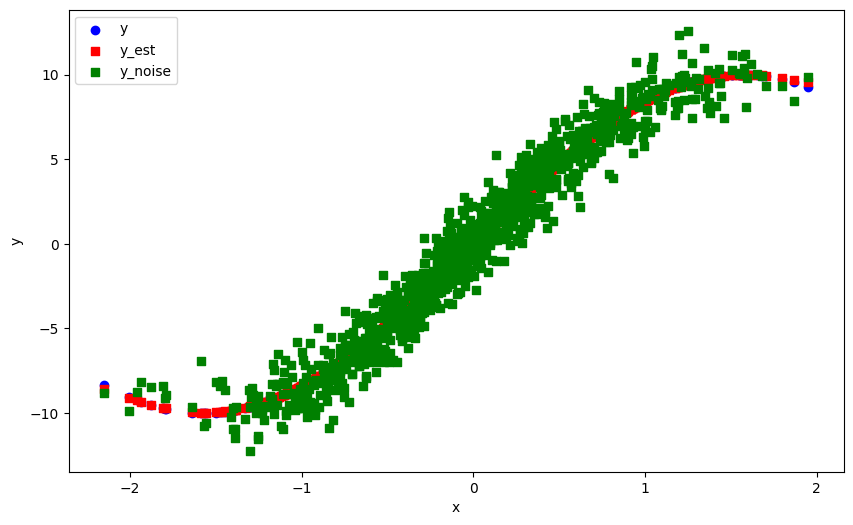

The programm is closed


In [19]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 0], X.detach().numpy()[:, 1], label='y', color='blue', marker='o')  # Plot x vs. y1
plt.scatter(X.detach().numpy()[:, 0], x_est.detach().numpy()[:, 1], label='y_est', color='red', marker='s') 
plt.scatter(X.detach().numpy()[:, 0], X_true.detach().numpy()[:, 1], label='y_noise', color='green', marker='s') 
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

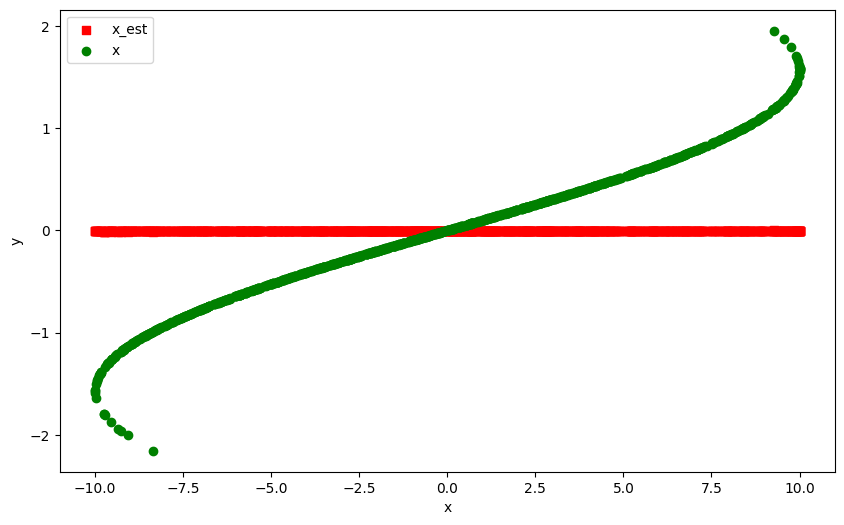

The programm is closed


In [20]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 1], x_est.detach().numpy()[:, 0], label='x_est', color='red', marker='s') 
plt.scatter(X.detach().numpy()[:, 1], X.detach().numpy()[:, 0], label='x', color='green', marker='o')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

## no causal

In [26]:
np.random.seed(0)
n_samples = 1000  # Number of samples
dim = 2  # Dimension of the normal vectors
d = 2
# Random data for X and X_hat
True_Sigma = np.array([[1, 0.6],    # Variance of X is 1, covariance between X and Y is 0.8
                [0.6, 1.5]])   # Variance of Y is 1, covariance between Y and X is 0.8
epsilon = np.random.multivariate_normal([0] * dim, True_Sigma, size=n_samples) #[n, d]
epsilon = torch.tensor(epsilon, dtype=torch.float64)
x1 = epsilon[:, 0]
# x1 = torch.randn(n_samples)
x1_true = epsilon[:, 0]
x2 = epsilon[:, 1]
# Step 4: Combine these results into a new tensor of shape [n, 2]
X = torch.stack((x1, x2), dim=1)
x2_true = epsilon[:, 1]
X_true = torch.stack((x1_true, x2_true), dim=1)

In [27]:
# eq_model = nonlinear.DagmaMLP(
#     dims=[d, 10, 1], bias=True, dtype=torch.double)
# model = nonlinear.DagmaNonlinear(
#     eq_model, dtype=torch.double, use_mse_loss=True)

# W_est_dagma = model.fit(X, lambda1=2e-2, lambda2=0.005,
#                         T=1, lr=2e-4, w_threshold=0.3, mu_init=0.1, warm_iter=70000, max_iter=80000)

# # Use DAGMA weights as initial weights for DAGMA-DCE
# fc1_weight = eq_model.fc1.weight
# fc1_bias = eq_model.fc1.bias
# fc2_weight = eq_model.fc2[0].weight
# fc2_bias = eq_model.fc2[0].bias

eq_model = nonlinear_dce.DagmaMLP_DCE(
    dims=[d, 10, 1], bias=True)
model = nonlinear_dce.DagmaDCE(eq_model, use_mle_loss=True)
# eq_model.fc1.weight = fc1_weight
# eq_model.fc1.bias = fc1_bias
# eq_model.fc2[0].weight = fc2_weight
# eq_model.fc2[0].bias = fc2_bias

W_est_dce_no_thresh, W2, x_est = model.fit(X, lambda1=3.5e-2, lambda2=5e-3,
                                lr=2e-4, mu_factor=0.1, mu_init=1, T=4, warm_iter=7000, max_iter=8000)

  0%|          | 140/29000 [00:00<01:18, 368.33it/s]

Sigma:  tensor([[0.9609, 0.0195],
        [0.0195, 1.0409]], grad_fn=<MmBackward0>)
obj:  tensor(2.2971, grad_fn=<AddBackward0>)
mle loss:  tensor(2.2961, grad_fn=<AddBackward0>)
h_val:  tensor(9.5803e-05, grad_fn=<AddBackward0>)


  1%|          | 262/29000 [00:00<01:13, 389.99it/s]

Sigma:  tensor([[0.9242, 0.0380],
        [0.0380, 1.0820]], grad_fn=<MmBackward0>)
obj:  tensor(2.2143, grad_fn=<AddBackward0>)
mle loss:  tensor(2.2118, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


  1%|          | 342/29000 [00:00<01:13, 392.28it/s]

Sigma:  tensor([[0.8895, 0.0553],
        [0.0553, 1.1208]], grad_fn=<MmBackward0>)
obj:  tensor(2.1278, grad_fn=<AddBackward0>)
mle loss:  tensor(2.1231, grad_fn=<AddBackward0>)
h_val:  tensor(0.0013, grad_fn=<AddBackward0>)


  2%|▏         | 465/29000 [00:01<01:11, 398.98it/s]

Sigma:  tensor([[0.8555, 0.0709],
        [0.0709, 1.1541]], grad_fn=<MmBackward0>)
obj:  tensor(2.0347, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0266, grad_fn=<AddBackward0>)
h_val:  tensor(0.0029, grad_fn=<AddBackward0>)


  2%|▏         | 547/29000 [00:01<01:11, 399.07it/s]

Sigma:  tensor([[0.8203, 0.0847],
        [0.0847, 1.1782]], grad_fn=<MmBackward0>)
obj:  tensor(1.9334, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9201, grad_fn=<AddBackward0>)
h_val:  tensor(0.0059, grad_fn=<AddBackward0>)


  2%|▏         | 671/29000 [00:01<01:10, 402.18it/s]

Sigma:  tensor([[0.7832, 0.0963],
        [0.0963, 1.1900]], grad_fn=<MmBackward0>)
obj:  tensor(1.8232, grad_fn=<AddBackward0>)
mle loss:  tensor(1.8024, grad_fn=<AddBackward0>)
h_val:  tensor(0.0108, grad_fn=<AddBackward0>)


  3%|▎         | 755/29000 [00:01<01:09, 407.43it/s]

Sigma:  tensor([[0.7445, 0.1055],
        [0.1055, 1.1874]], grad_fn=<MmBackward0>)
obj:  tensor(1.7046, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6731, grad_fn=<AddBackward0>)
h_val:  tensor(0.0185, grad_fn=<AddBackward0>)


  3%|▎         | 884/29000 [00:02<01:07, 418.72it/s]

Sigma:  tensor([[0.7053, 0.1120],
        [0.1120, 1.1705]], grad_fn=<MmBackward0>)
obj:  tensor(1.5789, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5329, grad_fn=<AddBackward0>)
h_val:  tensor(0.0296, grad_fn=<AddBackward0>)


  3%|▎         | 969/29000 [00:02<01:07, 417.41it/s]

Sigma:  tensor([[0.6664, 0.1156],
        [0.1156, 1.1417]], grad_fn=<MmBackward0>)
obj:  tensor(1.4483, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3833, grad_fn=<AddBackward0>)
h_val:  tensor(0.0452, grad_fn=<AddBackward0>)


  4%|▎         | 1055/29000 [00:02<01:06, 419.62it/s]

Sigma:  tensor([[0.6287, 0.1159],
        [0.1159, 1.1041]], grad_fn=<MmBackward0>)
obj:  tensor(1.3156, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2260, grad_fn=<AddBackward0>)
h_val:  tensor(0.0660, grad_fn=<AddBackward0>)


  4%|▍         | 1185/29000 [00:02<01:05, 422.26it/s]

Sigma:  tensor([[0.5925, 0.1129],
        [0.1129, 1.0605]], grad_fn=<MmBackward0>)
obj:  tensor(1.1824, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0624, grad_fn=<AddBackward0>)
h_val:  tensor(0.0926, grad_fn=<AddBackward0>)


  4%|▍         | 1271/29000 [00:03<01:05, 420.82it/s]

Sigma:  tensor([[0.5582, 0.1062],
        [0.1062, 1.0131]], grad_fn=<MmBackward0>)
obj:  tensor(1.0495, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8925, grad_fn=<AddBackward0>)
h_val:  tensor(0.1258, grad_fn=<AddBackward0>)


  5%|▍         | 1357/29000 [00:03<01:06, 418.14it/s]

Sigma:  tensor([[0.5258, 0.0964],
        [0.0964, 0.9634]], grad_fn=<MmBackward0>)
obj:  tensor(0.9162, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7154, grad_fn=<AddBackward0>)
h_val:  tensor(0.1662, grad_fn=<AddBackward0>)


  5%|▍         | 1442/29000 [00:03<01:05, 418.30it/s]

Sigma:  tensor([[0.4952, 0.0841],
        [0.0841, 0.9126]], grad_fn=<MmBackward0>)
obj:  tensor(0.7820, grad_fn=<AddBackward0>)
mle loss:  tensor(0.5301, grad_fn=<AddBackward0>)
h_val:  tensor(0.2140, grad_fn=<AddBackward0>)


  5%|▌         | 1573/29000 [00:03<01:05, 421.75it/s]

Sigma:  tensor([[0.4664, 0.0703],
        [0.0703, 0.8620]], grad_fn=<MmBackward0>)
obj:  tensor(0.6480, grad_fn=<AddBackward0>)
mle loss:  tensor(0.3374, grad_fn=<AddBackward0>)
h_val:  tensor(0.2698, grad_fn=<AddBackward0>)


  6%|▌         | 1660/29000 [00:04<01:04, 421.92it/s]

Sigma:  tensor([[0.4392, 0.0560],
        [0.0560, 0.8126]], grad_fn=<MmBackward0>)
obj:  tensor(0.5166, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1398, grad_fn=<AddBackward0>)
h_val:  tensor(0.3335, grad_fn=<AddBackward0>)


  6%|▌         | 1745/29000 [00:04<01:05, 417.70it/s]

Sigma:  tensor([[0.4135, 0.0418],
        [0.0418, 0.7653]], grad_fn=<MmBackward0>)
obj:  tensor(0.3912, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0591, grad_fn=<AddBackward0>)
h_val:  tensor(0.4045, grad_fn=<AddBackward0>)


  6%|▋         | 1876/29000 [00:04<01:04, 420.52it/s]

Sigma:  tensor([[0.3893, 0.0283],
        [0.0283, 0.7207]], grad_fn=<MmBackward0>)
obj:  tensor(0.2742, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.2548, grad_fn=<AddBackward0>)
h_val:  tensor(0.4811, grad_fn=<AddBackward0>)


  7%|▋         | 1962/29000 [00:04<01:04, 418.44it/s]

Sigma:  tensor([[0.3666, 0.0157],
        [0.0157, 0.6792]], grad_fn=<MmBackward0>)
obj:  tensor(0.1673, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.4424, grad_fn=<AddBackward0>)
h_val:  tensor(0.5601, grad_fn=<AddBackward0>)


  7%|▋         | 2046/29000 [00:05<01:05, 413.03it/s]

Sigma:  tensor([[0.3455, 0.0039],
        [0.0039, 0.6409]], grad_fn=<MmBackward0>)
obj:  tensor(0.0704, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.6174, grad_fn=<AddBackward0>)
h_val:  tensor(0.6365, grad_fn=<AddBackward0>)


  8%|▊         | 2175/29000 [00:05<01:03, 422.89it/s]

Sigma:  tensor([[ 0.3260, -0.0071],
        [-0.0071,  0.6058]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0181, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7760, grad_fn=<AddBackward0>)
h_val:  tensor(0.7052, grad_fn=<AddBackward0>)


  8%|▊         | 2261/29000 [00:05<01:05, 409.14it/s]

Sigma:  tensor([[ 0.3080, -0.0174],
        [-0.0174,  0.5739]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1008, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9168, grad_fn=<AddBackward0>)
h_val:  tensor(0.7623, grad_fn=<AddBackward0>)


  8%|▊         | 2345/29000 [00:05<01:04, 410.92it/s]

Sigma:  tensor([[ 0.2915, -0.0272],
        [-0.0272,  0.5450]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1796, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0413, grad_fn=<AddBackward0>)
h_val:  tensor(0.8070, grad_fn=<AddBackward0>)


  9%|▊         | 2475/29000 [00:06<01:02, 422.71it/s]

Sigma:  tensor([[ 0.2764, -0.0368],
        [-0.0368,  0.5191]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2561, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.1534, grad_fn=<AddBackward0>)
h_val:  tensor(0.8419, grad_fn=<AddBackward0>)


  9%|▉         | 2561/29000 [00:06<01:03, 413.88it/s]

Sigma:  tensor([[ 0.2625, -0.0462],
        [-0.0462,  0.4962]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3311, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.2579, grad_fn=<AddBackward0>)
h_val:  tensor(0.8705, grad_fn=<AddBackward0>)


  9%|▉         | 2646/29000 [00:06<01:03, 415.96it/s]

Sigma:  tensor([[ 0.2498, -0.0555],
        [-0.0555,  0.4761]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4055, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.3584, grad_fn=<AddBackward0>)
h_val:  tensor(0.8957, grad_fn=<AddBackward0>)


 10%|▉         | 2779/29000 [00:06<01:01, 424.44it/s]

Sigma:  tensor([[ 0.2381, -0.0648],
        [-0.0648,  0.4587]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4798, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.4568, grad_fn=<AddBackward0>)
h_val:  tensor(0.9190, grad_fn=<AddBackward0>)


 10%|▉         | 2864/29000 [00:06<01:02, 418.64it/s]

Sigma:  tensor([[ 0.2271, -0.0741],
        [-0.0741,  0.4440]], grad_fn=<MmBackward0>)
obj:  tensor(-0.5542, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5536, grad_fn=<AddBackward0>)
h_val:  tensor(0.9405, grad_fn=<AddBackward0>)


 10%|█         | 2949/29000 [00:07<01:02, 417.07it/s]

Sigma:  tensor([[ 0.2169, -0.0833],
        [-0.0833,  0.4319]], grad_fn=<MmBackward0>)
obj:  tensor(-0.6291, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.6488, grad_fn=<AddBackward0>)
h_val:  tensor(0.9600, grad_fn=<AddBackward0>)


 11%|█         | 3080/29000 [00:07<01:01, 422.17it/s]

Sigma:  tensor([[ 0.2073, -0.0922],
        [-0.0922,  0.4222]], grad_fn=<MmBackward0>)
obj:  tensor(-0.7045, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.7426, grad_fn=<AddBackward0>)
h_val:  tensor(0.9776, grad_fn=<AddBackward0>)


 11%|█         | 3165/29000 [00:07<01:01, 417.32it/s]

Sigma:  tensor([[ 0.1982, -0.1010],
        [-0.1010,  0.4148]], grad_fn=<MmBackward0>)
obj:  tensor(-0.7806, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8353, grad_fn=<AddBackward0>)
h_val:  tensor(0.9935, grad_fn=<AddBackward0>)


 11%|█         | 3249/29000 [00:07<01:02, 413.98it/s]

Sigma:  tensor([[ 0.1897, -0.1093],
        [-0.1093,  0.4096]], grad_fn=<MmBackward0>)
obj:  tensor(-0.8573, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9272, grad_fn=<AddBackward0>)
h_val:  tensor(1.0079, grad_fn=<AddBackward0>)


 12%|█▏        | 3380/29000 [00:08<01:00, 425.72it/s]

Sigma:  tensor([[ 0.1816, -0.1173],
        [-0.1173,  0.4065]], grad_fn=<MmBackward0>)
obj:  tensor(-0.9347, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0183, grad_fn=<AddBackward0>)
h_val:  tensor(1.0211, grad_fn=<AddBackward0>)


 12%|█▏        | 3460/29000 [00:08<01:26, 293.94it/s]

Sigma:  tensor([[ 0.1739, -0.1250],
        [-0.1250,  0.4053]], grad_fn=<MmBackward0>)
obj:  tensor(-1.0125, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1088, grad_fn=<AddBackward0>)
h_val:  tensor(1.0331, grad_fn=<AddBackward0>)


 12%|█▏        | 3537/29000 [00:08<01:17, 327.61it/s]

Sigma:  tensor([[ 0.1667, -0.1321],
        [-0.1321,  0.4058]], grad_fn=<MmBackward0>)
obj:  tensor(-1.0907, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1986, grad_fn=<AddBackward0>)
h_val:  tensor(1.0441, grad_fn=<AddBackward0>)


 13%|█▎        | 3647/29000 [00:09<01:14, 338.74it/s]

Sigma:  tensor([[ 0.1598, -0.1389],
        [-0.1389,  0.4081]], grad_fn=<MmBackward0>)
obj:  tensor(-1.1692, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2879, grad_fn=<AddBackward0>)
h_val:  tensor(1.0543, grad_fn=<AddBackward0>)


 13%|█▎        | 3755/29000 [00:09<01:13, 344.78it/s]

Sigma:  tensor([[ 0.1532, -0.1452],
        [-0.1452,  0.4119]], grad_fn=<MmBackward0>)
obj:  tensor(-1.2478, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.3767, grad_fn=<AddBackward0>)
h_val:  tensor(1.0640, grad_fn=<AddBackward0>)


 13%|█▎        | 3865/29000 [00:09<01:10, 355.68it/s]

Sigma:  tensor([[ 0.1470, -0.1510],
        [-0.1510,  0.4172]], grad_fn=<MmBackward0>)
obj:  tensor(-1.3264, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4649, grad_fn=<AddBackward0>)
h_val:  tensor(1.0731, grad_fn=<AddBackward0>)


 14%|█▎        | 3938/29000 [00:09<01:11, 352.86it/s]

Sigma:  tensor([[ 0.1410, -0.1564],
        [-0.1564,  0.4237]], grad_fn=<MmBackward0>)
obj:  tensor(-1.4049, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.5526, grad_fn=<AddBackward0>)
h_val:  tensor(1.0818, grad_fn=<AddBackward0>)


 14%|█▍        | 4049/29000 [00:10<01:10, 355.98it/s]

Sigma:  tensor([[ 0.1353, -0.1614],
        [-0.1614,  0.4314]], grad_fn=<MmBackward0>)
obj:  tensor(-1.4831, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6397, grad_fn=<AddBackward0>)
h_val:  tensor(1.0902, grad_fn=<AddBackward0>)


 14%|█▍        | 4157/29000 [00:10<01:11, 347.69it/s]

Sigma:  tensor([[ 0.1299, -0.1659],
        [-0.1659,  0.4402]], grad_fn=<MmBackward0>)
obj:  tensor(-1.5612, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7263, grad_fn=<AddBackward0>)
h_val:  tensor(1.0983, grad_fn=<AddBackward0>)


 15%|█▍        | 4266/29000 [00:10<01:09, 357.96it/s]

Sigma:  tensor([[ 0.1247, -0.1700],
        [-0.1700,  0.4500]], grad_fn=<MmBackward0>)
obj:  tensor(-1.6388, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.8124, grad_fn=<AddBackward0>)
h_val:  tensor(1.1063, grad_fn=<AddBackward0>)


 15%|█▍        | 4338/29000 [00:11<01:10, 350.49it/s]

Sigma:  tensor([[ 0.1198, -0.1738],
        [-0.1738,  0.4607]], grad_fn=<MmBackward0>)
obj:  tensor(-1.7162, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.8979, grad_fn=<AddBackward0>)
h_val:  tensor(1.1142, grad_fn=<AddBackward0>)


 15%|█▌        | 4448/29000 [00:11<01:09, 354.25it/s]

Sigma:  tensor([[ 0.1151, -0.1772],
        [-0.1772,  0.4722]], grad_fn=<MmBackward0>)
obj:  tensor(-1.7932, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.9831, grad_fn=<AddBackward0>)
h_val:  tensor(1.1219, grad_fn=<AddBackward0>)


 16%|█▌        | 4559/29000 [00:11<01:08, 355.45it/s]

Sigma:  tensor([[ 0.1106, -0.1802],
        [-0.1802,  0.4844]], grad_fn=<MmBackward0>)
obj:  tensor(-1.8698, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.0678, grad_fn=<AddBackward0>)
h_val:  tensor(1.1296, grad_fn=<AddBackward0>)


 16%|█▌        | 4668/29000 [00:12<01:08, 357.36it/s]

Sigma:  tensor([[ 0.1063, -0.1829],
        [-0.1829,  0.4973]], grad_fn=<MmBackward0>)
obj:  tensor(-1.9460, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1521, grad_fn=<AddBackward0>)
h_val:  tensor(1.1374, grad_fn=<AddBackward0>)


 16%|█▋        | 4739/29000 [00:12<01:09, 348.00it/s]

Sigma:  tensor([[ 0.1021, -0.1853],
        [-0.1853,  0.5108]], grad_fn=<MmBackward0>)
obj:  tensor(-2.0219, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.2361, grad_fn=<AddBackward0>)
h_val:  tensor(1.1451, grad_fn=<AddBackward0>)


 17%|█▋        | 4850/29000 [00:12<01:07, 357.17it/s]

Sigma:  tensor([[ 0.0982, -0.1874],
        [-0.1874,  0.5249]], grad_fn=<MmBackward0>)
obj:  tensor(-2.0975, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.3197, grad_fn=<AddBackward0>)
h_val:  tensor(1.1530, grad_fn=<AddBackward0>)


 17%|█▋        | 4959/29000 [00:12<01:08, 353.09it/s]

Sigma:  tensor([[ 0.0944, -0.1893],
        [-0.1893,  0.5395]], grad_fn=<MmBackward0>)
obj:  tensor(-2.1726, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.4032, grad_fn=<AddBackward0>)
h_val:  tensor(1.1610, grad_fn=<AddBackward0>)


 17%|█▋        | 5068/29000 [00:13<01:07, 353.37it/s]

Sigma:  tensor([[ 0.0908, -0.1909],
        [-0.1909,  0.5546]], grad_fn=<MmBackward0>)
obj:  tensor(-2.2473, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.4864, grad_fn=<AddBackward0>)
h_val:  tensor(1.1692, grad_fn=<AddBackward0>)


 18%|█▊        | 5140/29000 [00:13<01:07, 355.33it/s]

Sigma:  tensor([[ 0.0873, -0.1923],
        [-0.1923,  0.5702]], grad_fn=<MmBackward0>)
obj:  tensor(-2.3217, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.5694, grad_fn=<AddBackward0>)
h_val:  tensor(1.1776, grad_fn=<AddBackward0>)


 18%|█▊        | 5253/29000 [00:13<01:06, 356.93it/s]

Sigma:  tensor([[ 0.0840, -0.1934],
        [-0.1934,  0.5861]], grad_fn=<MmBackward0>)
obj:  tensor(-2.3956, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6522, grad_fn=<AddBackward0>)
h_val:  tensor(1.1862, grad_fn=<AddBackward0>)


 18%|█▊        | 5362/29000 [00:13<01:07, 352.73it/s]

Sigma:  tensor([[ 0.0808, -0.1944],
        [-0.1944,  0.6025]], grad_fn=<MmBackward0>)
obj:  tensor(-2.4690, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7348, grad_fn=<AddBackward0>)
h_val:  tensor(1.1951, grad_fn=<AddBackward0>)


 19%|█▉        | 5471/29000 [00:14<01:06, 355.37it/s]

Sigma:  tensor([[ 0.0777, -0.1952],
        [-0.1952,  0.6192]], grad_fn=<MmBackward0>)
obj:  tensor(-2.5420, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8172, grad_fn=<AddBackward0>)
h_val:  tensor(1.2043, grad_fn=<AddBackward0>)


 19%|█▉        | 5542/29000 [00:14<01:08, 342.84it/s]

Sigma:  tensor([[ 0.0747, -0.1957],
        [-0.1957,  0.6363]], grad_fn=<MmBackward0>)
obj:  tensor(-2.6144, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8993, grad_fn=<AddBackward0>)
h_val:  tensor(1.2138, grad_fn=<AddBackward0>)


 19%|█▉        | 5651/29000 [00:14<01:05, 354.56it/s]

Sigma:  tensor([[ 0.0719, -0.1962],
        [-0.1962,  0.6536]], grad_fn=<MmBackward0>)
obj:  tensor(-2.6862, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.9812, grad_fn=<AddBackward0>)
h_val:  tensor(1.2235, grad_fn=<AddBackward0>)


 20%|█▉        | 5761/29000 [00:15<01:04, 358.68it/s]

Sigma:  tensor([[ 0.0692, -0.1964],
        [-0.1964,  0.6712]], grad_fn=<MmBackward0>)
obj:  tensor(-2.7576, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.0628, grad_fn=<AddBackward0>)
h_val:  tensor(1.2336, grad_fn=<AddBackward0>)


 20%|██        | 5877/29000 [00:15<01:01, 375.46it/s]

Sigma:  tensor([[ 0.0666, -0.1965],
        [-0.1965,  0.6890]], grad_fn=<MmBackward0>)
obj:  tensor(-2.8284, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.1442, grad_fn=<AddBackward0>)
h_val:  tensor(1.2440, grad_fn=<AddBackward0>)


 21%|██        | 5954/29000 [00:15<01:01, 372.20it/s]

Sigma:  tensor([[ 0.0641, -0.1965],
        [-0.1965,  0.7070]], grad_fn=<MmBackward0>)
obj:  tensor(-2.8987, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.2254, grad_fn=<AddBackward0>)
h_val:  tensor(1.2546, grad_fn=<AddBackward0>)


 21%|██        | 6075/29000 [00:15<00:59, 388.15it/s]

Sigma:  tensor([[ 0.0616, -0.1963],
        [-0.1963,  0.7251]], grad_fn=<MmBackward0>)
obj:  tensor(-2.9684, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3063, grad_fn=<AddBackward0>)
h_val:  tensor(1.2656, grad_fn=<AddBackward0>)


 21%|██        | 6156/29000 [00:16<00:57, 394.64it/s]

Sigma:  tensor([[ 0.0593, -0.1959],
        [-0.1959,  0.7434]], grad_fn=<MmBackward0>)
obj:  tensor(-3.0377, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3869, grad_fn=<AddBackward0>)
h_val:  tensor(1.2768, grad_fn=<AddBackward0>)


 22%|██▏       | 6235/29000 [00:16<01:01, 372.57it/s]

Sigma:  tensor([[ 0.0571, -0.1955],
        [-0.1955,  0.7617]], grad_fn=<MmBackward0>)
obj:  tensor(-3.1065, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4673, grad_fn=<AddBackward0>)
h_val:  tensor(1.2882, grad_fn=<AddBackward0>)


 22%|██▏       | 6353/29000 [00:16<00:58, 386.14it/s]

Sigma:  tensor([[ 0.0549, -0.1949],
        [-0.1949,  0.7801]], grad_fn=<MmBackward0>)
obj:  tensor(-3.1748, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5476, grad_fn=<AddBackward0>)
h_val:  tensor(1.2999, grad_fn=<AddBackward0>)


 22%|██▏       | 6479/29000 [00:16<00:55, 406.56it/s]

Sigma:  tensor([[ 0.0529, -0.1943],
        [-0.1943,  0.7986]], grad_fn=<MmBackward0>)
obj:  tensor(-3.2428, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.6276, grad_fn=<AddBackward0>)
h_val:  tensor(1.3118, grad_fn=<AddBackward0>)


 23%|██▎       | 6561/29000 [00:17<00:55, 402.60it/s]

Sigma:  tensor([[ 0.0509, -0.1935],
        [-0.1935,  0.8170]], grad_fn=<MmBackward0>)
obj:  tensor(-3.3103, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7074, grad_fn=<AddBackward0>)
h_val:  tensor(1.3239, grad_fn=<AddBackward0>)


 23%|██▎       | 6643/29000 [00:17<00:55, 402.45it/s]

Sigma:  tensor([[ 0.0490, -0.1926],
        [-0.1926,  0.8354]], grad_fn=<MmBackward0>)
obj:  tensor(-3.3775, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7871, grad_fn=<AddBackward0>)
h_val:  tensor(1.3362, grad_fn=<AddBackward0>)


 23%|██▎       | 6773/29000 [00:17<00:55, 402.97it/s]

Sigma:  tensor([[ 0.0472, -0.1916],
        [-0.1916,  0.8538]], grad_fn=<MmBackward0>)
obj:  tensor(-3.4444, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8668, grad_fn=<AddBackward0>)
h_val:  tensor(1.3488, grad_fn=<AddBackward0>)


 24%|██▎       | 6855/29000 [00:17<00:55, 400.81it/s]

Sigma:  tensor([[ 0.0454, -0.1906],
        [-0.1906,  0.8722]], grad_fn=<MmBackward0>)
obj:  tensor(-3.5111, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9463, grad_fn=<AddBackward0>)
h_val:  tensor(1.3615, grad_fn=<AddBackward0>)


 24%|██▍       | 6980/29000 [00:18<00:53, 408.83it/s]

Sigma:  tensor([[ 0.0437, -0.1894],
        [-0.1894,  0.8905]], grad_fn=<MmBackward0>)
obj:  tensor(-3.5774, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0258, grad_fn=<AddBackward0>)
h_val:  tensor(1.3744, grad_fn=<AddBackward0>)


 25%|██▍       | 7148/29000 [00:18<00:52, 416.37it/s]

Sigma:  tensor([[ 0.0417, -0.1848],
        [-0.1848,  0.8835]], grad_fn=<MmBackward0>)
obj:  tensor(0.6937, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.1303, grad_fn=<AddBackward0>)
h_val:  tensor(1.0995, grad_fn=<AddBackward0>)


 25%|██▌       | 7274/29000 [00:18<00:53, 403.59it/s]

Sigma:  tensor([[ 0.0433, -0.1839],
        [-0.1839,  0.8453]], grad_fn=<MmBackward0>)
obj:  tensor(0.6118, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.5327, grad_fn=<AddBackward0>)
h_val:  tensor(0.9579, grad_fn=<AddBackward0>)


 25%|██▌       | 7354/29000 [00:19<00:58, 371.01it/s]

Sigma:  tensor([[ 0.0452, -0.1833],
        [-0.1833,  0.8067]], grad_fn=<MmBackward0>)
obj:  tensor(0.5411, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8551, grad_fn=<AddBackward0>)
h_val:  tensor(0.9193, grad_fn=<AddBackward0>)


 26%|██▌       | 7467/29000 [00:19<00:59, 361.96it/s]

Sigma:  tensor([[ 0.0469, -0.1825],
        [-0.1825,  0.7721]], grad_fn=<MmBackward0>)
obj:  tensor(0.4905, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8921, grad_fn=<AddBackward0>)
h_val:  tensor(0.8723, grad_fn=<AddBackward0>)


 26%|██▌       | 7540/29000 [00:19<01:00, 355.44it/s]

Sigma:  tensor([[ 0.0485, -0.1818],
        [-0.1818,  0.7416]], grad_fn=<MmBackward0>)
obj:  tensor(0.4492, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6901, grad_fn=<AddBackward0>)
h_val:  tensor(0.8108, grad_fn=<AddBackward0>)


 26%|██▋       | 7657/29000 [00:20<00:59, 360.73it/s]

Sigma:  tensor([[ 0.0501, -0.1811],
        [-0.1811,  0.7121]], grad_fn=<MmBackward0>)
obj:  tensor(0.4180, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.5602, grad_fn=<AddBackward0>)
h_val:  tensor(0.7666, grad_fn=<AddBackward0>)


 27%|██▋       | 7767/29000 [00:20<00:59, 357.01it/s]

Sigma:  tensor([[ 0.0518, -0.1803],
        [-0.1803,  0.6838]], grad_fn=<MmBackward0>)
obj:  tensor(0.3942, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.5006, grad_fn=<AddBackward0>)
h_val:  tensor(0.7366, grad_fn=<AddBackward0>)


 27%|██▋       | 7839/29000 [00:20<01:00, 351.43it/s]

Sigma:  tensor([[ 0.0534, -0.1796],
        [-0.1796,  0.6582]], grad_fn=<MmBackward0>)
obj:  tensor(0.3755, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.4126, grad_fn=<AddBackward0>)
h_val:  tensor(0.7091, grad_fn=<AddBackward0>)


 27%|██▋       | 7949/29000 [00:20<00:59, 356.58it/s]

Sigma:  tensor([[ 0.0549, -0.1790],
        [-0.1790,  0.6349]], grad_fn=<MmBackward0>)
obj:  tensor(0.3605, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.3247, grad_fn=<AddBackward0>)
h_val:  tensor(0.6852, grad_fn=<AddBackward0>)


 28%|██▊       | 8062/29000 [00:21<00:56, 369.11it/s]

Sigma:  tensor([[ 0.0565, -0.1785],
        [-0.1785,  0.6130]], grad_fn=<MmBackward0>)
obj:  tensor(0.3482, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.2671, grad_fn=<AddBackward0>)
h_val:  tensor(0.6671, grad_fn=<AddBackward0>)


 28%|██▊       | 8135/29000 [00:21<00:59, 349.96it/s]

Sigma:  tensor([[ 0.0581, -0.1780],
        [-0.1780,  0.5927]], grad_fn=<MmBackward0>)
obj:  tensor(0.3380, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.2197, grad_fn=<AddBackward0>)
h_val:  tensor(0.6521, grad_fn=<AddBackward0>)


 28%|██▊       | 8246/29000 [00:21<00:58, 356.02it/s]

Sigma:  tensor([[ 0.0598, -0.1777],
        [-0.1777,  0.5738]], grad_fn=<MmBackward0>)
obj:  tensor(0.3290, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1801, grad_fn=<AddBackward0>)
h_val:  tensor(0.6391, grad_fn=<AddBackward0>)


 29%|██▉       | 8358/29000 [00:22<00:56, 362.84it/s]

Sigma:  tensor([[ 0.0614, -0.1775],
        [-0.1775,  0.5560]], grad_fn=<MmBackward0>)
obj:  tensor(0.3207, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1570, grad_fn=<AddBackward0>)
h_val:  tensor(0.6286, grad_fn=<AddBackward0>)


 29%|██▉       | 8468/29000 [00:22<00:57, 354.06it/s]

Sigma:  tensor([[ 0.0632, -0.1773],
        [-0.1773,  0.5394]], grad_fn=<MmBackward0>)
obj:  tensor(0.3129, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1464, grad_fn=<AddBackward0>)
h_val:  tensor(0.6197, grad_fn=<AddBackward0>)


 29%|██▉       | 8540/29000 [00:22<00:58, 348.40it/s]

Sigma:  tensor([[ 0.0650, -0.1773],
        [-0.1773,  0.5236]], grad_fn=<MmBackward0>)
obj:  tensor(0.3053, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1467, grad_fn=<AddBackward0>)
h_val:  tensor(0.6122, grad_fn=<AddBackward0>)


 30%|██▉       | 8653/29000 [00:22<00:56, 362.12it/s]

Sigma:  tensor([[ 0.0669, -0.1773],
        [-0.1773,  0.5087]], grad_fn=<MmBackward0>)
obj:  tensor(0.2979, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1570, grad_fn=<AddBackward0>)
h_val:  tensor(0.6058, grad_fn=<AddBackward0>)


 30%|███       | 8763/29000 [00:23<00:57, 352.79it/s]

Sigma:  tensor([[ 0.0688, -0.1775],
        [-0.1775,  0.4945]], grad_fn=<MmBackward0>)
obj:  tensor(0.2907, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1729, grad_fn=<AddBackward0>)
h_val:  tensor(0.6003, grad_fn=<AddBackward0>)


 31%|███       | 8871/29000 [00:23<00:57, 350.85it/s]

Sigma:  tensor([[ 0.0709, -0.1777],
        [-0.1777,  0.4810]], grad_fn=<MmBackward0>)
obj:  tensor(0.2837, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1920, grad_fn=<AddBackward0>)
h_val:  tensor(0.5952, grad_fn=<AddBackward0>)


 31%|███       | 8907/29000 [00:23<00:57, 349.66it/s]

Sigma:  tensor([[ 0.0730, -0.1780],
        [-0.1780,  0.4681]], grad_fn=<MmBackward0>)
obj:  tensor(0.2768, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.2124, grad_fn=<AddBackward0>)
h_val:  tensor(0.5905, grad_fn=<AddBackward0>)


 31%|███       | 9053/29000 [00:24<01:05, 303.43it/s]

Sigma:  tensor([[ 0.0752, -0.1784],
        [-0.1784,  0.4558]], grad_fn=<MmBackward0>)
obj:  tensor(0.2702, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.2331, grad_fn=<AddBackward0>)
h_val:  tensor(0.5860, grad_fn=<AddBackward0>)


 32%|███▏      | 9160/29000 [00:24<00:59, 333.92it/s]

Sigma:  tensor([[ 0.0775, -0.1788],
        [-0.1788,  0.4442]], grad_fn=<MmBackward0>)
obj:  tensor(0.2639, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.2541, grad_fn=<AddBackward0>)
h_val:  tensor(0.5818, grad_fn=<AddBackward0>)


 32%|███▏      | 9266/29000 [00:24<00:58, 339.22it/s]

Sigma:  tensor([[ 0.0798, -0.1794],
        [-0.1794,  0.4333]], grad_fn=<MmBackward0>)
obj:  tensor(0.2577, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.2754, grad_fn=<AddBackward0>)
h_val:  tensor(0.5778, grad_fn=<AddBackward0>)


 32%|███▏      | 9336/29000 [00:24<00:57, 341.13it/s]

Sigma:  tensor([[ 0.0822, -0.1800],
        [-0.1800,  0.4231]], grad_fn=<MmBackward0>)
obj:  tensor(0.2518, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.2974, grad_fn=<AddBackward0>)
h_val:  tensor(0.5741, grad_fn=<AddBackward0>)


 33%|███▎      | 9448/29000 [00:25<00:54, 359.98it/s]

Sigma:  tensor([[ 0.0847, -0.1808],
        [-0.1808,  0.4137]], grad_fn=<MmBackward0>)
obj:  tensor(0.2461, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.3202, grad_fn=<AddBackward0>)
h_val:  tensor(0.5707, grad_fn=<AddBackward0>)


 33%|███▎      | 9569/29000 [00:25<00:50, 387.18it/s]

Sigma:  tensor([[ 0.0873, -0.1817],
        [-0.1817,  0.4050]], grad_fn=<MmBackward0>)
obj:  tensor(0.2406, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.3441, grad_fn=<AddBackward0>)
h_val:  tensor(0.5676, grad_fn=<AddBackward0>)


 33%|███▎      | 9645/29000 [00:25<00:53, 362.67it/s]

Sigma:  tensor([[ 0.0899, -0.1827],
        [-0.1827,  0.3971]], grad_fn=<MmBackward0>)
obj:  tensor(0.2352, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.3693, grad_fn=<AddBackward0>)
h_val:  tensor(0.5648, grad_fn=<AddBackward0>)


 34%|███▎      | 9756/29000 [00:26<00:54, 354.18it/s]

Sigma:  tensor([[ 0.0925, -0.1839],
        [-0.1839,  0.3899]], grad_fn=<MmBackward0>)
obj:  tensor(0.2301, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.3960, grad_fn=<AddBackward0>)
h_val:  tensor(0.5624, grad_fn=<AddBackward0>)


 34%|███▍      | 9869/29000 [00:26<00:52, 364.80it/s]

Sigma:  tensor([[ 0.0953, -0.1852],
        [-0.1852,  0.3835]], grad_fn=<MmBackward0>)
obj:  tensor(0.2252, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.4242, grad_fn=<AddBackward0>)
h_val:  tensor(0.5603, grad_fn=<AddBackward0>)


 34%|███▍      | 9948/29000 [00:26<00:50, 379.37it/s]

Sigma:  tensor([[ 0.0980, -0.1866],
        [-0.1866,  0.3778]], grad_fn=<MmBackward0>)
obj:  tensor(0.2204, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.4540, grad_fn=<AddBackward0>)
h_val:  tensor(0.5585, grad_fn=<AddBackward0>)


 35%|███▍      | 10075/29000 [00:26<00:47, 402.25it/s]

Sigma:  tensor([[ 0.1008, -0.1881],
        [-0.1881,  0.3728]], grad_fn=<MmBackward0>)
obj:  tensor(0.2157, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.4852, grad_fn=<AddBackward0>)
h_val:  tensor(0.5570, grad_fn=<AddBackward0>)


 35%|███▌      | 10157/29000 [00:27<00:47, 400.43it/s]

Sigma:  tensor([[ 0.1037, -0.1898],
        [-0.1898,  0.3684]], grad_fn=<MmBackward0>)
obj:  tensor(0.2112, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.5179, grad_fn=<AddBackward0>)
h_val:  tensor(0.5558, grad_fn=<AddBackward0>)


 35%|███▌      | 10237/29000 [00:27<00:51, 364.78it/s]

Sigma:  tensor([[ 0.1065, -0.1916],
        [-0.1916,  0.3646]], grad_fn=<MmBackward0>)
obj:  tensor(0.2068, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.5521, grad_fn=<AddBackward0>)
h_val:  tensor(0.5548, grad_fn=<AddBackward0>)


 36%|███▌      | 10348/29000 [00:27<00:52, 354.72it/s]

Sigma:  tensor([[ 0.1094, -0.1934],
        [-0.1934,  0.3613]], grad_fn=<MmBackward0>)
obj:  tensor(0.2026, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.5875, grad_fn=<AddBackward0>)
h_val:  tensor(0.5541, grad_fn=<AddBackward0>)


 36%|███▌      | 10459/29000 [00:28<00:51, 358.41it/s]

Sigma:  tensor([[ 0.1123, -0.1954],
        [-0.1954,  0.3585]], grad_fn=<MmBackward0>)
obj:  tensor(0.1984, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6241, grad_fn=<AddBackward0>)
h_val:  tensor(0.5537, grad_fn=<AddBackward0>)


 36%|███▋      | 10573/29000 [00:28<00:50, 363.22it/s]

Sigma:  tensor([[ 0.1152, -0.1974],
        [-0.1974,  0.3560]], grad_fn=<MmBackward0>)
obj:  tensor(0.1944, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6618, grad_fn=<AddBackward0>)
h_val:  tensor(0.5534, grad_fn=<AddBackward0>)


 37%|███▋      | 10646/29000 [00:28<00:51, 353.19it/s]

Sigma:  tensor([[ 0.1180, -0.1994],
        [-0.1994,  0.3539]], grad_fn=<MmBackward0>)
obj:  tensor(0.1904, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7004, grad_fn=<AddBackward0>)
h_val:  tensor(0.5533, grad_fn=<AddBackward0>)


 37%|███▋      | 10755/29000 [00:28<00:51, 353.58it/s]

Sigma:  tensor([[ 0.1209, -0.2015],
        [-0.2015,  0.3521]], grad_fn=<MmBackward0>)
obj:  tensor(0.1865, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7398, grad_fn=<AddBackward0>)
h_val:  tensor(0.5534, grad_fn=<AddBackward0>)


 37%|███▋      | 10868/29000 [00:29<00:49, 368.63it/s]

Sigma:  tensor([[ 0.1237, -0.2036],
        [-0.2036,  0.3505]], grad_fn=<MmBackward0>)
obj:  tensor(0.1828, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7799, grad_fn=<AddBackward0>)
h_val:  tensor(0.5536, grad_fn=<AddBackward0>)


 38%|███▊      | 10941/29000 [00:29<00:50, 356.73it/s]

Sigma:  tensor([[ 0.1265, -0.2056],
        [-0.2056,  0.3491]], grad_fn=<MmBackward0>)
obj:  tensor(0.1790, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8206, grad_fn=<AddBackward0>)
h_val:  tensor(0.5540, grad_fn=<AddBackward0>)


 38%|███▊      | 11050/29000 [00:29<00:51, 351.59it/s]

Sigma:  tensor([[ 0.1292, -0.2076],
        [-0.2076,  0.3479]], grad_fn=<MmBackward0>)
obj:  tensor(0.1754, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8618, grad_fn=<AddBackward0>)
h_val:  tensor(0.5544, grad_fn=<AddBackward0>)


 38%|███▊      | 11161/29000 [00:30<00:49, 361.02it/s]

Sigma:  tensor([[ 0.1319, -0.2096],
        [-0.2096,  0.3468]], grad_fn=<MmBackward0>)
obj:  tensor(0.1717, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.9035, grad_fn=<AddBackward0>)
h_val:  tensor(0.5550, grad_fn=<AddBackward0>)


 39%|███▉      | 11282/29000 [00:30<00:45, 385.37it/s]

Sigma:  tensor([[ 0.1345, -0.2115],
        [-0.2115,  0.3458]], grad_fn=<MmBackward0>)
obj:  tensor(0.1682, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.9455, grad_fn=<AddBackward0>)
h_val:  tensor(0.5556, grad_fn=<AddBackward0>)


 39%|███▉      | 11363/29000 [00:30<00:44, 392.96it/s]

Sigma:  tensor([[ 0.1370, -0.2133],
        [-0.2133,  0.3449]], grad_fn=<MmBackward0>)
obj:  tensor(0.1647, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.9879, grad_fn=<AddBackward0>)
h_val:  tensor(0.5563, grad_fn=<AddBackward0>)


 39%|███▉      | 11443/29000 [00:30<00:46, 374.45it/s]

Sigma:  tensor([[ 0.1394, -0.2151],
        [-0.2151,  0.3441]], grad_fn=<MmBackward0>)
obj:  tensor(0.1612, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.0307, grad_fn=<AddBackward0>)
h_val:  tensor(0.5571, grad_fn=<AddBackward0>)


 40%|███▉      | 11554/29000 [00:31<00:49, 352.42it/s]

Sigma:  tensor([[ 0.1418, -0.2168],
        [-0.2168,  0.3433]], grad_fn=<MmBackward0>)
obj:  tensor(0.1577, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.0738, grad_fn=<AddBackward0>)
h_val:  tensor(0.5580, grad_fn=<AddBackward0>)


 40%|████      | 11665/29000 [00:31<00:48, 360.23it/s]

Sigma:  tensor([[ 0.1439, -0.2184],
        [-0.2184,  0.3427]], grad_fn=<MmBackward0>)
obj:  tensor(0.1543, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.1173, grad_fn=<AddBackward0>)
h_val:  tensor(0.5589, grad_fn=<AddBackward0>)


 40%|████      | 11743/29000 [00:31<00:45, 375.93it/s]

Sigma:  tensor([[ 0.1460, -0.2199],
        [-0.2199,  0.3421]], grad_fn=<MmBackward0>)
obj:  tensor(0.1508, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.1611, grad_fn=<AddBackward0>)
h_val:  tensor(0.5598, grad_fn=<AddBackward0>)


 41%|████      | 11863/29000 [00:31<00:44, 382.97it/s]

Sigma:  tensor([[ 0.1479, -0.2214],
        [-0.2214,  0.3416]], grad_fn=<MmBackward0>)
obj:  tensor(0.1474, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.2053, grad_fn=<AddBackward0>)
h_val:  tensor(0.5608, grad_fn=<AddBackward0>)


 41%|████      | 11939/29000 [00:32<00:48, 354.17it/s]

Sigma:  tensor([[ 0.1497, -0.2227],
        [-0.2227,  0.3411]], grad_fn=<MmBackward0>)
obj:  tensor(0.1440, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.2499, grad_fn=<AddBackward0>)
h_val:  tensor(0.5619, grad_fn=<AddBackward0>)


 42%|████▏     | 12046/29000 [00:32<00:50, 335.39it/s]

Sigma:  tensor([[ 0.1513, -0.2239],
        [-0.2239,  0.3407]], grad_fn=<MmBackward0>)
obj:  tensor(0.1405, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.2948, grad_fn=<AddBackward0>)
h_val:  tensor(0.5629, grad_fn=<AddBackward0>)


 42%|████▏     | 12154/29000 [00:32<00:47, 352.92it/s]

Sigma:  tensor([[ 0.1528, -0.2250],
        [-0.2250,  0.3404]], grad_fn=<MmBackward0>)
obj:  tensor(0.1371, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3401, grad_fn=<AddBackward0>)
h_val:  tensor(0.5640, grad_fn=<AddBackward0>)


 42%|████▏     | 12265/29000 [00:33<00:47, 355.88it/s]

Sigma:  tensor([[ 0.1541, -0.2260],
        [-0.2260,  0.3401]], grad_fn=<MmBackward0>)
obj:  tensor(0.1336, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3858, grad_fn=<AddBackward0>)
h_val:  tensor(0.5651, grad_fn=<AddBackward0>)


 43%|████▎     | 12337/29000 [00:33<00:47, 347.15it/s]

Sigma:  tensor([[ 0.1552, -0.2269],
        [-0.2269,  0.3399]], grad_fn=<MmBackward0>)
obj:  tensor(0.1301, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4318, grad_fn=<AddBackward0>)
h_val:  tensor(0.5662, grad_fn=<AddBackward0>)


 43%|████▎     | 12447/29000 [00:33<00:47, 350.50it/s]

Sigma:  tensor([[ 0.1562, -0.2276],
        [-0.2276,  0.3398]], grad_fn=<MmBackward0>)
obj:  tensor(0.1266, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4783, grad_fn=<AddBackward0>)
h_val:  tensor(0.5673, grad_fn=<AddBackward0>)


 43%|████▎     | 12555/29000 [00:33<00:46, 351.18it/s]

Sigma:  tensor([[ 0.1570, -0.2283],
        [-0.2283,  0.3397]], grad_fn=<MmBackward0>)
obj:  tensor(0.1230, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5251, grad_fn=<AddBackward0>)
h_val:  tensor(0.5684, grad_fn=<AddBackward0>)


 44%|████▎     | 12663/29000 [00:34<00:46, 351.18it/s]

Sigma:  tensor([[ 0.1576, -0.2289],
        [-0.2289,  0.3396]], grad_fn=<MmBackward0>)
obj:  tensor(0.1194, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5723, grad_fn=<AddBackward0>)
h_val:  tensor(0.5695, grad_fn=<AddBackward0>)


 44%|████▍     | 12779/29000 [00:34<00:42, 377.62it/s]

Sigma:  tensor([[ 0.1581, -0.2293],
        [-0.2293,  0.3396]], grad_fn=<MmBackward0>)
obj:  tensor(0.1157, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.6199, grad_fn=<AddBackward0>)
h_val:  tensor(0.5706, grad_fn=<AddBackward0>)


 44%|████▍     | 12860/29000 [00:34<00:41, 390.57it/s]

Sigma:  tensor([[ 0.1585, -0.2297],
        [-0.2297,  0.3397]], grad_fn=<MmBackward0>)
obj:  tensor(0.1120, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.6679, grad_fn=<AddBackward0>)
h_val:  tensor(0.5717, grad_fn=<AddBackward0>)


 45%|████▍     | 12940/29000 [00:34<00:42, 380.94it/s]

Sigma:  tensor([[ 0.1587, -0.2300],
        [-0.2300,  0.3398]], grad_fn=<MmBackward0>)
obj:  tensor(0.1083, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7163, grad_fn=<AddBackward0>)
h_val:  tensor(0.5728, grad_fn=<AddBackward0>)


 45%|████▌     | 13065/29000 [00:35<00:39, 398.81it/s]

Sigma:  tensor([[ 0.1587, -0.2302],
        [-0.2302,  0.3400]], grad_fn=<MmBackward0>)
obj:  tensor(0.1045, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7651, grad_fn=<AddBackward0>)
h_val:  tensor(0.5739, grad_fn=<AddBackward0>)


 45%|████▌     | 13145/29000 [00:35<00:40, 394.78it/s]

Sigma:  tensor([[ 0.1587, -0.2303],
        [-0.2303,  0.3402]], grad_fn=<MmBackward0>)
obj:  tensor(0.1006, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8143, grad_fn=<AddBackward0>)
h_val:  tensor(0.5749, grad_fn=<AddBackward0>)


 46%|████▌     | 13271/29000 [00:35<00:38, 403.67it/s]

Sigma:  tensor([[ 0.1586, -0.2304],
        [-0.2304,  0.3404]], grad_fn=<MmBackward0>)
obj:  tensor(0.0967, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8638, grad_fn=<AddBackward0>)
h_val:  tensor(0.5760, grad_fn=<AddBackward0>)


 46%|████▌     | 13353/29000 [00:35<00:38, 401.31it/s]

Sigma:  tensor([[ 0.1583, -0.2304],
        [-0.2304,  0.3407]], grad_fn=<MmBackward0>)
obj:  tensor(0.0928, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9138, grad_fn=<AddBackward0>)
h_val:  tensor(0.5770, grad_fn=<AddBackward0>)


 46%|████▋     | 13479/29000 [00:36<00:37, 408.58it/s]

Sigma:  tensor([[ 0.1580, -0.2304],
        [-0.2304,  0.3411]], grad_fn=<MmBackward0>)
obj:  tensor(0.0887, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9643, grad_fn=<AddBackward0>)
h_val:  tensor(0.5780, grad_fn=<AddBackward0>)


 47%|████▋     | 13561/29000 [00:36<00:38, 403.81it/s]

Sigma:  tensor([[ 0.1577, -0.2303],
        [-0.2303,  0.3415]], grad_fn=<MmBackward0>)
obj:  tensor(0.0847, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0151, grad_fn=<AddBackward0>)
h_val:  tensor(0.5790, grad_fn=<AddBackward0>)


 47%|████▋     | 13643/29000 [00:36<00:38, 402.54it/s]

Sigma:  tensor([[ 0.1572, -0.2302],
        [-0.2302,  0.3419]], grad_fn=<MmBackward0>)
obj:  tensor(0.0805, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0664, grad_fn=<AddBackward0>)
h_val:  tensor(0.5800, grad_fn=<AddBackward0>)


 47%|████▋     | 13770/29000 [00:36<00:36, 412.38it/s]

Sigma:  tensor([[ 0.1567, -0.2301],
        [-0.2301,  0.3424]], grad_fn=<MmBackward0>)
obj:  tensor(0.0763, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.1182, grad_fn=<AddBackward0>)
h_val:  tensor(0.5810, grad_fn=<AddBackward0>)


 48%|████▊     | 13853/29000 [00:37<00:38, 397.78it/s]

Sigma:  tensor([[ 0.1562, -0.2300],
        [-0.2300,  0.3430]], grad_fn=<MmBackward0>)
obj:  tensor(0.0720, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.1704, grad_fn=<AddBackward0>)
h_val:  tensor(0.5819, grad_fn=<AddBackward0>)


 48%|████▊     | 13978/29000 [00:37<00:36, 406.41it/s]

Sigma:  tensor([[ 0.1556, -0.2298],
        [-0.2298,  0.3436]], grad_fn=<MmBackward0>)
obj:  tensor(0.0677, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.2232, grad_fn=<AddBackward0>)
h_val:  tensor(0.5829, grad_fn=<AddBackward0>)


 49%|████▉     | 14183/29000 [00:38<00:37, 398.67it/s]

Sigma:  tensor([[ 0.1528, -0.2253],
        [-0.2253,  0.3361]], grad_fn=<MmBackward0>)
obj:  tensor(0.4845, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0867, grad_fn=<AddBackward0>)
h_val:  tensor(0.5047, grad_fn=<AddBackward0>)


 49%|████▉     | 14266/29000 [00:38<00:36, 404.37it/s]

Sigma:  tensor([[ 0.1497, -0.2169],
        [-0.2169,  0.3183]], grad_fn=<MmBackward0>)
obj:  tensor(0.4784, grad_fn=<AddBackward0>)
mle loss:  tensor(3.2430, grad_fn=<AddBackward0>)
h_val:  tensor(0.4453, grad_fn=<AddBackward0>)


 49%|████▉     | 14348/29000 [00:38<00:36, 399.79it/s]

Sigma:  tensor([[ 0.1474, -0.2082],
        [-0.2082,  0.2982]], grad_fn=<MmBackward0>)
obj:  tensor(0.4615, grad_fn=<AddBackward0>)
mle loss:  tensor(0.2557, grad_fn=<AddBackward0>)
h_val:  tensor(0.4582, grad_fn=<AddBackward0>)


 50%|████▉     | 14432/29000 [00:38<00:53, 270.14it/s]

Sigma:  tensor([[ 0.1439, -0.1994],
        [-0.1994,  0.2806]], grad_fn=<MmBackward0>)
obj:  tensor(0.4525, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7372, grad_fn=<AddBackward0>)
h_val:  tensor(0.4591, grad_fn=<AddBackward0>)


 50%|█████     | 14556/29000 [00:39<00:41, 349.11it/s]

Sigma:  tensor([[ 0.1405, -0.1908],
        [-0.1908,  0.2636]], grad_fn=<MmBackward0>)
obj:  tensor(0.4433, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0745, grad_fn=<AddBackward0>)
h_val:  tensor(0.4319, grad_fn=<AddBackward0>)


 50%|█████     | 14638/29000 [00:39<00:39, 365.20it/s]

Sigma:  tensor([[ 0.1381, -0.1826],
        [-0.1826,  0.2461]], grad_fn=<MmBackward0>)
obj:  tensor(0.4363, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6196, grad_fn=<AddBackward0>)
h_val:  tensor(0.4195, grad_fn=<AddBackward0>)


 51%|█████     | 14765/29000 [00:39<00:35, 396.35it/s]

Sigma:  tensor([[ 0.1357, -0.1751],
        [-0.1751,  0.2306]], grad_fn=<MmBackward0>)
obj:  tensor(0.4304, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4674, grad_fn=<AddBackward0>)
h_val:  tensor(0.4150, grad_fn=<AddBackward0>)


 51%|█████     | 14846/29000 [00:39<00:35, 394.23it/s]

Sigma:  tensor([[ 0.1333, -0.1682],
        [-0.1682,  0.2171]], grad_fn=<MmBackward0>)
obj:  tensor(0.4250, grad_fn=<AddBackward0>)
mle loss:  tensor(2.1311, grad_fn=<AddBackward0>)
h_val:  tensor(0.4031, grad_fn=<AddBackward0>)


 52%|█████▏    | 14974/29000 [00:40<00:34, 407.30it/s]

Sigma:  tensor([[ 0.1316, -0.1619],
        [-0.1619,  0.2042]], grad_fn=<MmBackward0>)
obj:  tensor(0.4202, grad_fn=<AddBackward0>)
mle loss:  tensor(2.6228, grad_fn=<AddBackward0>)
h_val:  tensor(0.3933, grad_fn=<AddBackward0>)


 52%|█████▏    | 15056/29000 [00:40<00:34, 404.21it/s]

Sigma:  tensor([[ 0.1303, -0.1563],
        [-0.1563,  0.1928]], grad_fn=<MmBackward0>)
obj:  tensor(0.4155, grad_fn=<AddBackward0>)
mle loss:  tensor(2.8890, grad_fn=<AddBackward0>)
h_val:  tensor(0.3860, grad_fn=<AddBackward0>)


 52%|█████▏    | 15181/29000 [00:40<00:33, 407.92it/s]

Sigma:  tensor([[ 0.1293, -0.1515],
        [-0.1515,  0.1830]], grad_fn=<MmBackward0>)
obj:  tensor(0.4110, grad_fn=<AddBackward0>)
mle loss:  tensor(3.3246, grad_fn=<AddBackward0>)
h_val:  tensor(0.3772, grad_fn=<AddBackward0>)


 53%|█████▎    | 15263/29000 [00:40<00:34, 401.85it/s]

Sigma:  tensor([[ 0.1288, -0.1473],
        [-0.1473,  0.1743]], grad_fn=<MmBackward0>)
obj:  tensor(0.4066, grad_fn=<AddBackward0>)
mle loss:  tensor(3.7074, grad_fn=<AddBackward0>)
h_val:  tensor(0.3689, grad_fn=<AddBackward0>)


 53%|█████▎    | 15346/29000 [00:41<00:33, 402.26it/s]

Sigma:  tensor([[ 0.1288, -0.1438],
        [-0.1438,  0.1667]], grad_fn=<MmBackward0>)
obj:  tensor(0.4021, grad_fn=<AddBackward0>)
mle loss:  tensor(4.0496, grad_fn=<AddBackward0>)
h_val:  tensor(0.3610, grad_fn=<AddBackward0>)


 53%|█████▎    | 15473/29000 [00:41<00:34, 397.76it/s]

Sigma:  tensor([[ 0.1291, -0.1410],
        [-0.1410,  0.1603]], grad_fn=<MmBackward0>)
obj:  tensor(0.3976, grad_fn=<AddBackward0>)
mle loss:  tensor(4.4193, grad_fn=<AddBackward0>)
h_val:  tensor(0.3527, grad_fn=<AddBackward0>)


 54%|█████▎    | 15553/29000 [00:41<00:34, 394.45it/s]

Sigma:  tensor([[ 0.1301, -0.1387],
        [-0.1387,  0.1546]], grad_fn=<MmBackward0>)
obj:  tensor(0.3928, grad_fn=<AddBackward0>)
mle loss:  tensor(4.7657, grad_fn=<AddBackward0>)
h_val:  tensor(0.3445, grad_fn=<AddBackward0>)


 54%|█████▍    | 15677/29000 [00:41<00:32, 405.48it/s]

Sigma:  tensor([[ 0.1315, -0.1370],
        [-0.1370,  0.1497]], grad_fn=<MmBackward0>)
obj:  tensor(0.3879, grad_fn=<AddBackward0>)
mle loss:  tensor(5.1053, grad_fn=<AddBackward0>)
h_val:  tensor(0.3362, grad_fn=<AddBackward0>)


 54%|█████▍    | 15759/29000 [00:42<00:33, 400.05it/s]

Sigma:  tensor([[ 0.1334, -0.1357],
        [-0.1357,  0.1454]], grad_fn=<MmBackward0>)
obj:  tensor(0.3827, grad_fn=<AddBackward0>)
mle loss:  tensor(5.4449, grad_fn=<AddBackward0>)
h_val:  tensor(0.3276, grad_fn=<AddBackward0>)


 55%|█████▍    | 15883/29000 [00:42<00:32, 405.76it/s]

Sigma:  tensor([[ 0.1358, -0.1348],
        [-0.1348,  0.1416]], grad_fn=<MmBackward0>)
obj:  tensor(0.3772, grad_fn=<AddBackward0>)
mle loss:  tensor(5.7773, grad_fn=<AddBackward0>)
h_val:  tensor(0.3188, grad_fn=<AddBackward0>)


 55%|█████▌    | 15965/29000 [00:42<00:33, 391.23it/s]

Sigma:  tensor([[ 0.1387, -0.1343],
        [-0.1343,  0.1381]], grad_fn=<MmBackward0>)
obj:  tensor(0.3714, grad_fn=<AddBackward0>)
mle loss:  tensor(6.1109, grad_fn=<AddBackward0>)
h_val:  tensor(0.3097, grad_fn=<AddBackward0>)


 55%|█████▌    | 16043/29000 [00:42<00:35, 367.35it/s]

Sigma:  tensor([[ 0.1421, -0.1341],
        [-0.1341,  0.1350]], grad_fn=<MmBackward0>)
obj:  tensor(0.3652, grad_fn=<AddBackward0>)
mle loss:  tensor(6.4469, grad_fn=<AddBackward0>)
h_val:  tensor(0.3002, grad_fn=<AddBackward0>)


 56%|█████▌    | 16153/29000 [00:43<00:37, 345.75it/s]

Sigma:  tensor([[ 0.1459, -0.1341],
        [-0.1341,  0.1321]], grad_fn=<MmBackward0>)
obj:  tensor(0.3587, grad_fn=<AddBackward0>)
mle loss:  tensor(6.7867, grad_fn=<AddBackward0>)
h_val:  tensor(0.2902, grad_fn=<AddBackward0>)


 56%|█████▌    | 16259/29000 [00:43<00:37, 342.73it/s]

Sigma:  tensor([[ 0.1502, -0.1344],
        [-0.1344,  0.1294]], grad_fn=<MmBackward0>)
obj:  tensor(0.3517, grad_fn=<AddBackward0>)
mle loss:  tensor(7.1340, grad_fn=<AddBackward0>)
h_val:  tensor(0.2798, grad_fn=<AddBackward0>)


 56%|█████▋    | 16364/29000 [00:43<00:36, 343.68it/s]

Sigma:  tensor([[ 0.1549, -0.1347],
        [-0.1347,  0.1269]], grad_fn=<MmBackward0>)
obj:  tensor(0.3443, grad_fn=<AddBackward0>)
mle loss:  tensor(7.4902, grad_fn=<AddBackward0>)
h_val:  tensor(0.2688, grad_fn=<AddBackward0>)


 57%|█████▋    | 16471/29000 [00:44<00:36, 347.37it/s]

Sigma:  tensor([[ 0.1600, -0.1352],
        [-0.1352,  0.1244]], grad_fn=<MmBackward0>)
obj:  tensor(0.3364, grad_fn=<AddBackward0>)
mle loss:  tensor(7.8567, grad_fn=<AddBackward0>)
h_val:  tensor(0.2573, grad_fn=<AddBackward0>)


 57%|█████▋    | 16541/29000 [00:44<00:36, 343.89it/s]

Sigma:  tensor([[ 0.1654, -0.1357],
        [-0.1357,  0.1220]], grad_fn=<MmBackward0>)
obj:  tensor(0.3281, grad_fn=<AddBackward0>)
mle loss:  tensor(8.2345, grad_fn=<AddBackward0>)
h_val:  tensor(0.2451, grad_fn=<AddBackward0>)


 57%|█████▋    | 16649/29000 [00:44<00:35, 346.60it/s]

Sigma:  tensor([[ 0.1712, -0.1363],
        [-0.1363,  0.1197]], grad_fn=<MmBackward0>)
obj:  tensor(0.3192, grad_fn=<AddBackward0>)
mle loss:  tensor(8.6227, grad_fn=<AddBackward0>)
h_val:  tensor(0.2324, grad_fn=<AddBackward0>)


 58%|█████▊    | 16755/29000 [00:44<00:35, 343.83it/s]

Sigma:  tensor([[ 0.1773, -0.1369],
        [-0.1369,  0.1175]], grad_fn=<MmBackward0>)
obj:  tensor(0.3100, grad_fn=<AddBackward0>)
mle loss:  tensor(9.0188, grad_fn=<AddBackward0>)
h_val:  tensor(0.2192, grad_fn=<AddBackward0>)


 58%|█████▊    | 16861/29000 [00:45<00:35, 341.59it/s]

Sigma:  tensor([[ 0.1836, -0.1375],
        [-0.1375,  0.1152]], grad_fn=<MmBackward0>)
obj:  tensor(0.3005, grad_fn=<AddBackward0>)
mle loss:  tensor(9.4175, grad_fn=<AddBackward0>)
h_val:  tensor(0.2057, grad_fn=<AddBackward0>)


 59%|█████▊    | 16970/29000 [00:45<00:34, 352.21it/s]

Sigma:  tensor([[ 0.1902, -0.1380],
        [-0.1380,  0.1130]], grad_fn=<MmBackward0>)
obj:  tensor(0.2908, grad_fn=<AddBackward0>)
mle loss:  tensor(9.8105, grad_fn=<AddBackward0>)
h_val:  tensor(0.1921, grad_fn=<AddBackward0>)


 59%|█████▉    | 17041/29000 [00:45<00:35, 341.48it/s]

Sigma:  tensor([[ 0.1969, -0.1384],
        [-0.1384,  0.1108]], grad_fn=<MmBackward0>)
obj:  tensor(0.2812, grad_fn=<AddBackward0>)
mle loss:  tensor(10.1877, grad_fn=<AddBackward0>)
h_val:  tensor(0.1788, grad_fn=<AddBackward0>)


 59%|█████▉    | 17147/29000 [00:46<00:34, 345.71it/s]

Sigma:  tensor([[ 0.2036, -0.1387],
        [-0.1387,  0.1086]], grad_fn=<MmBackward0>)
obj:  tensor(0.2720, grad_fn=<AddBackward0>)
mle loss:  tensor(10.5382, grad_fn=<AddBackward0>)
h_val:  tensor(0.1660, grad_fn=<AddBackward0>)


 60%|█████▉    | 17262/29000 [00:46<00:31, 372.06it/s]

Sigma:  tensor([[ 0.2103, -0.1389],
        [-0.1389,  0.1065]], grad_fn=<MmBackward0>)
obj:  tensor(0.2632, grad_fn=<AddBackward0>)
mle loss:  tensor(10.8526, grad_fn=<AddBackward0>)
h_val:  tensor(0.1541, grad_fn=<AddBackward0>)


 60%|█████▉    | 17341/29000 [00:46<00:30, 381.31it/s]

Sigma:  tensor([[ 0.2168, -0.1389],
        [-0.1389,  0.1044]], grad_fn=<MmBackward0>)
obj:  tensor(0.2552, grad_fn=<AddBackward0>)
mle loss:  tensor(11.1245, grad_fn=<AddBackward0>)
h_val:  tensor(0.1434, grad_fn=<AddBackward0>)


 60%|██████    | 17467/29000 [00:46<00:28, 398.78it/s]

Sigma:  tensor([[ 0.2230, -0.1388],
        [-0.1388,  0.1025]], grad_fn=<MmBackward0>)
obj:  tensor(0.2479, grad_fn=<AddBackward0>)
mle loss:  tensor(11.3510, grad_fn=<AddBackward0>)
h_val:  tensor(0.1338, grad_fn=<AddBackward0>)


 61%|██████    | 17547/29000 [00:47<00:29, 385.52it/s]

Sigma:  tensor([[ 0.2288, -0.1387],
        [-0.1387,  0.1008]], grad_fn=<MmBackward0>)
obj:  tensor(0.2414, grad_fn=<AddBackward0>)
mle loss:  tensor(11.5322, grad_fn=<AddBackward0>)
h_val:  tensor(0.1255, grad_fn=<AddBackward0>)


 61%|██████    | 17671/29000 [00:47<00:28, 401.51it/s]

Sigma:  tensor([[ 0.2340, -0.1384],
        [-0.1384,  0.0994]], grad_fn=<MmBackward0>)
obj:  tensor(0.2356, grad_fn=<AddBackward0>)
mle loss:  tensor(11.6705, grad_fn=<AddBackward0>)
h_val:  tensor(0.1183, grad_fn=<AddBackward0>)


 61%|██████    | 17751/29000 [00:47<00:30, 367.38it/s]

Sigma:  tensor([[ 0.2387, -0.1381],
        [-0.1381,  0.0981]], grad_fn=<MmBackward0>)
obj:  tensor(0.2305, grad_fn=<AddBackward0>)
mle loss:  tensor(11.7694, grad_fn=<AddBackward0>)
h_val:  tensor(0.1123, grad_fn=<AddBackward0>)


 62%|██████▏   | 17868/29000 [00:47<00:29, 378.26it/s]

Sigma:  tensor([[ 0.2428, -0.1378],
        [-0.1378,  0.0972]], grad_fn=<MmBackward0>)
obj:  tensor(0.2260, grad_fn=<AddBackward0>)
mle loss:  tensor(11.8330, grad_fn=<AddBackward0>)
h_val:  tensor(0.1071, grad_fn=<AddBackward0>)


 62%|██████▏   | 17946/29000 [00:48<00:29, 378.01it/s]

Sigma:  tensor([[ 0.2462, -0.1375],
        [-0.1375,  0.0965]], grad_fn=<MmBackward0>)
obj:  tensor(0.2219, grad_fn=<AddBackward0>)
mle loss:  tensor(11.8653, grad_fn=<AddBackward0>)
h_val:  tensor(0.1027, grad_fn=<AddBackward0>)


 62%|██████▏   | 18072/29000 [00:48<00:27, 402.66it/s]

Sigma:  tensor([[ 0.2491, -0.1372],
        [-0.1372,  0.0961]], grad_fn=<MmBackward0>)
obj:  tensor(0.2182, grad_fn=<AddBackward0>)
mle loss:  tensor(11.8698, grad_fn=<AddBackward0>)
h_val:  tensor(0.0989, grad_fn=<AddBackward0>)


 63%|██████▎   | 18154/29000 [00:48<00:27, 391.13it/s]

Sigma:  tensor([[ 0.2514, -0.1370],
        [-0.1370,  0.0960]], grad_fn=<MmBackward0>)
obj:  tensor(0.2146, grad_fn=<AddBackward0>)
mle loss:  tensor(11.8501, grad_fn=<AddBackward0>)
h_val:  tensor(0.0955, grad_fn=<AddBackward0>)


 63%|██████▎   | 18278/29000 [00:49<00:26, 402.52it/s]

Sigma:  tensor([[ 0.2532, -0.1368],
        [-0.1368,  0.0961]], grad_fn=<MmBackward0>)
obj:  tensor(0.2113, grad_fn=<AddBackward0>)
mle loss:  tensor(11.8093, grad_fn=<AddBackward0>)
h_val:  tensor(0.0926, grad_fn=<AddBackward0>)


 63%|██████▎   | 18360/29000 [00:49<00:26, 401.19it/s]

Sigma:  tensor([[ 0.2545, -0.1366],
        [-0.1366,  0.0964]], grad_fn=<MmBackward0>)
obj:  tensor(0.2080, grad_fn=<AddBackward0>)
mle loss:  tensor(11.7507, grad_fn=<AddBackward0>)
h_val:  tensor(0.0899, grad_fn=<AddBackward0>)


 64%|██████▎   | 18441/29000 [00:49<00:26, 395.95it/s]

Sigma:  tensor([[ 0.2555, -0.1365],
        [-0.1365,  0.0970]], grad_fn=<MmBackward0>)
obj:  tensor(0.2048, grad_fn=<AddBackward0>)
mle loss:  tensor(11.6774, grad_fn=<AddBackward0>)
h_val:  tensor(0.0875, grad_fn=<AddBackward0>)


 64%|██████▍   | 18568/29000 [00:49<00:25, 408.91it/s]

Sigma:  tensor([[ 0.2561, -0.1365],
        [-0.1365,  0.0976]], grad_fn=<MmBackward0>)
obj:  tensor(0.2017, grad_fn=<AddBackward0>)
mle loss:  tensor(11.5920, grad_fn=<AddBackward0>)
h_val:  tensor(0.0852, grad_fn=<AddBackward0>)


 64%|██████▍   | 18650/29000 [00:49<00:25, 400.48it/s]

Sigma:  tensor([[ 0.2564, -0.1364],
        [-0.1364,  0.0984]], grad_fn=<MmBackward0>)
obj:  tensor(0.1986, grad_fn=<AddBackward0>)
mle loss:  tensor(11.4970, grad_fn=<AddBackward0>)
h_val:  tensor(0.0830, grad_fn=<AddBackward0>)


 65%|██████▍   | 18732/29000 [00:50<00:26, 388.34it/s]

Sigma:  tensor([[ 0.2565, -0.1364],
        [-0.1364,  0.0994]], grad_fn=<MmBackward0>)
obj:  tensor(0.1955, grad_fn=<AddBackward0>)
mle loss:  tensor(11.3946, grad_fn=<AddBackward0>)
h_val:  tensor(0.0810, grad_fn=<AddBackward0>)


 65%|██████▌   | 18853/29000 [00:50<00:31, 322.14it/s]

Sigma:  tensor([[ 0.2565, -0.1364],
        [-0.1364,  0.1004]], grad_fn=<MmBackward0>)
obj:  tensor(0.1925, grad_fn=<AddBackward0>)
mle loss:  tensor(11.2866, grad_fn=<AddBackward0>)
h_val:  tensor(0.0790, grad_fn=<AddBackward0>)


 65%|██████▌   | 18970/29000 [00:50<00:28, 355.50it/s]

Sigma:  tensor([[ 0.2563, -0.1364],
        [-0.1364,  0.1014]], grad_fn=<MmBackward0>)
obj:  tensor(0.1894, grad_fn=<AddBackward0>)
mle loss:  tensor(11.1744, grad_fn=<AddBackward0>)
h_val:  tensor(0.0771, grad_fn=<AddBackward0>)


 66%|██████▌   | 19049/29000 [00:51<00:27, 365.93it/s]

Sigma:  tensor([[ 0.2562, -0.1364],
        [-0.1364,  0.1026]], grad_fn=<MmBackward0>)
obj:  tensor(0.1864, grad_fn=<AddBackward0>)
mle loss:  tensor(11.0592, grad_fn=<AddBackward0>)
h_val:  tensor(0.0752, grad_fn=<AddBackward0>)


 66%|██████▌   | 19174/29000 [00:51<00:24, 396.04it/s]

Sigma:  tensor([[ 0.2560, -0.1364],
        [-0.1364,  0.1038]], grad_fn=<MmBackward0>)
obj:  tensor(0.1834, grad_fn=<AddBackward0>)
mle loss:  tensor(10.9420, grad_fn=<AddBackward0>)
h_val:  tensor(0.0734, grad_fn=<AddBackward0>)


 66%|██████▋   | 19253/29000 [00:51<00:26, 367.43it/s]

Sigma:  tensor([[ 0.2558, -0.1363],
        [-0.1363,  0.1050]], grad_fn=<MmBackward0>)
obj:  tensor(0.1804, grad_fn=<AddBackward0>)
mle loss:  tensor(10.8233, grad_fn=<AddBackward0>)
h_val:  tensor(0.0716, grad_fn=<AddBackward0>)


 67%|██████▋   | 19370/29000 [00:52<00:25, 370.80it/s]

Sigma:  tensor([[ 0.2557, -0.1363],
        [-0.1363,  0.1062]], grad_fn=<MmBackward0>)
obj:  tensor(0.1774, grad_fn=<AddBackward0>)
mle loss:  tensor(10.7037, grad_fn=<AddBackward0>)
h_val:  tensor(0.0698, grad_fn=<AddBackward0>)


 67%|██████▋   | 19448/29000 [00:52<00:25, 380.41it/s]

Sigma:  tensor([[ 0.2557, -0.1363],
        [-0.1363,  0.1074]], grad_fn=<MmBackward0>)
obj:  tensor(0.1744, grad_fn=<AddBackward0>)
mle loss:  tensor(10.5834, grad_fn=<AddBackward0>)
h_val:  tensor(0.0681, grad_fn=<AddBackward0>)


 67%|██████▋   | 19568/29000 [00:52<00:24, 390.23it/s]

Sigma:  tensor([[ 0.2557, -0.1362],
        [-0.1362,  0.1087]], grad_fn=<MmBackward0>)
obj:  tensor(0.1715, grad_fn=<AddBackward0>)
mle loss:  tensor(10.4626, grad_fn=<AddBackward0>)
h_val:  tensor(0.0663, grad_fn=<AddBackward0>)


 68%|██████▊   | 19649/29000 [00:52<00:23, 393.87it/s]

Sigma:  tensor([[ 0.2557, -0.1361],
        [-0.1361,  0.1099]], grad_fn=<MmBackward0>)
obj:  tensor(0.1686, grad_fn=<AddBackward0>)
mle loss:  tensor(10.3414, grad_fn=<AddBackward0>)
h_val:  tensor(0.0646, grad_fn=<AddBackward0>)


 68%|██████▊   | 19731/29000 [00:53<00:34, 265.68it/s]

Sigma:  tensor([[ 0.2559, -0.1360],
        [-0.1360,  0.1112]], grad_fn=<MmBackward0>)
obj:  tensor(0.1657, grad_fn=<AddBackward0>)
mle loss:  tensor(10.2200, grad_fn=<AddBackward0>)
h_val:  tensor(0.0630, grad_fn=<AddBackward0>)


 68%|██████▊   | 19856/29000 [00:53<00:26, 349.03it/s]

Sigma:  tensor([[ 0.2561, -0.1359],
        [-0.1359,  0.1125]], grad_fn=<MmBackward0>)
obj:  tensor(0.1628, grad_fn=<AddBackward0>)
mle loss:  tensor(10.0983, grad_fn=<AddBackward0>)
h_val:  tensor(0.0613, grad_fn=<AddBackward0>)


 69%|██████▉   | 19980/29000 [00:53<00:23, 387.32it/s]

Sigma:  tensor([[ 0.2565, -0.1357],
        [-0.1357,  0.1138]], grad_fn=<MmBackward0>)
obj:  tensor(0.1599, grad_fn=<AddBackward0>)
mle loss:  tensor(9.9765, grad_fn=<AddBackward0>)
h_val:  tensor(0.0596, grad_fn=<AddBackward0>)


 69%|██████▉   | 20061/29000 [00:53<00:24, 367.47it/s]

Sigma:  tensor([[ 0.2569, -0.1356],
        [-0.1356,  0.1151]], grad_fn=<MmBackward0>)
obj:  tensor(0.1571, grad_fn=<AddBackward0>)
mle loss:  tensor(9.8544, grad_fn=<AddBackward0>)
h_val:  tensor(0.0580, grad_fn=<AddBackward0>)


 69%|██████▉   | 20135/29000 [00:54<00:25, 344.83it/s]

Sigma:  tensor([[ 0.2575, -0.1354],
        [-0.1354,  0.1164]], grad_fn=<MmBackward0>)
obj:  tensor(0.1542, grad_fn=<AddBackward0>)
mle loss:  tensor(9.7322, grad_fn=<AddBackward0>)
h_val:  tensor(0.0564, grad_fn=<AddBackward0>)


 70%|██████▉   | 20244/29000 [00:54<00:24, 350.47it/s]

Sigma:  tensor([[ 0.2581, -0.1352],
        [-0.1352,  0.1177]], grad_fn=<MmBackward0>)
obj:  tensor(0.1514, grad_fn=<AddBackward0>)
mle loss:  tensor(9.6100, grad_fn=<AddBackward0>)
h_val:  tensor(0.0548, grad_fn=<AddBackward0>)


 70%|███████   | 20355/29000 [00:54<00:24, 355.68it/s]

Sigma:  tensor([[ 0.2589, -0.1349],
        [-0.1349,  0.1191]], grad_fn=<MmBackward0>)
obj:  tensor(0.1486, grad_fn=<AddBackward0>)
mle loss:  tensor(9.4876, grad_fn=<AddBackward0>)
h_val:  tensor(0.0532, grad_fn=<AddBackward0>)


 71%|███████   | 20463/29000 [00:55<00:24, 353.57it/s]

Sigma:  tensor([[ 0.2598, -0.1347],
        [-0.1347,  0.1204]], grad_fn=<MmBackward0>)
obj:  tensor(0.1458, grad_fn=<AddBackward0>)
mle loss:  tensor(9.3652, grad_fn=<AddBackward0>)
h_val:  tensor(0.0517, grad_fn=<AddBackward0>)


 71%|███████   | 20570/29000 [00:55<00:24, 348.62it/s]

Sigma:  tensor([[ 0.2608, -0.1344],
        [-0.1344,  0.1218]], grad_fn=<MmBackward0>)
obj:  tensor(0.1431, grad_fn=<AddBackward0>)
mle loss:  tensor(9.2428, grad_fn=<AddBackward0>)
h_val:  tensor(0.0502, grad_fn=<AddBackward0>)


 71%|███████   | 20643/29000 [00:55<00:24, 338.13it/s]

Sigma:  tensor([[ 0.2620, -0.1340],
        [-0.1340,  0.1231]], grad_fn=<MmBackward0>)
obj:  tensor(0.1403, grad_fn=<AddBackward0>)
mle loss:  tensor(9.1204, grad_fn=<AddBackward0>)
h_val:  tensor(0.0486, grad_fn=<AddBackward0>)


 72%|███████▏  | 20746/29000 [00:55<00:24, 338.00it/s]

Sigma:  tensor([[ 0.2633, -0.1336],
        [-0.1336,  0.1245]], grad_fn=<MmBackward0>)
obj:  tensor(0.1376, grad_fn=<AddBackward0>)
mle loss:  tensor(8.9981, grad_fn=<AddBackward0>)
h_val:  tensor(0.0471, grad_fn=<AddBackward0>)


 72%|███████▏  | 20854/29000 [00:56<00:23, 345.57it/s]

Sigma:  tensor([[ 0.2648, -0.1332],
        [-0.1332,  0.1258]], grad_fn=<MmBackward0>)
obj:  tensor(0.1349, grad_fn=<AddBackward0>)
mle loss:  tensor(8.8758, grad_fn=<AddBackward0>)
h_val:  tensor(0.0457, grad_fn=<AddBackward0>)


 72%|███████▏  | 20972/29000 [00:56<00:21, 377.10it/s]

Sigma:  tensor([[ 0.2665, -0.1328],
        [-0.1328,  0.1272]], grad_fn=<MmBackward0>)
obj:  tensor(0.1322, grad_fn=<AddBackward0>)
mle loss:  tensor(8.7537, grad_fn=<AddBackward0>)
h_val:  tensor(0.0442, grad_fn=<AddBackward0>)


 73%|███████▎  | 21162/29000 [00:57<00:21, 366.84it/s]

Sigma:  tensor([[ 0.2694, -0.1335],
        [-0.1335,  0.1299]], grad_fn=<MmBackward0>)
obj:  tensor(0.0548, grad_fn=<AddBackward0>)
mle loss:  tensor(8.2228, grad_fn=<AddBackward0>)
h_val:  tensor(0.0466, grad_fn=<AddBackward0>)


 73%|███████▎  | 21235/29000 [00:57<00:22, 352.93it/s]

Sigma:  tensor([[ 0.2686, -0.1325],
        [-0.1325,  0.1293]], grad_fn=<MmBackward0>)
obj:  tensor(0.0517, grad_fn=<AddBackward0>)
mle loss:  tensor(8.5348, grad_fn=<AddBackward0>)
h_val:  tensor(0.0431, grad_fn=<AddBackward0>)


 74%|███████▎  | 21342/29000 [00:57<00:22, 338.24it/s]

Sigma:  tensor([[ 0.2671, -0.1307],
        [-0.1307,  0.1280]], grad_fn=<MmBackward0>)
obj:  tensor(0.0470, grad_fn=<AddBackward0>)
mle loss:  tensor(9.0745, grad_fn=<AddBackward0>)
h_val:  tensor(0.0379, grad_fn=<AddBackward0>)


 74%|███████▍  | 21450/29000 [00:57<00:21, 343.68it/s]

Sigma:  tensor([[ 0.2654, -0.1285],
        [-0.1285,  0.1263]], grad_fn=<MmBackward0>)
obj:  tensor(0.0422, grad_fn=<AddBackward0>)
mle loss:  tensor(9.7339, grad_fn=<AddBackward0>)
h_val:  tensor(0.0324, grad_fn=<AddBackward0>)


 74%|███████▍  | 21556/29000 [00:58<00:21, 346.08it/s]

Sigma:  tensor([[ 0.2634, -0.1260],
        [-0.1260,  0.1245]], grad_fn=<MmBackward0>)
obj:  tensor(0.0379, grad_fn=<AddBackward0>)
mle loss:  tensor(10.4446, grad_fn=<AddBackward0>)
h_val:  tensor(0.0274, grad_fn=<AddBackward0>)


 75%|███████▍  | 21662/29000 [00:58<00:21, 345.96it/s]

Sigma:  tensor([[ 0.2613, -0.1234],
        [-0.1234,  0.1225]], grad_fn=<MmBackward0>)
obj:  tensor(0.0344, grad_fn=<AddBackward0>)
mle loss:  tensor(11.1577, grad_fn=<AddBackward0>)
h_val:  tensor(0.0232, grad_fn=<AddBackward0>)


 75%|███████▌  | 21769/29000 [00:58<00:20, 347.55it/s]

Sigma:  tensor([[ 0.2592, -0.1207],
        [-0.1207,  0.1205]], grad_fn=<MmBackward0>)
obj:  tensor(0.0316, grad_fn=<AddBackward0>)
mle loss:  tensor(11.8389, grad_fn=<AddBackward0>)
h_val:  tensor(0.0198, grad_fn=<AddBackward0>)


 75%|███████▌  | 21839/29000 [00:59<00:20, 342.82it/s]

Sigma:  tensor([[ 0.2570, -0.1178],
        [-0.1178,  0.1185]], grad_fn=<MmBackward0>)
obj:  tensor(0.0295, grad_fn=<AddBackward0>)
mle loss:  tensor(12.4666, grad_fn=<AddBackward0>)
h_val:  tensor(0.0170, grad_fn=<AddBackward0>)


 76%|███████▌  | 21954/29000 [00:59<00:20, 342.06it/s]

Sigma:  tensor([[ 0.2549, -0.1150],
        [-0.1150,  0.1165]], grad_fn=<MmBackward0>)
obj:  tensor(0.0279, grad_fn=<AddBackward0>)
mle loss:  tensor(13.0288, grad_fn=<AddBackward0>)
h_val:  tensor(0.0148, grad_fn=<AddBackward0>)


 76%|███████▌  | 22060/29000 [00:59<00:20, 344.33it/s]

Sigma:  tensor([[ 0.2527, -0.1121],
        [-0.1121,  0.1145]], grad_fn=<MmBackward0>)
obj:  tensor(0.0266, grad_fn=<AddBackward0>)
mle loss:  tensor(13.5209, grad_fn=<AddBackward0>)
h_val:  tensor(0.0130, grad_fn=<AddBackward0>)


 76%|███████▋  | 22168/29000 [01:00<00:19, 349.96it/s]

Sigma:  tensor([[ 0.2507, -0.1093],
        [-0.1093,  0.1126]], grad_fn=<MmBackward0>)
obj:  tensor(0.0256, grad_fn=<AddBackward0>)
mle loss:  tensor(13.9433, grad_fn=<AddBackward0>)
h_val:  tensor(0.0116, grad_fn=<AddBackward0>)


 77%|███████▋  | 22245/29000 [01:00<00:18, 366.58it/s]

Sigma:  tensor([[ 0.2486, -0.1064],
        [-0.1064,  0.1107]], grad_fn=<MmBackward0>)
obj:  tensor(0.0248, grad_fn=<AddBackward0>)
mle loss:  tensor(14.2998, grad_fn=<AddBackward0>)
h_val:  tensor(0.0105, grad_fn=<AddBackward0>)


 77%|███████▋  | 22368/29000 [01:00<00:17, 387.30it/s]

Sigma:  tensor([[ 0.2466, -0.1036],
        [-0.1036,  0.1090]], grad_fn=<MmBackward0>)
obj:  tensor(0.0241, grad_fn=<AddBackward0>)
mle loss:  tensor(14.5957, grad_fn=<AddBackward0>)
h_val:  tensor(0.0095, grad_fn=<AddBackward0>)


 77%|███████▋  | 22445/29000 [01:00<00:18, 358.18it/s]

Sigma:  tensor([[ 0.2447, -0.1008],
        [-0.1008,  0.1072]], grad_fn=<MmBackward0>)
obj:  tensor(0.0235, grad_fn=<AddBackward0>)
mle loss:  tensor(14.8377, grad_fn=<AddBackward0>)
h_val:  tensor(0.0087, grad_fn=<AddBackward0>)


 78%|███████▊  | 22554/29000 [01:01<00:18, 351.20it/s]

Sigma:  tensor([[ 0.2429, -0.0981],
        [-0.0981,  0.1056]], grad_fn=<MmBackward0>)
obj:  tensor(0.0230, grad_fn=<AddBackward0>)
mle loss:  tensor(15.0324, grad_fn=<AddBackward0>)
h_val:  tensor(0.0080, grad_fn=<AddBackward0>)


 78%|███████▊  | 22661/29000 [01:01<00:18, 342.68it/s]

Sigma:  tensor([[ 0.2411, -0.0954],
        [-0.0954,  0.1041]], grad_fn=<MmBackward0>)
obj:  tensor(0.0226, grad_fn=<AddBackward0>)
mle loss:  tensor(15.1864, grad_fn=<AddBackward0>)
h_val:  tensor(0.0074, grad_fn=<AddBackward0>)


 79%|███████▊  | 22776/29000 [01:01<00:16, 370.97it/s]

Sigma:  tensor([[ 0.2394, -0.0928],
        [-0.0928,  0.1026]], grad_fn=<MmBackward0>)
obj:  tensor(0.0222, grad_fn=<AddBackward0>)
mle loss:  tensor(15.3062, grad_fn=<AddBackward0>)
h_val:  tensor(0.0068, grad_fn=<AddBackward0>)


 79%|███████▉  | 22855/29000 [01:01<00:16, 381.10it/s]

Sigma:  tensor([[ 0.2378, -0.0902],
        [-0.0902,  0.1012]], grad_fn=<MmBackward0>)
obj:  tensor(0.0218, grad_fn=<AddBackward0>)
mle loss:  tensor(15.3975, grad_fn=<AddBackward0>)
h_val:  tensor(0.0064, grad_fn=<AddBackward0>)


 79%|███████▉  | 22934/29000 [01:02<00:16, 368.12it/s]

Sigma:  tensor([[ 0.2363, -0.0877],
        [-0.0877,  0.0999]], grad_fn=<MmBackward0>)
obj:  tensor(0.0214, grad_fn=<AddBackward0>)
mle loss:  tensor(15.4656, grad_fn=<AddBackward0>)
h_val:  tensor(0.0059, grad_fn=<AddBackward0>)


 79%|███████▉  | 23044/29000 [01:02<00:17, 348.15it/s]

Sigma:  tensor([[ 0.2348, -0.0852],
        [-0.0852,  0.0988]], grad_fn=<MmBackward0>)
obj:  tensor(0.0211, grad_fn=<AddBackward0>)
mle loss:  tensor(15.5147, grad_fn=<AddBackward0>)
h_val:  tensor(0.0055, grad_fn=<AddBackward0>)


 80%|███████▉  | 23151/29000 [01:02<00:17, 342.24it/s]

Sigma:  tensor([[ 0.2335, -0.0828],
        [-0.0828,  0.0976]], grad_fn=<MmBackward0>)
obj:  tensor(0.0208, grad_fn=<AddBackward0>)
mle loss:  tensor(15.5484, grad_fn=<AddBackward0>)
h_val:  tensor(0.0052, grad_fn=<AddBackward0>)


 80%|████████  | 23261/29000 [01:03<00:15, 360.00it/s]

Sigma:  tensor([[ 0.2322, -0.0805],
        [-0.0805,  0.0966]], grad_fn=<MmBackward0>)
obj:  tensor(0.0204, grad_fn=<AddBackward0>)
mle loss:  tensor(15.5692, grad_fn=<AddBackward0>)
h_val:  tensor(0.0048, grad_fn=<AddBackward0>)


 81%|████████  | 23380/29000 [01:03<00:14, 381.71it/s]

Sigma:  tensor([[ 0.2310, -0.0782],
        [-0.0782,  0.0957]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(15.5790, grad_fn=<AddBackward0>)
h_val:  tensor(0.0045, grad_fn=<AddBackward0>)


 81%|████████  | 23460/29000 [01:03<00:14, 385.30it/s]

Sigma:  tensor([[ 0.2300, -0.0759],
        [-0.0759,  0.0949]], grad_fn=<MmBackward0>)
obj:  tensor(0.0199, grad_fn=<AddBackward0>)
mle loss:  tensor(15.5785, grad_fn=<AddBackward0>)
h_val:  tensor(0.0043, grad_fn=<AddBackward0>)


 81%|████████  | 23538/29000 [01:03<00:14, 380.10it/s]

Sigma:  tensor([[ 0.2290, -0.0738],
        [-0.0738,  0.0942]], grad_fn=<MmBackward0>)
obj:  tensor(0.0196, grad_fn=<AddBackward0>)
mle loss:  tensor(15.5685, grad_fn=<AddBackward0>)
h_val:  tensor(0.0040, grad_fn=<AddBackward0>)


 82%|████████▏ | 23651/29000 [01:04<00:15, 354.63it/s]

Sigma:  tensor([[ 0.2281, -0.0717],
        [-0.0717,  0.0935]], grad_fn=<MmBackward0>)
obj:  tensor(0.0193, grad_fn=<AddBackward0>)
mle loss:  tensor(15.5488, grad_fn=<AddBackward0>)
h_val:  tensor(0.0038, grad_fn=<AddBackward0>)


 82%|████████▏ | 23759/29000 [01:04<00:15, 346.47it/s]

Sigma:  tensor([[ 0.2273, -0.0696],
        [-0.0696,  0.0930]], grad_fn=<MmBackward0>)
obj:  tensor(0.0191, grad_fn=<AddBackward0>)
mle loss:  tensor(15.5196, grad_fn=<AddBackward0>)
h_val:  tensor(0.0035, grad_fn=<AddBackward0>)


 82%|████████▏ | 23866/29000 [01:04<00:14, 348.07it/s]

Sigma:  tensor([[ 0.2266, -0.0676],
        [-0.0676,  0.0925]], grad_fn=<MmBackward0>)
obj:  tensor(0.0188, grad_fn=<AddBackward0>)
mle loss:  tensor(15.4806, grad_fn=<AddBackward0>)
h_val:  tensor(0.0033, grad_fn=<AddBackward0>)


 83%|████████▎ | 23938/29000 [01:04<00:14, 343.42it/s]

Sigma:  tensor([[ 0.2261, -0.0657],
        [-0.0657,  0.0922]], grad_fn=<MmBackward0>)
obj:  tensor(0.0186, grad_fn=<AddBackward0>)
mle loss:  tensor(15.4318, grad_fn=<AddBackward0>)
h_val:  tensor(0.0031, grad_fn=<AddBackward0>)


 83%|████████▎ | 24061/29000 [01:05<00:12, 382.56it/s]

Sigma:  tensor([[ 0.2256, -0.0638],
        [-0.0638,  0.0919]], grad_fn=<MmBackward0>)
obj:  tensor(0.0183, grad_fn=<AddBackward0>)
mle loss:  tensor(15.3730, grad_fn=<AddBackward0>)
h_val:  tensor(0.0029, grad_fn=<AddBackward0>)


 83%|████████▎ | 24139/29000 [01:05<00:12, 383.13it/s]

Sigma:  tensor([[ 0.2252, -0.0620],
        [-0.0620,  0.0918]], grad_fn=<MmBackward0>)
obj:  tensor(0.0181, grad_fn=<AddBackward0>)
mle loss:  tensor(15.3043, grad_fn=<AddBackward0>)
h_val:  tensor(0.0028, grad_fn=<AddBackward0>)


 84%|████████▎ | 24264/29000 [01:05<00:11, 396.55it/s]

Sigma:  tensor([[ 0.2250, -0.0602],
        [-0.0602,  0.0917]], grad_fn=<MmBackward0>)
obj:  tensor(0.0179, grad_fn=<AddBackward0>)
mle loss:  tensor(15.2257, grad_fn=<AddBackward0>)
h_val:  tensor(0.0026, grad_fn=<AddBackward0>)


 84%|████████▍ | 24342/29000 [01:06<00:12, 362.54it/s]

Sigma:  tensor([[ 0.2248, -0.0585],
        [-0.0585,  0.0918]], grad_fn=<MmBackward0>)
obj:  tensor(0.0176, grad_fn=<AddBackward0>)
mle loss:  tensor(15.1372, grad_fn=<AddBackward0>)
h_val:  tensor(0.0025, grad_fn=<AddBackward0>)


 84%|████████▍ | 24454/29000 [01:06<00:12, 356.25it/s]

Sigma:  tensor([[ 0.2248, -0.0569],
        [-0.0569,  0.0919]], grad_fn=<MmBackward0>)
obj:  tensor(0.0174, grad_fn=<AddBackward0>)
mle loss:  tensor(15.0390, grad_fn=<AddBackward0>)
h_val:  tensor(0.0023, grad_fn=<AddBackward0>)


 85%|████████▍ | 24568/29000 [01:06<00:12, 367.88it/s]

Sigma:  tensor([[ 0.2249, -0.0553],
        [-0.0553,  0.0921]], grad_fn=<MmBackward0>)
obj:  tensor(0.0171, grad_fn=<AddBackward0>)
mle loss:  tensor(14.9312, grad_fn=<AddBackward0>)
h_val:  tensor(0.0022, grad_fn=<AddBackward0>)


 85%|████████▍ | 24644/29000 [01:06<00:11, 363.36it/s]

Sigma:  tensor([[ 0.2251, -0.0538],
        [-0.0538,  0.0925]], grad_fn=<MmBackward0>)
obj:  tensor(0.0169, grad_fn=<AddBackward0>)
mle loss:  tensor(14.8138, grad_fn=<AddBackward0>)
h_val:  tensor(0.0021, grad_fn=<AddBackward0>)


 85%|████████▌ | 24765/29000 [01:07<00:10, 387.27it/s]

Sigma:  tensor([[ 0.2255, -0.0523],
        [-0.0523,  0.0929]], grad_fn=<MmBackward0>)
obj:  tensor(0.0167, grad_fn=<AddBackward0>)
mle loss:  tensor(14.6871, grad_fn=<AddBackward0>)
h_val:  tensor(0.0019, grad_fn=<AddBackward0>)


 86%|████████▌ | 24804/29000 [01:07<00:10, 382.38it/s]

Sigma:  tensor([[ 0.2260, -0.0509],
        [-0.0509,  0.0934]], grad_fn=<MmBackward0>)
obj:  tensor(0.0164, grad_fn=<AddBackward0>)
mle loss:  tensor(14.5511, grad_fn=<AddBackward0>)
h_val:  tensor(0.0018, grad_fn=<AddBackward0>)


 86%|████████▌ | 24972/29000 [01:07<00:11, 351.14it/s]

Sigma:  tensor([[ 0.2266, -0.0495],
        [-0.0495,  0.0941]], grad_fn=<MmBackward0>)
obj:  tensor(0.0162, grad_fn=<AddBackward0>)
mle loss:  tensor(14.4062, grad_fn=<AddBackward0>)
h_val:  tensor(0.0017, grad_fn=<AddBackward0>)


 86%|████████▋ | 25052/29000 [01:08<00:10, 370.13it/s]

Sigma:  tensor([[ 0.2274, -0.0481],
        [-0.0481,  0.0948]], grad_fn=<MmBackward0>)
obj:  tensor(0.0159, grad_fn=<AddBackward0>)
mle loss:  tensor(14.2524, grad_fn=<AddBackward0>)
h_val:  tensor(0.0016, grad_fn=<AddBackward0>)


 87%|████████▋ | 25176/29000 [01:08<00:09, 395.39it/s]

Sigma:  tensor([[ 0.2283, -0.0469],
        [-0.0469,  0.0956]], grad_fn=<MmBackward0>)
obj:  tensor(0.0157, grad_fn=<AddBackward0>)
mle loss:  tensor(14.0901, grad_fn=<AddBackward0>)
h_val:  tensor(0.0015, grad_fn=<AddBackward0>)


 87%|████████▋ | 25257/29000 [01:08<00:09, 393.45it/s]

Sigma:  tensor([[ 0.2294, -0.0456],
        [-0.0456,  0.0965]], grad_fn=<MmBackward0>)
obj:  tensor(0.0154, grad_fn=<AddBackward0>)
mle loss:  tensor(13.9195, grad_fn=<AddBackward0>)
h_val:  tensor(0.0014, grad_fn=<AddBackward0>)


 87%|████████▋ | 25337/29000 [01:08<00:09, 379.05it/s]

Sigma:  tensor([[ 0.2306, -0.0444],
        [-0.0444,  0.0975]], grad_fn=<MmBackward0>)
obj:  tensor(0.0151, grad_fn=<AddBackward0>)
mle loss:  tensor(13.7411, grad_fn=<AddBackward0>)
h_val:  tensor(0.0014, grad_fn=<AddBackward0>)


 88%|████████▊ | 25465/29000 [01:09<00:08, 404.98it/s]

Sigma:  tensor([[ 0.2320, -0.0432],
        [-0.0432,  0.0987]], grad_fn=<MmBackward0>)
obj:  tensor(0.0149, grad_fn=<AddBackward0>)
mle loss:  tensor(13.5552, grad_fn=<AddBackward0>)
h_val:  tensor(0.0013, grad_fn=<AddBackward0>)


 88%|████████▊ | 25546/29000 [01:09<00:09, 382.90it/s]

Sigma:  tensor([[ 0.2335, -0.0421],
        [-0.0421,  0.0999]], grad_fn=<MmBackward0>)
obj:  tensor(0.0146, grad_fn=<AddBackward0>)
mle loss:  tensor(13.3622, grad_fn=<AddBackward0>)
h_val:  tensor(0.0012, grad_fn=<AddBackward0>)


 88%|████████▊ | 25661/29000 [01:09<00:09, 370.00it/s]

Sigma:  tensor([[ 0.2352, -0.0409],
        [-0.0409,  0.1012]], grad_fn=<MmBackward0>)
obj:  tensor(0.0143, grad_fn=<AddBackward0>)
mle loss:  tensor(13.1625, grad_fn=<AddBackward0>)
h_val:  tensor(0.0011, grad_fn=<AddBackward0>)


 89%|████████▉ | 25774/29000 [01:09<00:08, 366.77it/s]

Sigma:  tensor([[ 0.2371, -0.0398],
        [-0.0398,  0.1026]], grad_fn=<MmBackward0>)
obj:  tensor(0.0141, grad_fn=<AddBackward0>)
mle loss:  tensor(12.9566, grad_fn=<AddBackward0>)
h_val:  tensor(0.0011, grad_fn=<AddBackward0>)


 89%|████████▉ | 25848/29000 [01:10<00:09, 334.19it/s]

Sigma:  tensor([[ 0.2392, -0.0388],
        [-0.0388,  0.1041]], grad_fn=<MmBackward0>)
obj:  tensor(0.0138, grad_fn=<AddBackward0>)
mle loss:  tensor(12.7449, grad_fn=<AddBackward0>)
h_val:  tensor(0.0010, grad_fn=<AddBackward0>)


 89%|████████▉ | 25950/29000 [01:10<00:09, 324.04it/s]

Sigma:  tensor([[ 0.2415, -0.0377],
        [-0.0377,  0.1057]], grad_fn=<MmBackward0>)
obj:  tensor(0.0135, grad_fn=<AddBackward0>)
mle loss:  tensor(12.5281, grad_fn=<AddBackward0>)
h_val:  tensor(0.0009, grad_fn=<AddBackward0>)


 90%|████████▉ | 26052/29000 [01:10<00:08, 333.42it/s]

Sigma:  tensor([[ 0.2439, -0.0366],
        [-0.0366,  0.1075]], grad_fn=<MmBackward0>)
obj:  tensor(0.0132, grad_fn=<AddBackward0>)
mle loss:  tensor(12.3066, grad_fn=<AddBackward0>)
h_val:  tensor(0.0009, grad_fn=<AddBackward0>)


 90%|█████████ | 26158/29000 [01:11<00:08, 337.88it/s]

Sigma:  tensor([[ 0.2465, -0.0356],
        [-0.0356,  0.1093]], grad_fn=<MmBackward0>)
obj:  tensor(0.0129, grad_fn=<AddBackward0>)
mle loss:  tensor(12.0810, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 90%|█████████ | 26192/29000 [01:11<00:09, 301.67it/s]

Sigma:  tensor([[ 0.2494, -0.0345],
        [-0.0345,  0.1112]], grad_fn=<MmBackward0>)
obj:  tensor(0.0127, grad_fn=<AddBackward0>)
mle loss:  tensor(11.8518, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 91%|█████████ | 26381/29000 [01:12<00:08, 297.79it/s]

Sigma:  tensor([[ 0.2524, -0.0335],
        [-0.0335,  0.1132]], grad_fn=<MmBackward0>)
obj:  tensor(0.0124, grad_fn=<AddBackward0>)
mle loss:  tensor(11.6195, grad_fn=<AddBackward0>)
h_val:  tensor(0.0007, grad_fn=<AddBackward0>)


 91%|█████████▏| 26469/29000 [01:12<00:07, 357.73it/s]

Sigma:  tensor([[ 0.2557, -0.0325],
        [-0.0325,  0.1154]], grad_fn=<MmBackward0>)
obj:  tensor(0.0121, grad_fn=<AddBackward0>)
mle loss:  tensor(11.3847, grad_fn=<AddBackward0>)
h_val:  tensor(0.0007, grad_fn=<AddBackward0>)


 92%|█████████▏| 26555/29000 [01:12<00:06, 391.80it/s]

Sigma:  tensor([[ 0.2591, -0.0314],
        [-0.0314,  0.1177]], grad_fn=<MmBackward0>)
obj:  tensor(0.0118, grad_fn=<AddBackward0>)
mle loss:  tensor(11.1480, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 92%|█████████▏| 26688/29000 [01:12<00:05, 422.68it/s]

Sigma:  tensor([[ 0.2628, -0.0304],
        [-0.0304,  0.1200]], grad_fn=<MmBackward0>)
obj:  tensor(0.0115, grad_fn=<AddBackward0>)
mle loss:  tensor(10.9098, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 92%|█████████▏| 26776/29000 [01:13<00:05, 427.02it/s]

Sigma:  tensor([[ 0.2666, -0.0293],
        [-0.0293,  0.1225]], grad_fn=<MmBackward0>)
obj:  tensor(0.0112, grad_fn=<AddBackward0>)
mle loss:  tensor(10.6708, grad_fn=<AddBackward0>)
h_val:  tensor(0.0005, grad_fn=<AddBackward0>)


 93%|█████████▎| 26864/29000 [01:13<00:05, 423.45it/s]

Sigma:  tensor([[ 0.2707, -0.0282],
        [-0.0282,  0.1251]], grad_fn=<MmBackward0>)
obj:  tensor(0.0110, grad_fn=<AddBackward0>)
mle loss:  tensor(10.4314, grad_fn=<AddBackward0>)
h_val:  tensor(0.0005, grad_fn=<AddBackward0>)


 93%|█████████▎| 26952/29000 [01:13<00:04, 429.02it/s]

Sigma:  tensor([[ 0.2751, -0.0271],
        [-0.0271,  0.1278]], grad_fn=<MmBackward0>)
obj:  tensor(0.0107, grad_fn=<AddBackward0>)
mle loss:  tensor(10.1922, grad_fn=<AddBackward0>)
h_val:  tensor(0.0005, grad_fn=<AddBackward0>)


 93%|█████████▎| 27084/29000 [01:13<00:04, 429.23it/s]

Sigma:  tensor([[ 0.2796, -0.0261],
        [-0.0261,  0.1307]], grad_fn=<MmBackward0>)
obj:  tensor(0.0104, grad_fn=<AddBackward0>)
mle loss:  tensor(9.9536, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


 94%|█████████▎| 27172/29000 [01:13<00:04, 432.94it/s]

Sigma:  tensor([[ 0.2843, -0.0250],
        [-0.0250,  0.1336]], grad_fn=<MmBackward0>)
obj:  tensor(0.0101, grad_fn=<AddBackward0>)
mle loss:  tensor(9.7161, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


 94%|█████████▍| 27260/29000 [01:14<00:04, 431.10it/s]

Sigma:  tensor([[ 0.2893, -0.0239],
        [-0.0239,  0.1367]], grad_fn=<MmBackward0>)
obj:  tensor(0.0099, grad_fn=<AddBackward0>)
mle loss:  tensor(9.4801, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


 94%|█████████▍| 27349/29000 [01:14<00:03, 432.78it/s]

Sigma:  tensor([[ 0.2945, -0.0228],
        [-0.0228,  0.1399]], grad_fn=<MmBackward0>)
obj:  tensor(0.0096, grad_fn=<AddBackward0>)
mle loss:  tensor(9.2462, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 95%|█████████▍| 27483/29000 [01:14<00:03, 435.28it/s]

Sigma:  tensor([[ 0.2999, -0.0217],
        [-0.0217,  0.1432]], grad_fn=<MmBackward0>)
obj:  tensor(0.0093, grad_fn=<AddBackward0>)
mle loss:  tensor(9.0146, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 95%|█████████▌| 27571/29000 [01:14<00:03, 431.76it/s]

Sigma:  tensor([[ 0.3055, -0.0205],
        [-0.0205,  0.1467]], grad_fn=<MmBackward0>)
obj:  tensor(0.0091, grad_fn=<AddBackward0>)
mle loss:  tensor(8.7859, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 95%|█████████▌| 27658/29000 [01:15<00:03, 428.04it/s]

Sigma:  tensor([[ 0.3114, -0.0194],
        [-0.0194,  0.1503]], grad_fn=<MmBackward0>)
obj:  tensor(0.0088, grad_fn=<AddBackward0>)
mle loss:  tensor(8.5603, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 96%|█████████▌| 27745/29000 [01:15<00:02, 428.07it/s]

Sigma:  tensor([[ 0.3174, -0.0183],
        [-0.0183,  0.1540]], grad_fn=<MmBackward0>)
obj:  tensor(0.0086, grad_fn=<AddBackward0>)
mle loss:  tensor(8.3381, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 96%|█████████▌| 27880/29000 [01:15<00:02, 434.60it/s]

Sigma:  tensor([[ 0.3236, -0.0172],
        [-0.0172,  0.1579]], grad_fn=<MmBackward0>)
obj:  tensor(0.0084, grad_fn=<AddBackward0>)
mle loss:  tensor(8.1197, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 96%|█████████▋| 27968/29000 [01:15<00:02, 434.68it/s]

Sigma:  tensor([[ 0.3301, -0.0162],
        [-0.0162,  0.1619]], grad_fn=<MmBackward0>)
obj:  tensor(0.0081, grad_fn=<AddBackward0>)
mle loss:  tensor(7.9053, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 97%|█████████▋| 28056/29000 [01:16<00:02, 420.73it/s]

Sigma:  tensor([[ 0.3367, -0.0151],
        [-0.0151,  0.1660]], grad_fn=<MmBackward0>)
obj:  tensor(0.0079, grad_fn=<AddBackward0>)
mle loss:  tensor(7.6953, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 97%|█████████▋| 28188/29000 [01:16<00:01, 429.87it/s]

Sigma:  tensor([[ 0.3436, -0.0140],
        [-0.0140,  0.1703]], grad_fn=<MmBackward0>)
obj:  tensor(0.0077, grad_fn=<AddBackward0>)
mle loss:  tensor(7.4896, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 98%|█████████▊| 28275/29000 [01:16<00:01, 406.03it/s]

Sigma:  tensor([[ 0.3506, -0.0130],
        [-0.0130,  0.1747]], grad_fn=<MmBackward0>)
obj:  tensor(0.0075, grad_fn=<AddBackward0>)
mle loss:  tensor(7.2887, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 98%|█████████▊| 28354/29000 [01:16<00:01, 349.55it/s]

Sigma:  tensor([[ 0.3578, -0.0120],
        [-0.0120,  0.1793]], grad_fn=<MmBackward0>)
obj:  tensor(0.0073, grad_fn=<AddBackward0>)
mle loss:  tensor(7.0925, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)


 98%|█████████▊| 28461/29000 [01:17<00:01, 343.62it/s]

Sigma:  tensor([[ 0.3651, -0.0110],
        [-0.0110,  0.1840]], grad_fn=<MmBackward0>)
obj:  tensor(0.0071, grad_fn=<AddBackward0>)
mle loss:  tensor(6.9013, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)


 98%|█████████▊| 28539/29000 [01:17<00:01, 366.11it/s]

Sigma:  tensor([[ 0.3727, -0.0101],
        [-0.0101,  0.1888]], grad_fn=<MmBackward0>)
obj:  tensor(0.0069, grad_fn=<AddBackward0>)
mle loss:  tensor(6.7151, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)


 99%|█████████▉| 28657/29000 [01:17<00:00, 378.67it/s]

Sigma:  tensor([[ 0.3803, -0.0092],
        [-0.0092,  0.1938]], grad_fn=<MmBackward0>)
obj:  tensor(0.0067, grad_fn=<AddBackward0>)
mle loss:  tensor(6.5340, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)


 99%|█████████▉| 28786/29000 [01:17<00:00, 411.54it/s]

Sigma:  tensor([[ 0.3882, -0.0083],
        [-0.0083,  0.1989]], grad_fn=<MmBackward0>)
obj:  tensor(0.0065, grad_fn=<AddBackward0>)
mle loss:  tensor(6.3580, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)


100%|█████████▉| 28872/29000 [01:18<00:00, 418.02it/s]

Sigma:  tensor([[ 0.3961, -0.0074],
        [-0.0074,  0.2042]], grad_fn=<MmBackward0>)
obj:  tensor(0.0063, grad_fn=<AddBackward0>)
mle loss:  tensor(6.1871, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)


100%|█████████▉| 28959/29000 [01:18<00:00, 425.44it/s]

Sigma:  tensor([[ 0.4042, -0.0066],
        [-0.0066,  0.2096]], grad_fn=<MmBackward0>)
obj:  tensor(0.0061, grad_fn=<AddBackward0>)
mle loss:  tensor(6.0214, grad_fn=<AddBackward0>)
h_val:  tensor(9.4835e-05, grad_fn=<AddBackward0>)


100%|██████████| 29000/29000 [01:18<00:00, 369.52it/s]


In [28]:
print("W_est_dce_no_thresh", W_est_dce_no_thresh)

W_est_dce_no_thresh tensor([[0.0017, 0.0138],
        [0.4303, 0.0067]], grad_fn=<SqrtBackward0>)


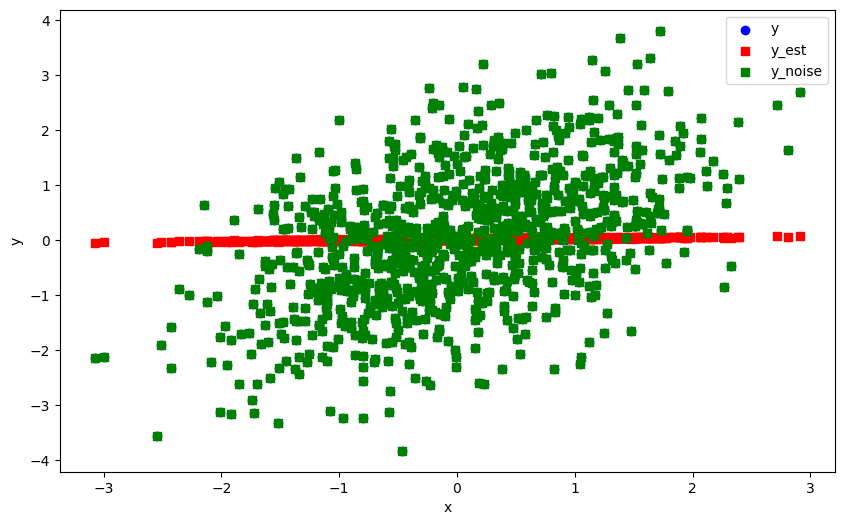

The programm is closed


In [29]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 0], X.detach().numpy()[:, 1], label='y', color='blue', marker='o')  # Plot x vs. y1
plt.scatter(X.detach().numpy()[:, 0], x_est.detach().numpy()[:, 1], label='y_est', color='red', marker='s') 
plt.scatter(X.detach().numpy()[:, 0], X_true.detach().numpy()[:, 1], label='y_noise', color='green', marker='s') 
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

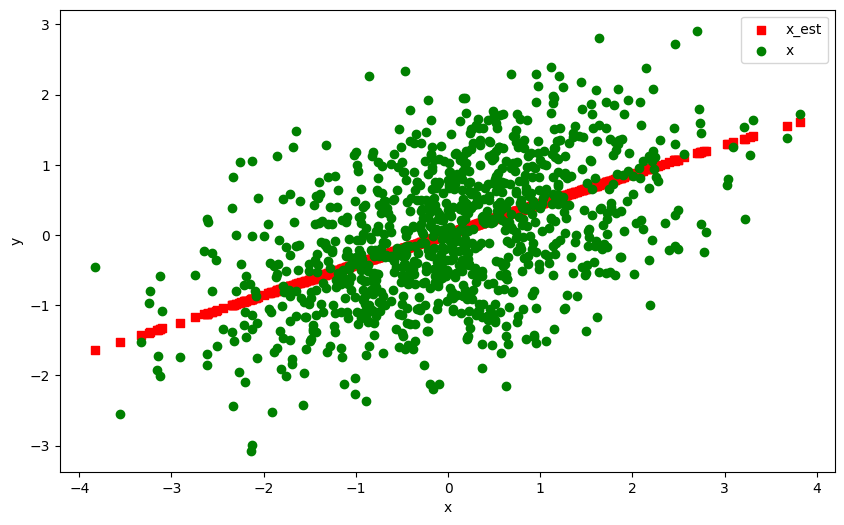

The programm is closed


In [30]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 1], x_est.detach().numpy()[:, 0], label='x_est', color='red', marker='s') 
plt.scatter(X.detach().numpy()[:, 1], X.detach().numpy()[:, 0], label='x', color='green', marker='o')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")